In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from gym_multigrid.envs import MARL_env 

from matplotlib.colors import ListedColormap
from collections import deque
import random
import copy
from collections import OrderedDict
import pandas as pd
import time

seed = 0
np.random.seed(seed)
random.seed(seed)

In [2]:
class MultiAgentEnvWrapper:
    """
    Wrapper class for CustomMultiAgentEnv that distinguishes between training and testing phases
    """
    
    def __init__(self, is_testing=False, width=10, height=10, max_steps=100, seed=None,
                 agent_positions=None, goal_positions=None, walls=None):
        self.is_testing = is_testing
        self.width = width
        self.height = height
        self.max_steps = max_steps
        self.seed = seed
        self.envs = []  # stores all environments created
        self.initial_states = []
        
        if agent_positions is None or goal_positions is None:
            raise ValueError("agent_positions and goal_positions must be provided")
        
        # Training mode: one env per agent/goal pair
        if not is_testing:
            for agent_pos, goal_pos in zip(agent_positions, goal_positions):
                agents = [{"start": agent_pos, "goal": goal_pos}]
                env = MARL_env.CustomMultiAgentEnv(
                    width=width,
                    height=height,
                    max_steps=max_steps,
                    seed=seed,
                    agents=agents
                )
                
                # Add walls if specified
                if walls:
                    for wall_x, wall_y in walls:
                        env.add_wall(wall_x, wall_y)
                
                self.envs.append(env)
                self.initial_states.append(env.reset()[0])  # Get first agent's observation
        
        # Test mode: one env with all agents and goals
        else:
            agents = [{"start": start, "goal": goal} for start, goal in zip(agent_positions, goal_positions)]
            env = MARL_env.CustomMultiAgentEnv(
                width=width,
                height=height,
                max_steps=max_steps,
                seed=seed,
                agents=agents
            )
            
            # Add walls if specified
            if walls:
                for wall_x, wall_y in walls:
                    env.add_wall(wall_x, wall_y)
            
            self.envs.append(env)
            self.initial_states.append(env.reset())
    
    def reset(self, idx=0):
        return self.envs[idx].reset(), self.get_agent_position(idx=idx)
    def step(self, actions, idx=0):
        """
        Execute a step in the environment with the given actions for each agent.
        
        Args:
            actions: List of actions, one per agent or single action
            idx: Index of the environment to use
            
        Returns:
            observations: List of observations for each agent
            rewards: List of rewards for each agent
            terminated: If the episode is terminated by reaching goals
            truncated: If the episode is truncated by exceeding max steps
            info: Additional information
        """
        # Make sure we're using the right environment
        env = self.envs[idx]
        
        # Different handling for training vs testing
        if not self.is_testing:
            # Training mode - one action for one agent
            if not isinstance(actions, list):
                obs, rewards, terminated, truncated, info = env.step([actions])
                return obs[0], rewards[0], terminated, truncated, info  # Return just the first agent's results
            else:
                obs, rewards, terminated, truncated, info = env.step(actions)
                return obs[0], rewards[0], terminated, truncated, info  # Return just the first agent's results
        else:
            # Testing mode - list of actions for multiple agents
            if not isinstance(actions, list):
                # Convert single action to list if needed
                actions = [actions]
            
            # Make sure we have enough actions for all agents
            if len(actions) < len(env.agents):
                actions = actions + [0] * (len(env.agents) - len(actions))
            obs, rewards, terminated, truncated, info = env.step(actions)
            # Call the environment's step method
            return obs, rewards, terminated, truncated, info

    def visualize(self, idx=0, highlight_masks=None, show=True):
        """
        Visualize the environment at the specified index
        
        Args:
            idx: Index of the environment to visualize
            highlight_masks: Optional mask to highlight specific cells
            show: Whether to display the image (True) or just return it (False)
        
        Returns:
            numpy.ndarray: The rendered grid image
        """
        grid_image = self.envs[idx].visualize(highlight_masks=highlight_masks, show=show)
        return grid_image
    
    def get_action_space(self):
        # 0: left, 1: right, 2: forward, 3: toggle, 4: stay
        return list(range(5))
    
    def all_agents_at_goals(self, idx=0):
        return self.envs[idx].all_agents_at_goals()
    
    def run_random_agents(self, max_steps=100, idx=0):
        self.envs[idx].run_random_agents(max_steps)
    
    def get_agent_position(self, idx=0):
        """Get the current position of the agent."""
        if self.is_testing:
            return tuple(self.envs[0].agents[idx].pos)
        else:
            return tuple(self.envs[idx].agents[0].pos)
    def collision():
        return MARL_env.CustomMultiAgentEnv.are_agents_colliding()
    def get_agent_goal(self, idx=0):
        """
        Get the goal position of the agent.
        
        Args:
            idx: Index of the agent whose goal position to retrieve
            
        Returns:
            tuple: (x, y) coordinates of the agent's goal position
        """
        if self.is_testing:
            # In testing mode, get the goal for the specified agent
            env = self.envs[0]
            return tuple(env.agent_goals[idx])
        else:
            # In training mode, get the goal for the single agent in the environment
            env = self.envs[idx]
            return tuple(env.agent_goals[0])
    def get_lava_pos(self):
        """
        Get the positions of lava cells in the environment.
        
        Returns:
            list: List of (x, y) coordinates of lava positions
        """
        return self.envs[0].lava_positions

In [3]:
class DynaQLearningAgent:

    def __init__(self, 
                 state_dim, 
                 action_dim, 
                 lr=0.1, 
                 gamma=0.99, 
                 epsilon=0.1,
                 n_planning=10):
        
        # environment
        self.state_dim = state_dim
        self.action_dim = action_dim

        # hyperparameters
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_planning = n_planning

        # model
        self.q_table = dict()
        self.model = dict()

    def action_space(self):
        return [0, 1, 2, 3, 4]  # UP, DOWN, LEFT, RIGHT, STOP

    def best_action(self, array):

        max_value = np.max(array)
        max_indices = np.where(array == max_value)[0]
        action = np.random.choice(max_indices)

        return action
    
    def select_action(self, state, eval=False):
        
        state_index = self.state_to_position(state)

        if state_index not in self.q_table:
            self.q_table[state_index] = np.zeros(self.action_dim)
        
        if not eval and np.random.rand() < self.epsilon:
            return np.random.choice(self.action_dim)

        action = np.argmax(self.q_table[state_index])
        # action = self.best_action(self.q_table[state_index])
        # if eval:
        #     return np.argmax(self.q_table[state_index])
        
        return action
    
    def q_learning(self, state, action, reward, next_state, done): 

        td_target = reward + self.gamma * (np.max(self.q_table[next_state])) * (1 - done)
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.lr * td_error

    def q_planning(self):
        for _ in range(self.n_planning):
            (state, action), (reward, state_next, done) = random.choice(list(self.model.items()))
            self.q_learning(state, action, reward, state_next, done)

    
    def update(self, state, action, reward, next_state, done):

        state_index = (self.state_to_position(state))
        next_state_index = (self.state_to_position(next_state))
        
        if state_index not in self.q_table:
            self.q_table[state_index] = np.zeros(self.action_dim)

        if next_state_index not in self.q_table:
            self.q_table[next_state_index] = np.zeros(self.action_dim)

        self.q_learning(state_index, action, reward, next_state_index, done)
        self.model[(state_index, action)] = reward, next_state_index, done 
        self.q_planning()
        
    def state_to_position(self, state):
        """
        Convert state to a hashable position representation.
        
        Args:
            state: Can be:
                - A tuple (x, y)
                - A tuple containing (observation, position)
                - A list [x, y]
                - A numpy array observation
            
        Returns:
            A hashable tuple representing the agent's position
        """
        if isinstance(state, tuple):
            # Check if this is a tuple of (observation, position)
            if len(state) == 2 and isinstance(state[1], tuple):
                return state[1]  # Return the position part
            return state  # It's already a position tuple
        elif isinstance(state, list):
            return tuple(state)  # Convert list to tuple
        elif isinstance(state, np.ndarray):
            # If state is a full observation array and we have env reference
            if hasattr(self, 'env_wrapper') and hasattr(self, 'agent_idx'):
                return self.env_wrapper.get_agent_position(self.agent_idx)
            else:
                print("Cannot extract position from numpy array without env_wrapper reference")
                return (0, 0)  # Default fallback
        else:
            print(f"Error: Unexpected state type: {type(state)}")
            return (0, 0)  # Default fallback

    def print_tables(self, name):
        if name == 'qtable':
            table = self.q_table
            print(f"{len(table)} out of {(SHAPE[0])*(SHAPE[1])} grids have been reached.")
            col_names=['UP', 'DOWN', 'LEFT', 'RIGHT', 'STOP']
            # col_names=['UP', 'DOWN', 'LEFT', 'RIGHT']
        elif name == 'model':
            table = self.model
            print(f"{len(self.model)} out of {(SHAPE[0])*(SHAPE[1])*self.action_dim} possibilities have been memorized.")
            col_names=['Reward', 'NextState', 'Done']
        else:
            print("Invalid table name.")
            return

        ordered_coords_dict =  OrderedDict(sorted(table.items())).copy()
        df = pd.DataFrame.from_dict(ordered_coords_dict, orient='index', columns=col_names)
        df = df.round(2)
        print(df)

        return [len(table), (SHAPE[0]-2)*(SHAPE[1]-2), len(self.model), (SHAPE[0]-2)*(SHAPE[1]-2)*self.action_dim]
    
    def tables_2(self):
        return [len(self.q_table), len(self.model)]

In [4]:
def train_agent(env_wrapper, agent: DynaQLearningAgent, num_episodes=1000, max_steps=1000, print_process=True, agent_idx=0):
    """
    Entraîne un agent dans un environnement donné (env_wrapper) sur plusieurs épisodes.
    """
    all_rewards = []

    for episode in range(num_episodes):
        # Reset environment and get initial state (which now includes position)
        state = env_wrapper.reset(agent_idx)  # This now returns (observation, position)
        total_reward = 0
        
        if print_process and episode % 10 == 0:
            print(f"Episode {episode}, Agent {agent_idx+1}")
        
        for i in range(max_steps):
            action = agent.select_action(state, eval=False)
            next_state, reward, terminated, truncated, info = env_wrapper.step(action, agent_idx)
            done = terminated or truncated
            
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            
            if done:
                break

        all_rewards.append(total_reward)

        if print_process and episode % 10 == 0:
            print(f"Episode {episode}, Total Reward for Agent {agent_idx+1}: {total_reward}")
    
    return all_rewards
def smooth(data, weight=0.9):  
    """
    Lisse les données en utilisant un facteur de pondération (smooth).
    :param data: La liste des données à lisser.
    :param weight: Le facteur de pondération utilisé pour le lissage.
    :return: La liste des données lissées.
    """
    last = data[0]
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards_for_all_agents(all_rewards, filename='rewards.png'):
    """
    Trace les récompenses pour tous les agents après l'entraînement.
    
    :param all_rewards: Une liste des récompenses pour chaque agent.
    :param filename: Le nom du fichier pour enregistrer le graphique.
    """
    plt.figure(figsize=(10, 6))

    for idx, rewards in enumerate(all_rewards):
        smoothed_rewards = smooth(rewards)  # Lissage des récompenses
        plt.plot(smoothed_rewards, label=f"Agent {idx+1}")  # Tracer les récompenses lissées
    
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Q-learning for Multiple Agents')
    plt.legend()
    plt.show()

    print(f"Plot saved as {filename}")

def train_all_agents(env_wrapper, agents, num_episodes=1000, max_steps=1000):
    """
    Entraîne plusieurs agents indépendamment dans un environnement multi-agent.
    
    :param env_wrapper: Le wrapper de l'environnement avec plusieurs agents.
    :param agents: Une liste d'agents à entraîner.
    :param num_episodes: Nombre d'épisodes pour l'entraînement de chaque agent.
    :param max_steps: Nombre maximal d'étapes par épisode.
    :return: Une liste des récompenses pour chaque agent.
    """
    all_agents_rewards = []
    
    for idx, agent in enumerate(agents):
        print(f"\nTraining Agent {idx+1}...")
        agent_rewards = train_agent(env_wrapper, agent, num_episodes, max_steps, agent_idx=idx)
        all_agents_rewards.append(agent_rewards)
    
    return all_agents_rewards
# Après l'entraînement de tous les agents, vous pouvez afficher leur Q-table comme suit :

def print_qtables(agents):
    for idx, agent in enumerate(agents):
        print(f"\nQ-table for Agent {idx+1}:")
        agent.print_tables('qtable')  # Utilise la fonction print_tables pour afficher la Q-table





In [5]:
def compute_reachable_states(env, agent_idx=0, start_pos=None, n_steps=5):
    """
    Computes all states reachable for an agent in n_steps.
    
    Args:
        env: The MultiAgentEnvWrapper environment
        agent_idx: Index of the agent to compute reachable states for
        start_pos: Optional starting position, defaults to agent's current position
        n_steps: Number of steps to look ahead
        
    Returns:
        tuple: (reachable_by_step, all_reachable)
            - reachable_by_step: Dict mapping step number to set of positions {step: {positions}}
            - all_reachable: Set of all reachable positions
    """
    # Reset environment to get initial state if needed
    if start_pos is None:
        if env.is_testing:
            # In testing mode, there's only one environment (index 0) with multiple agents
            obs_tuple = env.reset(0)  # Always reset env 0 in testing mode
            start_pos = env.get_agent_position(idx=agent_idx)  # Get position for the specific agent
        else:
            # In training mode, reset the specific agent's environment
            if agent_idx < len(env.envs):
                obs_tuple = env.reset(agent_idx)
                # Extract position from reset's return value
                if isinstance(obs_tuple, tuple) and len(obs_tuple) == 2:
                    start_pos = obs_tuple[1]
                else:
                    start_pos = env.get_agent_position(idx=agent_idx)
            else:
                return {}, set()
    
    # Create queue for BFS search
    queue = deque([(start_pos, 0)])  # (position, steps_taken)
    visited = {start_pos}  # Track visited states
    reachable = {0: {start_pos}}  # Reachable states by steps: {steps: {positions}}
    
    # Define movement actions (0=stay, 1=west, 2=east, 3=north, 4=south)
    actions = [0, 1, 2, 3, 4]  # Include 0 (stay) for reachability analysis
    
    # Run BFS to find all reachable states
    while queue:
        pos, steps = queue.popleft()
        
        if steps >= n_steps:
            continue
            
        # Try each action
        for action in actions:
            next_pos_array = np.array(pos)
            
            # Traitement explicite pour l'action "stay"
            if action == 0:
                next_pos = pos  # Rester sur place
            elif action == 1:  # west/left
                next_pos_array[0] -= 1
                next_pos = tuple(next_pos_array)
            elif action == 2:  # east/right
                next_pos_array[0] += 1
                next_pos = tuple(next_pos_array)
            elif action == 3:  # north/up
                next_pos_array[1] -= 1
                next_pos = tuple(next_pos_array)
            elif action == 4:  # south/down
                next_pos_array[1] += 1
                next_pos = tuple(next_pos_array)
            
            # Pour l'action 0 (stay), nous n'avons pas besoin de vérifier les limites
            # ou les murs car la position ne change pas
            if action == 0:
                if next_pos not in visited:
                    visited.add(next_pos)
                    queue.append((next_pos, steps + 1))
                    
                    # Add to reachable states for this step count
                    if steps + 1 not in reachable:
                        reachable[steps + 1] = set()
                    reachable[steps + 1].add(next_pos)
                continue
            
            # Check boundaries
            if (0 <= next_pos_array[0] < env.width and 
                0 <= next_pos_array[1] < env.height):
                # For wall checking, we need a reference to the grid
                if env.is_testing:
                    grid = env.envs[0].grid
                else:
                    # Make sure agent_idx is within range
                    if agent_idx < len(env.envs):
                        grid = env.envs[agent_idx].grid
                    else:
                        # Skip if agent_idx is out of range
                        continue
                
                # Check for walls
                
                next_pos = tuple(next_pos_array)
                
                # If this is a new reachable state
                if next_pos not in visited:
                    visited.add(next_pos)
                    queue.append((next_pos, steps + 1))
                    
                    # Add to reachable states for this step count
                    if steps + 1 not in reachable:
                        reachable[steps + 1] = set()
                    reachable[steps + 1].add(next_pos)
    
    # Flatten all reachable states
    all_reachable = set()
    for step in reachable:
        all_reachable.update(reachable[step])
    
    return reachable, all_reachable

def n_unsafe_set(env, agent_idx1=0, agent_idx2=1, n=5):
    """
    Computes the unsafe set for two agents in n steps.
    
    Args:
        env: The environment wrapper
        agent_idx1: Index of the first agent
        agent_idx2: Index of the second agent
        n: Number of steps to look ahead
        
    Returns:
        dict: Unsafe states where both agents could potentially collide, by step
    """
    # Check if we have enough agents in the environment
    if env.is_testing:
        # In testing mode, check agents in the single environment
        num_agents = len(env.envs[0].agents) if env.envs else 0
    else:
        # In training mode, count the number of environments
        num_agents = len(env.envs)
        
    # Validate agent indices
    if agent_idx1 >= num_agents or agent_idx2 >= num_agents:
        
        return {}  # Return empty dict to match expected return type for from_reachable_to_mask
    
    # Get reachable states for both agents
    _, all_reachable_agent_1 = compute_reachable_states(env, agent_idx=agent_idx1, n_steps=n)
    _, all_reachable_agent_2 = compute_reachable_states(env, agent_idx=agent_idx2, n_steps=n)
    
    
    # Compute intersection of all reachable positions
    intersections = all_reachable_agent_1.intersection(all_reachable_agent_2)
    
    # Store intersections under a single key to match the expected return format
    unsafe_set = {0: intersections} if intersections else {}
    
    return unsafe_set

def from_reachable_to_mask(reachable_by_step, env_width, env_height, env, fixed_color=None):
    """
    Convert reachable states to a mask for visualization with better color control.

    Args:
        reachable_by_step: Dict mapping step number to set of positions {step: {positions}}
        env_width: Width of the environment
        env_height: Height of the environment
        env: Reference to environment wrapper
        fixed_color: If provided, use this color index for all positions
        
    Returns:
        np.ndarray: Mask with reachable states
    """
    # Create a 2D array of lists to store highlight colors at each position
    mask = np.empty((env_width, env_height), dtype=object)
    for i in range(env_width):
        for j in range(env_height):
            mask[i, j] = []

    # Get reference to the world object for colors
    env_world = env.envs[0].world
    color_count = len(env_world.IDX_TO_COLOR)
    
   
    # Count total positions to process
    total_positions = sum(len(positions) for positions in reachable_by_step.values())
   
    
    # Add highlights for each step and position
    for step, positions in reachable_by_step.items():
     
        for pos in positions:
            x, y = pos
            if 0 <= x < env_width and 0 <= y < env_height:
                # Use fixed color if provided, otherwise use step % colors
                color = fixed_color if fixed_color is not None else (step % color_count)
                mask[x, y].append(color)
    
    return mask


def K_agents_n_unsafe_set(env, agent_idx=0, n_steps=4, exclude_indices=None):
    """
    Computes the unsafe set for a specific agent by considering its interaction
    with all other agents in the environment. Also counts how many times each position
    is shared among different agents.
    
    Args:
        env: The MultiAgentEnvWrapper environment
        agent_idx: Index of the agent for which to compute the unsafe set
        n_steps: Number of steps to look ahead
        exclude_indices: Optional list of agent indices to exclude from the computation
        
    Returns:
        dict: Unsafe set for the specified agent with counts of how many agents share each position
    """
    # Determine the number of agents in the environment
    if env.is_testing:
        num_agents = len(env.envs[0].agents) if env.envs else 0
    else:
        num_agents = len(env.envs)
    
    # Initialize empty combined unsafe set
    # Instead of using sets, we'll use dictionaries to track counts
    combined_unsafe_set = {}
    position_counts = {}  # To track counts for each position
    
    # Initialize exclude_indices if None
    if exclude_indices is None:
        exclude_indices = []
    
    # Make sure agent_idx itself is excluded
    if agent_idx not in exclude_indices:
        exclude_indices.append(agent_idx)
    
    # For each other agent, compute the pairwise unsafe set
    for other_idx in range(num_agents):
        if other_idx in exclude_indices:
            continue
        
        # Compute pairwise unsafe set between agent_idx and other_idx
        pairwise_unsafe = n_unsafe_set(env, agent_idx1=agent_idx, agent_idx2=other_idx, n=n_steps)
        
        # Merge with the combined unsafe set and update counts
        for step, positions in pairwise_unsafe.items():
            if step not in combined_unsafe_set:
                combined_unsafe_set[step] = set()
                position_counts[step] = {}
            
            # Update the set of positions
            combined_unsafe_set[step].update(positions)
            
            # Update count for each position
            for pos in positions:
                if pos not in position_counts[step]:
                    position_counts[step][pos] = 1
                else:
                    position_counts[step][pos] += 1
    
    # Print statistics about the combined unsafe set
    total_unsafe_cells = sum(len(positions) for positions in combined_unsafe_set.values())
    
    # Create a dictionary of positions with their counts
    unsafe_with_counts = {}
    for step, positions in combined_unsafe_set.items():
        unsafe_with_counts[step] = {pos: position_counts[step][pos] for pos in positions}
    
    return unsafe_with_counts

def visualize_all_agents_unsafe_sets(env_wrapper, n_steps=4):
    """
    Visualizes the unsafe sets for all agents in the environment.
    
    Args:
        env_wrapper: The MultiAgentEnvWrapper environment
        n_steps: Number of steps to look ahead for computing unsafe sets
    """
    # Determine the number of agents
    if env_wrapper.is_testing:
        num_agents = len(env_wrapper.envs[0].agents) if env_wrapper.envs else 0
    else:
        num_agents = len(env_wrapper.envs)
    
    
    
    # Get the environment dimensions
    env_width = env_wrapper.width
    env_height = env_wrapper.height
    
    # For each agent, compute and visualize its unsafe set
    for agent_idx in range(num_agents):
        
        
        # Compute the unsafe set for this agent
        unsafe_set = K_agents_n_unsafe_set(
            env_wrapper, 
            agent_idx=agent_idx, 
            n_steps=n_steps
        )
        print(f"Unsafe set for Agent {agent_idx+1}: {unsafe_set}")
        # Convert the unsafe set to a visualization mask
        unsafe_mask = from_reachable_to_mask(
            unsafe_set, 
            env_width, 
            env_height, 
            env_wrapper,
            fixed_color=0  # Use red for unsafe areas
        )
        
        # Get the agent's current position
        agent_pos = env_wrapper.get_agent_position(idx=agent_idx)
        
        
        # Get the agent's goal position
        goal_pos = goal_positions[agent_idx] if agent_idx < len(goal_positions) else None
        
        
        # Count total unsafe cells
        total_unsafe_cells = sum(len(positions) for positions in unsafe_set.values())
        
        
        # Visualize the environment with the unsafe set
        
        env_wrapper.visualize(highlight_masks=unsafe_mask)
        
        # Add a separator for clarity
        
    # Define agent positions in a cycle (each agent's goal is the next agent's position)


In [6]:
env=MultiAgentEnvWrapper(
    is_testing=True,
    width=10,
    height=10,
    max_steps=100,
    agent_positions=[(1, 1), (2, 2), (3, 3)],
    goal_positions=[(8, 8), (7, 7), (6, 6)],
    walls=[(5, 5)]
)
_,reachable=compute_reachable_states(env, agent_idx=0, n_steps=0)
print(reachable)

{(1, 1)}


Unsafe set for Agent 1: {}


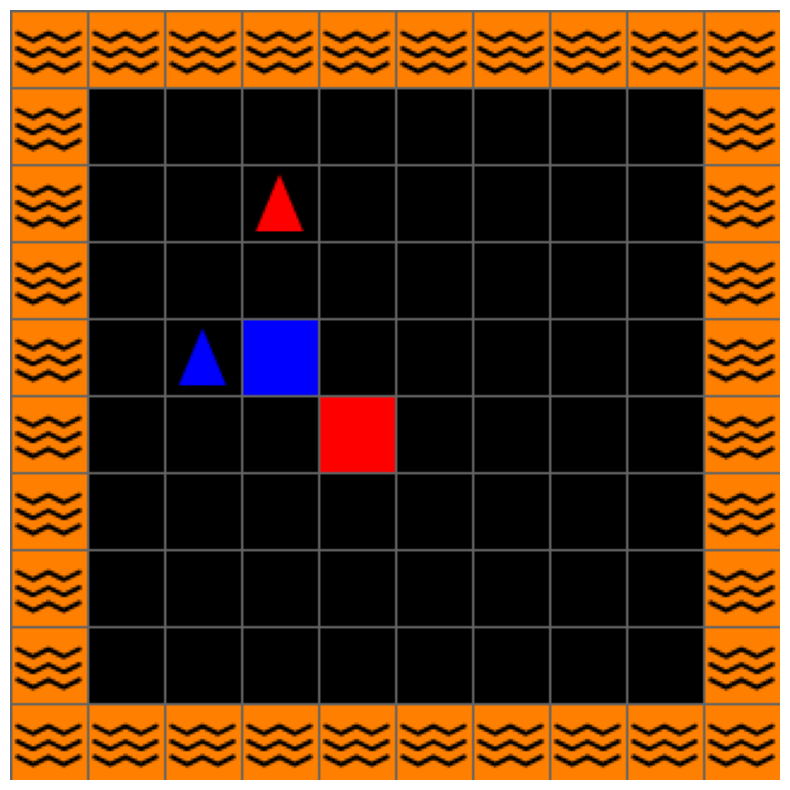

Unsafe set for Agent 2: {}


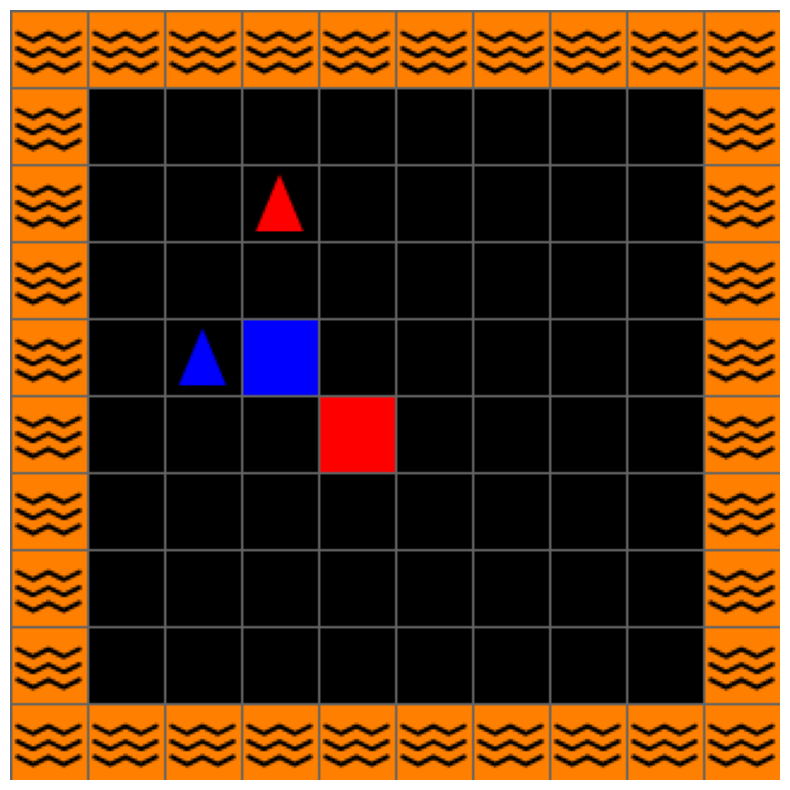

In [7]:
# # Define agent positions in a cycle (each agent's goal is the next agent's position)
agent_positions = [(3,2),(2,4)]
                #    ,(2,2),(5,6),(1,2)] # Rotate to create cycle with +1 to x coordinate
goal_positions = [(4,5),(3,4)]
                #   ,(6,6),(1,1),(5,3)] # Rotate to create cycle with +1 to x coordinate
width = 10
height = 10
# num_agents =4
# agent_positions, goal_positions = generate_random_positions(num_agents=num_agents, width=width, height=height, min_distance=2)

# Define some walls to make the environment more interesting
walls = [(i, 5) for i in range(3, 7)]

# Create training environment (separate environment for each agent)
train_env = MultiAgentEnvWrapper(
    is_testing=True,
    width=height,
    height=height,
    agent_positions=agent_positions,
    goal_positions=goal_positions,
    walls=walls
)
visualize_all_agents_unsafe_sets(train_env, n_steps=1)

In [8]:
def model(env, agent_idx, state, action, unsafe_set_dict=None,k=None):
    """
    Simule l'exécution d'une action à partir d'un état donné, en tenant compte des états dangereux.
    
    Args:
        env: L'environnement MultiAgentEnvWrapper
        agent_idx: L'indice de l'agent concerné
        state: La position actuelle de l'agent (tuple)
        action: L'action à simuler (0=stay, 1=west, 2=east, 3=north, 4=south)
        unsafe_set_dict: Dictionnaire d'états dangereux par étape {step: {positions}}
    
    Returns:
        tuple: (reward, next_state, done)
            - reward: La récompense obtenue pour cette transition
            - next_state: La position suivante de l'agent (tuple)
            - done: Booléen indiquant si l'épisode est terminé
    """
    # Valeur par défaut pour le reward
    reward = 0  # Pénalité par défaut pour chaque étape
    done = False
    # Obtenir l'environnement interne approprié
    agent_goal_pos = env.get_agent_goal(agent_idx)
    lava_positions = env.get_lava_pos() if hasattr(env, 'get_lava_pos') else []
    is_unsafe = False
    goal_is_safe = True
    # Déterminer quel environnement et quelle grille utiliser
    if env.is_testing:
        grid = env.envs[0].grid
    else:
        grid = env.envs[agent_idx].grid
    next_state_array = np.array(state)
    # Simulation de l'action
    if action==0:
        next_state = state 
        reward=-10 # Rester sur place
        # Convertir l'état en tableau numpy pour la manipulation
    
    if action == 1:  # west/left
        next_state_array[0] -= 1
    elif action == 2:  # east/right
        next_state_array[0] += 1
    elif action == 3:  # north/up
        next_state_array[1] -= 1
    elif action == 4:  # south/down
        next_state_array[1] += 1
    # action 0 (stay) ne change pas la position
    
    # Vérifier les limites de la grille et les obstacles
    if (0 <= next_state_array[0] < env.width and 
        0 <= next_state_array[1] < env.height):
        next_state = tuple(next_state_array)
        
        # Vérifier s'il s'agit d'un mur ou d'un obstacle infranchissable
        grid_obj = grid.get(next_state[0], next_state[1])
        if grid_obj and not (hasattr(grid_obj, 'can_enter') and grid_obj.can_enter()):
            # Si c'est un mur, rester à la position actuelle et appliquer pénalité
            next_state = state
            # Pénalité pour ne pas pouvoir bouger (similaire à la pénalité dans MARL_env)
  
            reward -= 2
        else:
            if unsafe_set_dict :
                if k is not None:
                # Vérifier si le prochain état est dans l'ensemble dangereux
                
                    for step, positions_with_counts in unsafe_set_dict.items():
                        if agent_goal_pos in positions_with_counts:
                            goal_is_safe = False
                        if next_state in positions_with_counts:
                            # Obtenir le compte pour cette position
                            count = positions_with_counts[next_state]
                            # Calculer la pénalité pour un état dangereux
                            reward =  -2-np.log(count) # Pénalité
                            is_unsafe = True
                            break
                    
                    if not is_unsafe:
                        # Si l'état n'est PAS dangereux, donner une récompense positive
                        reward = k
                else:
                    for step, positions_with_counts in unsafe_set_dict.items():
                        if agent_goal_pos in positions_with_counts:
                            goal_is_safe = False
                        if next_state in positions_with_counts:
                            # Obtenir le compte pour cette position
                            count = positions_with_counts[next_state]
                            # Calculer la pénalité en fonction du compte (-2 * nombre d'agents qui peuvent atteindre cet état)
                            reward = - 2 - np.log(count)
                            is_unsafe=True 
                            break

            # Vérifier si l'agent a atteint son but
            if agent_goal_pos and next_state == agent_goal_pos:
                if action == 0:  # Si l'agent reste sur place à l'objectif
                    reward += 60  # Récompense supérieure à la récompense d'arrivée
                else:
                    reward += 50  # Récompense d'arrivée standard
                done = True
            
            # Vérifier si l'agent est sur une cellule de lave
            if lava_positions and next_state in lava_positions:
                reward = -50.0  # Forte pénalité pour la lave
            
    else:
        # Si hors limites, rester à la position actuelle
        next_state = state
    return reward, next_state, done ,is_unsafe

In [9]:
def model(env, agent_idx, state, action, unsafe_set_dict=None, k=None):
    """
    Simule l'exécution d'une action à partir d'un état donné, en tenant compte des états dangereux.
    
    Args:
        env: L'environnement MultiAgentEnvWrapper
        agent_idx: L'indice de l'agent concerné
        state: La position actuelle de l'agent (tuple)
        action: L'action à simuler (0=stay, 1=west, 2=east, 3=north, 4=south)
        unsafe_set_dict: Dictionnaire d'états dangereux par étape {step: {position: count}}
        k: Si fourni, récompense donnée pour les actions sûres
    
    Returns:
        tuple: (reward, next_state, done, is_unsafe)
    """
    # Valeur par défaut pour le reward
    reward = -1.0  # Pénalité par défaut pour chaque étape
    done = False
    is_unsafe = False  # Initialisation du flag pour les états dangereux
    
    # Obtenir l'environnement interne approprié
    agent_goal_pos = env.get_agent_goal(agent_idx)
    lava_positions = env.get_lava_pos() if hasattr(env, 'get_lava_pos') else []
    
    # Déterminer quel environnement et quelle grille utiliser
    if env.is_testing:
        grid = env.envs[0].grid
    else:
        grid = env.envs[agent_idx].grid
    
    next_state_array = np.array(state)
    
    # Simulation de l'action
    if action == 0:  # Rester sur place
        next_state = state 
        reward = -5
    elif action == 1:  # west/left
        next_state_array[0] -= 1
        next_state = tuple(next_state_array)
    elif action == 2:  # east/right
        next_state_array[0] += 1
        next_state = tuple(next_state_array)
    elif action == 3:  # north/up
        next_state_array[1] -= 1
        next_state = tuple(next_state_array)
    elif action == 4:  # south/down
        next_state_array[1] += 1
        next_state = tuple(next_state_array)
    
    # Vérifier les limites de la grille et les obstacles
    if action != 0 and not (0 <= next_state_array[0] < env.width and 0 <= next_state_array[1] < env.height):
        # Si hors limites, rester à la position actuelle
        next_state = state
        reward = -2
    elif action != 0:  # Vérification des murs seulement si l'agent tente de bouger
        # Vérifier s'il s'agit d'un mur ou d'un obstacle infranchissable
        grid_obj = grid.get(next_state[0], next_state[1])
        if grid_obj and not (hasattr(grid_obj, 'can_enter') and grid_obj.can_enter()):
            # Si c'est un mur, rester à la position actuelle
            next_state = state
            reward = -2
    
    # PREMIÈRE ÉTAPE : Déterminer si l'état est unsafe (avant de calculer les récompenses)
    # Vérifier si l'état suivant est dans l'ensemble des états dangereux
    if unsafe_set_dict:
        for step, positions_with_counts in unsafe_set_dict.items():
            if next_state in positions_with_counts:
                count = positions_with_counts[next_state]
                is_unsafe = True
                break
    
    # Vérifier si l'état suivant est sur de la lave (également considéré comme unsafe)
    
    # DEUXIÈME ÉTAPE : Maintenant qu'on a déterminé si l'état est unsafe, calculer les récompenses
    if next_state == agent_goal_pos:
        # Récompense pour atteindre l'objectif
        reward = 50
        done = True
    elif next_state in lava_positions:
        # Pénalité pour la lave
        reward = -50.0
    elif is_unsafe and unsafe_set_dict:
        # Calculer la pénalité pour un état unsafe
        for step, positions_with_counts in unsafe_set_dict.items():
            if next_state in positions_with_counts:
                count = positions_with_counts[next_state]
                reward = -2-np.log(count)  # Pénalité basée sur le nombre d'agents pouvant atteindre cet état
                break
 
    return reward, next_state, done, is_unsafe

In [16]:
def model(env, agent_idx, state, action, unsafe_set_dict=None, k=None):
    """
    Simule l'exécution d'une action à partir d'un état donné, en tenant compte des états dangereux.
    
    Args:
        env: L'environnement MultiAgentEnvWrapper
        agent_idx: L'indice de l'agent concerné
        state: La position actuelle de l'agent (tuple)
        action: L'action à simuler (0=stay, 1=west, 2=east, 3=north, 4=south)
        unsafe_set_dict: Dictionnaire d'états dangereux par étape {step: {position: count}}
        k: Si fourni, récompense donnée pour les actions sûres
    
    Returns:
        tuple: (reward, next_state, done, is_unsafe)
    """
    # Valeur par défaut pour le reward
    reward = -1.0  # Pénalité par défaut pour chaque étape
    done = False
    is_unsafe = False  # Initialisation du flag pour les états dangereux
    
    # Obtenir l'environnement interne approprié
    agent_goal_pos = env.get_agent_goal(agent_idx)
    lava_positions = env.get_lava_pos() if hasattr(env, 'get_lava_pos') else []
    
    # Déterminer quel environnement et quelle grille utiliser
    if env.is_testing:
        grid = env.envs[0].grid
    else:
        grid = env.envs[agent_idx].grid
    
    next_state_array = np.array(state)
    
    # Simulation de l'action
    if action == 0:  # Rester sur place
        next_state = state 
        reward = -5
    elif action == 1:  # west/left
        next_state_array[0] -= 1
        next_state = tuple(next_state_array)
    elif action == 2:  # east/right
        next_state_array[0] += 1
        next_state = tuple(next_state_array)
    elif action == 3:  # north/up
        next_state_array[1] -= 1
        next_state = tuple(next_state_array)
    elif action == 4:  # south/down
        next_state_array[1] += 1
        next_state = tuple(next_state_array)
    
    # Vérifier les limites de la grille et les obstacles
    if action != 0 and not (0 <= next_state_array[0] < env.width and 0 <= next_state_array[1] < env.height):
        # Si hors limites, rester à la position actuelle
        next_state = state
        reward = -2
    elif action != 0:  # Vérification des murs seulement si l'agent tente de bouger
        # Vérifier s'il s'agit d'un mur ou d'un obstacle infranchissable
        grid_obj = grid.get(next_state[0], next_state[1])
        if grid_obj and not (hasattr(grid_obj, 'can_enter') and grid_obj.can_enter()):
            # Si c'est un mur, rester à la position actuelle
            next_state = state
            reward = -2
    
    # PREMIÈRE ÉTAPE : Déterminer si l'état est unsafe (avant de calculer les récompenses)
    # Vérifier si l'état suivant est dans l'ensemble des états dangereux
    if unsafe_set_dict:
        for step, positions_with_counts in unsafe_set_dict.items():
            if next_state in positions_with_counts:
                count = positions_with_counts[next_state]
                is_unsafe = True
                break
    
    # Vérifier si l'état suivant est sur de la lave (également considéré comme unsafe)
    if k is  None:
        # DEUXIÈME ÉTAPE : Maintenant qu'on a déterminé si l'état est unsafe, calculer les récompenses
        if next_state == agent_goal_pos:
            # Récompense pour atteindre l'objectif
            reward = 50
            done = True
        elif next_state in lava_positions:
            # Pénalité pour la lave
            reward = -50.0
        elif is_unsafe and unsafe_set_dict:
            # Calculer la pénalité pour un état unsafe
            for step, positions_with_counts in unsafe_set_dict.items():
                if next_state in positions_with_counts:
                    count = positions_with_counts[next_state]
                    reward = -2-4*np.log(count)  # Pénalité basée sur le nombre d'agents pouvant atteindre cet état
                    break
    else:
        if unsafe_set_dict:
            # Vérifier si le prochain état est dans l'ensemble dangereux
            for step, positions_with_counts in unsafe_set_dict.items():
                if next_state in positions_with_counts:
                    count = positions_with_counts[next_state]
                    reward=-k-(count-1)*k/2
                    is_unsafe = True
                    break
            
            # Si l'état n'est PAS dangereux, donner une récompense positive
            if not is_unsafe and action != 0:
                reward = k
            elif action == 0:
                # Si l'agent reste sur place à l'objectif
                reward = -k/3
        else:
            reward=0
    return reward, next_state, done, is_unsafe

In [11]:
def safety_judger(agent_idx, env, unsafe_set_dict, action, safety_threshold=-2.0):
    """
    Détermine si une action est sûre pour un agent en se basant sur le modèle de simulation.
    Utilise la fonction model pour simuler l'action et vérifier si la récompense est supérieure
    au seuil de sécurité.
    
    Args:
        agent_idx: Indice de l'agent
        env: L'environnement wrapper
        unsafe_set_dict: Dictionnaire des états dangereux {step: {position: count}}
        action: L'action à évaluer (0=stay, 1=west, 2=east, 3=north, 4=south)
        safety_threshold: Seuil de récompense en dessous duquel l'action est considérée comme dangereuse
        
    Returns:
        bool: True si l'action est sûre, False sinon
    """
    # Obtenir la position actuelle de l'agent
    current_pos = env.get_agent_position(idx=agent_idx)
    
    # Utiliser le modèle pour simuler l'action et obtenir la récompense
    reward, next_state, done,is_unsafe = model(env, agent_idx, current_pos, action, unsafe_set_dict,k=-safety_threshold)
    
    # Si la récompense est inférieure au seuil de sécurité, l'action est considérée comme dangereuse
    if is_unsafe:
        return False
    
    return True

def select_safe_action(agent_idx, env, action, unsafe_set_dict=None):
    """
    Sélectionne une action sûre pour l'agent.
    Si l'action proposée mène à un état dangereux, remplace par l'action "stay".
    
    Args:
        agent_idx: Indice de l'agent
        env: L'environnement wrapper
        action: L'action proposée à évaluer (0=stay, 1=west, 2=east, 3=north, 4=south)
        unsafe_set_dict: Dictionnaire des états dangereux
        
    Returns:
        int: Action sûre (0=stay si danger détecté, sinon l'action originale)
    """
    # Si aucun ensemble dangereux n'est fourni, permettre l'action
    if not unsafe_set_dict:
        return action
    
    # Obtenir la position actuelle de l'agent
    current_pos = env.get_agent_position(idx=agent_idx)
    
    # Simuler l'action pour voir où elle mène
    _, next_state, _, is_unsafe = model(env, agent_idx, current_pos, action, unsafe_set_dict)
    
    if is_unsafe:
        # Si l'action mène à un état dangereux, rester sur place (action 0)
        return 0
        
    # Si nous arrivons ici, l'action est sûre
    return action# Si l'action n'est pas sûre, rester sur place (action 0)
    


def n_steps_safety_judger(n_steps, env, agents, safety_threshold=-2.0):
    """
    Évalue si les trajectoires des agents sur n étapes sont sûres.
    
    Args:
        n_steps: Nombre d'étapes à prévoir
        env: L'environnement wrapper
        agents: Liste des objets agents
        safety_threshold: Seuil de récompense pour juger de la sécurité
        
    Returns:
        numpy.ndarray: Tableau de booléens indiquant si chaque agent est en sécurité
    """
    judge = np.ones(len(agents), dtype=bool)  # Initialiser à True pour tous les agents
    
    # Obtenir les positions actuelles des agents
    current_positions = [env.get_agent_position(idx=i) for i in range(len(agents))]
    next_positions = current_positions.copy()

    # Prévoir pour chaque agent sur n étapes et vérifier la sécurité
    for agent_idx in range(len(agents)):
        current_state = next_positions[agent_idx]
        
        # Obtenir l'ensemble des états dangereux avec leur compte pour cet agent
        unsafe_set_dict_agent = K_agents_n_unsafe_set(env, agent_idx, n_steps, exclude_indices=None)
        
        # Simulation sur n étapes pour cet agent
        for step in range(n_steps):
            action = agents[agent_idx].select_action(current_state, eval=True)
            if action==0:
                unsafe_set_dict_agent1=K_agents_n_unsafe_set(env, agent_idx, 1, exclude_indices=None)
            # Utiliser le modèle pour simuler l'action et obtenir la récompense
                reward, next_state, _ ,is_unsafe= model(env, agent_idx, current_state, action, unsafe_set_dict_agent1)
            
            # Si la récompense est inférieure au seuil de sécurité, l'agent n'est pas en sécurité
                # Notez que maintenant la récompense peut être plus négative selon le nombre d'agents qui partagent une position
                if is_unsafe:
                    judge[agent_idx] = False

                    break  # Pas besoin de continuer pour cet agent
                   
                
                break  # Mettre à jour l'état pour la prochaine étape
            else:
                reward, next_state, _ ,is_unsafe= model(env, agent_idx, current_state, action, unsafe_set_dict_agent)
            
            # Si la récompense est inférieure au seuil de sécurité, l'agent n'est pas en sécurité
                # Notez que maintenant la récompense peut être plus négative selon le nombre d'agents qui partagent une position
                if is_unsafe:
                    judge[agent_idx] = False

                    break  # Pas besoin de continuer pour cet agent
                    
                current_state = next_state  # Mettre à jour l'état pour la prochaine étape
        # Si toutes les étapes sont sûres, l'agent est considéré comme sûr
        next_positions[agent_idx] = current_state
    
    return judge

In [12]:
# def k_Qlearning(k, L, Qstar, agent_idx, env_wrapper, agent, 
#                 learning_rate=0.1, discount_factor=0.95, kp=None):
#     """
#     Effectue un apprentissage Q-learning localisé dans les états atteignables en k+1 étapes.
#     Version corrigée pour éviter les problèmes d'overflow.
#     """
#     # Récupérer les états atteignables en k+1 étapes
#     reachable_dict, all_reachable = compute_reachable_states(
#         env_wrapper, agent_idx, 
#         start_pos=env_wrapper.get_agent_position(idx=agent_idx), 
#         n_steps=k
#     )
    
#     # Récupérer l'ensemble des états unsafe
#     unsafe_set_dict = K_agents_n_unsafe_set(
#         env_wrapper, agent_idx=agent_idx, 
#         n_steps=k, 
#         exclude_indices=None
#     )
    
#     # Initialiser Q_temp uniquement avec les états atteignables
#     Q_temp = {}
#     for state in all_reachable:
#         if state in Qstar:
#             Q_temp[state] = Qstar[state].copy()
#         else:
#             Q_temp[state] = np.zeros(agent.action_dim)
    
#     # Effectuer L itérations d'apprentissage
#     for _ in range(L):
#         if not all_reachable:
#             continue
            
#         state = random.choice(list(all_reachable))
        
#         for action in range(agent.action_dim):
#             reward, next_state, done, _ = model(env_wrapper, agent_idx, state, action, unsafe_set_dict, kp)
            
#             # Si next_state est hors de all_reachable, on considère que c'est terminal
#             if next_state not in all_reachable:
#                 target = reward  # Pas de valeur future
#             else:
#                 if done:
#                     target = reward
#                 else:
#                     target = reward + discount_factor * np.max(Q_temp[next_state])
            
#             # Mise à jour sécurisée pour éviter l'overflow
#             # Utiliser une forme standard de mise à jour Q-learning
#             Q_temp[state][action] = (1 - learning_rate) * Q_temp[state][action] + learning_rate * target
    
#     # Mise à jour finale (seulement les états dans all_reachable)
#     Q_result = copy.deepcopy(Qstar)
#     for state in all_reachable:
#         Q_result[state] = Q_temp[state]
    
#     return Q_result
def k_Qlearning(k, L, Qstar, agent_idx, env_wrapper, agent,
                  learning_rate=0.1, discount_factor=0.95,kp=None):
    """
    Effectue un apprentissage Q temporel STRICTEMENT localisé dans les états atteignables en k+1 étapes,
    avec pénalisation des états dangereux (Uk_1).
    
    Args:
        k: Nombre d'étapes de planification
        L: Nombre d'itérations d'apprentissage
        Qstar: La Q-table originale à copier et à mettre à jour localement
        agent_idx: Indice de l'agent concerné
        env_wrapper: Wrapper de l'environnement
        agent: L'agent dont on met à jour la Q-table
    
    Returns:
        La Q-table mise à jour UNIQUEMENT pour les états dans Rk_1
    """
    # Récupérer les états atteignables en k+1 étapes
    reachable_dict, all_reachable = compute_reachable_states(
        env_wrapper, agent_idx, 
        start_pos=env_wrapper.get_agent_position(idx=agent_idx), 
        n_steps=k
    )
    
    # Récupérer l'ensemble des états unsafe en k+1 étapes
    unsafe_set_dict = K_agents_n_unsafe_set(
        env_wrapper, agent_idx=agent_idx, 
        n_steps=k, 
        exclude_indices=None
    )
    
    # Copier UNIQUEMENT les états atteignables depuis la Q-table originale
    Q_temp = {}
    for state in all_reachable:
        if state in Qstar:
            Q_temp[state] = Qstar[state].copy()
        else:
            Q_temp[state] = np.zeros(agent.action_dim)
    
    # Effectuer L itérations d'apprentissage sur les états atteignables
    for _ in range(L):
        # Sélectionner aléatoirement un état parmi les états atteignables
        if not all_reachable:
            continue
            
        state = random.choice(list(all_reachable))
        
        # Pour chaque action possible
        for action in range(agent.action_dim):
            # Utiliser le modèle pour simuler l'action
            reward, next_state, done,_ = model(env_wrapper, agent_idx, state, action, unsafe_set_dict,kp)
            # Si le prochain état n'est pas dans notre ensemble atteignable
            # Nous utilisons les valeurs de Qstar s'il y est, sinon une valeur par défaut
            if next_state not in all_reachable:
                # Pour garder la mise à jour strictement locale, on considère que
                # les états hors de l'ensemble atteignable ont une valeur fixe
                if done:
                    target = reward  # Si l'épisode est terminé
                else:
                    # Utiliser la valeur de Qstar pour les états hors de l'ensemble atteignable
                    if next_state in Qstar:
                        next_state_value = np.max(Qstar[next_state])
                    else:
                        next_state_value = 0  # Valeur par défaut
                    
                    target = reward + discount_factor * next_state_value
            else:
                # Si le prochain état est dans l'ensemble atteignable, mise à jour normale
                if done:
                    target = reward
                else:
                    # Utiliser la Q-table temporaire pour les états atteignables
                    target = reward + discount_factor * np.max(Q_temp[next_state])
            
            # Mise à jour de la Q-valeur
            Q_temp[state][action] += learning_rate * (target - Q_temp[state][action])
    
    # Copier toute la Q-table originale
    Q_result = copy.deepcopy(Qstar)
    
    # Mettre à jour uniquement les états atteignables
    for state in all_reachable:
        Q_result[state] = Q_temp[state]
    
    return Q_result
def temporal_q_learning_optimized(k, Qt_plus_1, agent_idx, env_wrapper, agent, 
                               learning_rate=0.1, discount_factor=0.95, kp=None):
    """
    Version optimisée qui effectue une seule mise à jour par état/action
    """
    # Position actuelle de l'agent
    current_pos = env_wrapper.get_agent_position(idx=agent_idx)
    
    # Calculer les états atteignables et ensemble dangereux
    reachable_dict, all_reachable = compute_reachable_states(
        env_wrapper, agent_idx, start_pos=current_pos, n_steps=k
    )
    
    unsafe_set_dict = K_agents_n_unsafe_set(
        env_wrapper, agent_idx=agent_idx, n_steps=k, exclude_indices=None
    )
    
    # Créer une copie pour stocker Qt
    Qt = {}
    
    # Initialiser Qt avec les valeurs de Qt+1
    for state in all_reachable:
        if state in Qt_plus_1:
            Qt[state] = Qt_plus_1[state].copy()
        else:
            Qt[state] = np.zeros(agent.action_dim)
    
    # Une seule passe pour chaque état/action
    for state in all_reachable:
        for action in range(agent.action_dim):
            reward, next_state, done, _ = model(env_wrapper, agent_idx, state, action, unsafe_set_dict, k=kp)
            
            if done:
                target = reward
            else:
                # Utiliser Qt+1 pour l'état suivant
                if next_state in Qt_plus_1:
                    next_state_value = np.max(Qt_plus_1[next_state])
                else:
                    next_state_value = 0
                
                target = reward + discount_factor * next_state_value
            
            # Mise à jour sécurisée pour éviter l'overflow
            # Au lieu de multiplier par un grand nombre (501-learning_rate)
            # On utilise une formule d'interpolation standard avec learning_rate
            Qt[state][action] = (1 - learning_rate) * Qt[state][action] + learning_rate * target
            
    # Mettre à jour uniquement les états atteignables
    Q_result = copy.deepcopy(Qt_plus_1)
    for state in all_reachable:
        Q_result[state] = Qt[state]
        
    return Q_result
def zero_Qlearning(Qt_plus_1, agent_idx, env_wrapper, agent, 
                               learning_rate=0.1, discount_factor=0.95, kp=None):
    
    # Position actuelle de l'agent
    current_pos = env_wrapper.get_agent_position(idx=agent_idx)
    
    # Calculer les états atteignables et ensemble dangereux
    reachable_dict, all_reachable = compute_reachable_states(
        env_wrapper, agent_idx, start_pos=current_pos, n_steps=0
    )
    
    unsafe_set_dict = K_agents_n_unsafe_set(
        env_wrapper, agent_idx=agent_idx, n_steps=1, exclude_indices=None
    )
    
    # Créer une copie pour stocker Qt
    Qt = {}
    
    # Initialiser Qt avec les valeurs de Qt+1
    for state in all_reachable:
        if state in Qt_plus_1:
            Qt[state] = Qt_plus_1[state].copy()
        else:
            Qt[state] = np.zeros(agent.action_dim)
    
    # Une seule passe pour chaque état/action
    for state in all_reachable:
        for action in range(agent.action_dim):
            reward, next_state, done, _ = model(env_wrapper, agent_idx, state, action, unsafe_set_dict, k=kp)
            if done:
                target = reward
            else:
                # Utiliser Qt+1 pour l'état suivant
                if next_state in Qt_plus_1:
                    next_state_value = np.max(Qt_plus_1[next_state])
                else:
                    next_state_value = 0
                
                target = reward + discount_factor * next_state_value
            
            # Mise à jour sécurisée pour éviter l'overflow
            # Au lieu de multiplier par un grand nombre (501-learning_rate)
            # On utilise une formule d'interpolation standard avec learning_rate
            Qt[state][action] = (1 - learning_rate) * Qt[state][action] + learning_rate * target
            
    # Mettre à jour uniquement les états atteignables
    Q_result = copy.deepcopy(Qt_plus_1)
    for state in all_reachable:
        Q_result[state] = Qt[state]
        
    return Q_result
def temp_Qlearning(k, L, Qstar, agent_idx, env_wrapper, agent):
    """Version qui conserve les Q-tables intermédiaires pour chaque étape"""
    # Dictionnaire pour stocker les Q-tables à chaque étape
    Q_steps = {}
    
    # Calculer Q_t_k pour k étapes
    Q_t_k = k_Qlearning(k, L, Qstar, agent_idx, env_wrapper, agent)
    
    # États atteignables en 1 étape depuis la position actuelle
    Reachable_dict, all_reachable = compute_reachable_states(
        env_wrapper, agent_idx, start_pos=env_wrapper.get_agent_position(idx=agent_idx), n_steps=1
    )
    
    # Stocker les valeurs pour l'étape k
    Q_steps[k] = {state: Q_t_k[state].copy() for state in all_reachable if state in Q_t_k}
    
    # Calculer les Q-tables pour les étapes de k-1 à 1
    for i in range(k-1, 0, -1):
        kp=None
        Q_t_k = temporal_q_learning_optimized(i, Q_t_k, agent_idx, env_wrapper, agent,kp=kp)
        # Ajouter cette Q-table au dictionnaire plutôt que de l'écraser
        Q_steps[i] = {state: Q_t_k[state].copy() for state in all_reachable if state in Q_t_k}

    
    
    # Retourner à la fois la Q-table finale et le dictionnaire de toutes les Q-tables
    return Q_t_k, Q_steps

In [13]:
def safety_aware_pipeline(env, agents, k=5, L=1000, safety_threshold=-2.0, Qstars=None):
    """
    Pipeline qui combine la vérification de sécurité et l'apprentissage Q temporel.
    Met à jour les positions des agents en effectuant les actions sélectionnées.
    
    Args:
        env: L'environnement wrapper
        agents: Liste des agents
        k: Paramètre pour l'apprentissage Q temporel (nombre d'étapes de planification)
        L: Nombre d'itérations d'apprentissage
        safety_threshold: Seuil de récompense pour juger la sécurité
    
    Returns:
        tuple: (selected_actions, safety_status, Qsteps)
            - selected_actions: Liste des actions choisies pour chaque agent
            - safety_status: Liste des statuts de sécurité de chaque agent
            - Qsteps: Dictionnaire des Q-tables par agent et par horizon temporel
    """
    # Vérifier si tous les agents ont atteint leur objectif
    safety_env = MultiAgentEnvWrapper(
        is_testing=True,
        width=env.width,
        height=env.height,
        agent_positions=[env.get_agent_position(idx=i) for i in range(len(agents))],
        goal_positions=[env.get_agent_goal(idx=i) for i in range(len(agents))],
        walls=walls  # Utilisez les mêmes murs que l'environnement original
    )
    
    if safety_env.all_agents_at_goals():
        print("All agents have reached their goals!")
        return [0] * len(agents), [True] * len(agents), {}
    
    # Évaluer la sécurité de chaque agent
    safety_status = n_steps_safety_judger(k, safety_env, agents, 
                                         safety_threshold=safety_threshold)
    
    # Stocker les actions sélectionnées pour tous les agents
    selected_actions = []
    Qsteps = {}  # Dictionnaire pour stocker les Q-tables par agent
    
    # Pour chaque agent
    for agent_idx, agent in enumerate(agents):
        one_step_safety=K_agents_n_unsafe_set(safety_env, agent_idx, n_steps=1, exclude_indices=None)
        all_reachable = compute_reachable_states(
            safety_env, agent_idx, start_pos=safety_env.get_agent_position(idx=agent_idx), n_steps=1
        )[1]
        # Initialiser le sous-dictionnaire pour cet agent s'il n'existe pas encore
        if agent_idx not in Qsteps:
            Qsteps[agent_idx] = {}
            
        # Si l'agent n'est pas en sécurité
        if not safety_status[agent_idx]:
            qtable=agent.q_table.copy()
            # Effectuer l'apprentissage Q temporel
            updated_q_table, Qstep = temp_Qlearning(k, L, agent.q_table, agent_idx, safety_env, agent)
            Qstep[k+1]={state: qtable[state].copy() for state in all_reachable if state in qtable}
            # Stocker les Q-tables pour chaque horizon temporel
             # Ceci est déjà un dictionnaire {k: Q-table, k-1: Q-table, ...}
            
            # Mettre à jour la Q-table de l'agent
            agent.q_table = updated_q_table
            
            # Après mise à jour, vérifier quelle action l'agent va prendre
            current_pos = env.get_agent_position(idx=agent_idx)
            action = agent.select_action(current_pos, eval=True)
            
            safe_action = select_safe_action(agent_idx, safety_env, action,unsafe_set_dict=one_step_safety)
            # if safe_action == 0 and current_pos != env.get_agent_goal(idx=agent_idx):
            #     agent.q_table=zero_Qlearning(agent.q_table, agent_idx, safety_env, agent,kp=60)
            #     print("qtable",{state: agent.q_table[state].copy() for state in all_reachable if state in agent.q_table})
            #     Qstep[0]={state: agent.q_table[state].copy() for state in all_reachable if state in agent.q_table}
            #     action=agent.select_action(current_pos, eval=True)
            #     agent.q_table=updated_q_table
            #     safe_action = select_safe_action(agent_idx, safety_env, action,unsafe_set_dict=one_step_safety)
            selected_actions.append(safe_action)
            Qsteps[agent_idx] = Qstep 
        else:
            updated_q_table = agent.q_table.copy()
            current_pos = env.get_agent_position(idx=agent_idx)
            action = agent.select_action(current_pos, eval=True)
            safe_action = select_safe_action(agent_idx, safety_env, action,unsafe_set_dict=one_step_safety)
            # if safe_action == 0 and current_pos != env.get_agent_goal(idx=agent_idx):
            #     agent.q_table=zero_Qlearning(agent.q_table, agent_idx, safety_env, agent,kp=60)
            #     action=agent.select_action(current_pos, eval=True)
            #     agent.q_table=updated_q_table
            #     safe_action = select_safe_action(agent_idx, safety_env, action,unsafe_set_dict=one_step_safety)
            selected_actions.append(safe_action)
        
    
    env.step(selected_actions)
    
    
    return selected_actions, safety_status, Qsteps



In [14]:
def generate_random_positions(num_agents, width=20, height=20, min_distance=4):
    """20
        height: Height of the grid
        min_distance: Minimum distance between any two agents/goals
        
    Returns:
        tuple: (agent_positions, goal_positions)
    """
    agent_positions = []
    goal_positions = []
    all_positions = []  # Track all positions (both agents and goals)
    
    # Helper function to check if a position is valid
    def is_valid_position(pos, existing_positions):
        x, y = pos
        
        # Check if within bounds (with margin to avoid edge positions)
        if x < 1 or x >= width-1 or y < 1 or y >= height-1:
            return False
        
        # Check minimum distance from all existing positions
        for ex_pos in existing_positions:
            dist = abs(ex_pos[0] - x) + abs(ex_pos[1] - y)  # Manhattan distance
            if dist < min_distance:
                return False
                
        return True
    
    # Generate agent positions
    for _ in range(num_agents):
        while True:
            # Random position within grid bounds
            pos = (random.randint(1, width-2), random.randint(1, height-2))
            
            if is_valid_position(pos, all_positions):
                agent_positions.append(pos)
                all_positions.append(pos)
                break
    
    # Generate goal positions
    for _ in range(num_agents):
        while True:
            # Random position within grid bounds
            pos = (random.randint(1, width-2), random.randint(1, height-2))
            
            if is_valid_position(pos, all_positions):
                goal_positions.append(pos)
                all_positions.append(pos)
                break
    
    return agent_positions, goal_positions


In [15]:
import time
import os
import cv2
"""
Creates and trains agents with cyclic goals (each agent's goal is another agent's start position),
then tests them in a shared environment using the safety pipeline.

Args:
    num_agents: Number of agents to create
    width: Width of the grid environment
    height: Height of the grid environment
    training_episodes: Number of episodes for training each agent
    test_steps: Maximum number of steps to run the test
"""
# # Define agent positions in a cycle (each agent's goal is the next agent's position)
agent_positions = [(3,2),(2,4),(2,2)]
                #    ,(5,6),(1,2)] # Rotate to create cycle with +1 to x coordinate
goal_positions = [(4,5),(3,4),(6,6)]
                # (6,6),(1,1),(5,3)] # Rotate to create cycle with +1 to x coordinate
width =10
height = 10
num_agents =8
agent_positions, goal_positions = generate_random_positions(num_agents=num_agents, width=width, height=height, min_distance=2)

# Define some walls to make the environment more interesting
walls = [(i, 5) for i in range(3, 7)]

# Create training environment (separate environment for each agent)
train_env = MultiAgentEnvWrapper(
    is_testing=False,
    width=height,
    height=height,
    agent_positions=agent_positions,
    goal_positions=goal_positions,
    walls=walls
)

# Create and train agents
agents = []
for i in range(len(agent_positions)):
    print(f"\n===== Creating and training Agent {i+1} =====")
    agent = DynaQLearningAgent(state_dim=width*height, action_dim=5)
    agent.env_wrapper = train_env
    agent.agent_idx = i
    agents.append(agent)

# Train all agents independently
print("\n===== Training Agents =====")
training_episodes = 1000
all_rewards = train_all_agents(train_env, agents, num_episodes=training_episodes, max_steps=200)

# Plot training rewards
plot_rewards_for_all_agents(all_rewards)
Qstar = {}
# Copy Q-tables from all agents to a shared Q-table
# Create a structured dictionary to store Q-tables from all agents
for i, agent in enumerate(agents):
    Qstar[i] = agent.q_table.copy()  # Store each agent's Q-table separately
    print(f"Q-table for Agent {i+1}:", Qstar[i])
# Print sample Q-values from each agent's Q-table
for i in range(len(agents)):
    print(f"Agent {i+1} Q-values for position {agent_positions[i]}: {Qstar[i].get(agent_positions[i], 'Not found')}")
# Print Q-tables for all agents

# Create test environment (shared environment with all agents)
test_env = MultiAgentEnvWrapper(
    is_testing=True,
    width=width,
    height=height,
    agent_positions=agent_positions,
    goal_positions=goal_positions,
    walls=walls
)

# Update agents to use the test environment
for i, agent in enumerate(agents):
    agent.env_wrapper = test_env

# Visualize initial state
print("\n===== Initial Test Environment =====")
obs, info = test_env.reset()






===== Creating and training Agent 1 =====

===== Creating and training Agent 2 =====

===== Creating and training Agent 3 =====

===== Creating and training Agent 4 =====

===== Creating and training Agent 5 =====

===== Creating and training Agent 6 =====

===== Creating and training Agent 7 =====

===== Creating and training Agent 8 =====

===== Training Agents =====

Training Agent 1...
Episode 0, Agent 1
Episode 0, Total Reward for Agent 1: -443.0
Episode 10, Agent 1
Episode 10, Total Reward for Agent 1: 44.0
Episode 20, Agent 1
Episode 20, Total Reward for Agent 1: 45.0
Episode 30, Agent 1
Episode 30, Total Reward for Agent 1: 43.0
Episode 40, Agent 1
Episode 40, Total Reward for Agent 1: 44.0
Episode 50, Agent 1
Episode 50, Total Reward for Agent 1: 45.0
Episode 60, Agent 1
Episode 60, Total Reward for Agent 1: 45.0
Episode 70, Agent 1
Episode 70, Total Reward for Agent 1: 45.0
Episode 80, Agent 1
Episode 80, Total Reward for Agent 1: 45.0
Episode 90, Agent 1
Episode 90, Total R

KeyboardInterrupt: 

In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from PIL import Image
import io

def run_and_record_safety_pipeline(test_env, agents, video_name="marl_simulation.mp4", max_steps=30, 
                                  k=3, L=200, safety_threshold=-2.0, Qstars=None):
    """
    Runs the safety pipeline for multi-agent reinforcement learning and saves the visualization as a video.
    
    Args:
        test_env (MultiAgentEnvWrapper): The test environment with all agents
        agents (list): List of agent objects
        video_name (str): Name of the output video file
        max_steps (int): Maximum number of steps to run the simulation
        k (int): Safety lookahead parameter for safety_aware_pipeline
        L (int): Learning iterations parameter for safety_aware_pipeline
        safety_threshold (float): Safety threshold for determining safe actions
        Qstars (dict): Dictionary of Q-tables for all agents
        
    Returns:
        str: Path to the saved video file
    """
    # Create videos directory if it doesn't exist
    videos_dir = os.path.expanduser("~/Desktop/Projet_MARL/Videos")
    os.makedirs(videos_dir, exist_ok=True)
    
    # Full path for video file
    video_path = os.path.join(videos_dir, video_name)
    Qstar = {}
    # Copy Q-tables from all agents to a shared Q-table
    # Create a structured dictionary to store Q-tables from all agents
    for i, agent in enumerate(agents):
        Qstar[i] = agent.q_table.copy()  # Store each agent's Q-table separately
    # Reset environment
    obs, info = test_env.reset()
    
    # Initialize frame collection
    frames = []
    
    
    # Add initial state to frames 
    mask=visualize_all_agents_planned_paths(test_env, agents, k_steps=k,Qstar=Qstar)
    # Get the grid image using your visualize method with show=False
    grid_img = test_env.visualize(show=False,highlight_masks=mask)
    
    # Create a figure with the initial state
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img)
    plt.title("Initial State", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
  
    # Convert matplotlib figure to image
    canvas = FigureCanvas(plt.gcf())
    canvas.draw()
    initial_frame = np.array(canvas.renderer.buffer_rgba())
    plt.close()
    frames.append(initial_frame)
    Qsteps = {}
    # Run simulation with safety pipeline
    for step in range(max_steps):
        Qsteps[step] = {}
        # Run one step of the safety pipeline
        actions,safety_status,Qstep = safety_aware_pipeline(test_env, agents, k=k, L=L, 
                                        safety_threshold=safety_threshold, Qstars=Qstars)
        
        Qsteps[step] = Qstep
        for i, agent in enumerate(agents):
            Qstar[i] = agent.q_table.copy() 
        mask=visualize_all_agents_planned_paths(test_env, agents, k_steps=k,Qstar=Qstar)
        # Check if all agents have reached their goals
        done = test_env.all_agents_at_goals()
        
        # Get the grid image using your visualize method with show=False
        grid_img = test_env.visualize(highlight_masks=mask,show=False)
        
        # Create a figure for this step
        plt.figure(figsize=(10, 10))
        plt.imshow(grid_img)
        plt.title(f"Step {step+1} | Actions: {actions} | Safety_status:{safety_status}", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        
        # Convert matplotlib figure to image
        canvas = FigureCanvas(plt.gcf())
        canvas.draw()
        frame = np.array(canvas.renderer.buffer_rgba())
        plt.close()
        frames.append(frame)
        
        # Report actions taken
        print(f"Actions taken: {actions}")
        
        # Check if simulation is complete
        if done:
            print(f"All agents reached their goals in {step+1} steps!")
            
            # Get the grid image for the final state
            grid_img = test_env.visualize(show=False)
            
            # Add a success message
            plt.figure(figsize=(10, 10))
            plt.imshow(grid_img)
            plt.title(f"Success! All agents reached goals in {step+1} steps", 
                     fontsize=18, color='green')
            plt.axis('off')
            plt.tight_layout()
            
            # Convert matplotlib figure to image
            canvas = FigureCanvas(plt.gcf())
            canvas.draw()
            success_frame = np.array(canvas.renderer.buffer_rgba())
            plt.close()
            frames.append(success_frame)
            break
    
    # Now create the video writer and write all frames
    # Determine frame size from the first frame
    height, width, _ = frames[0].shape
    
    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(video_path, fourcc, 2, (width, height))  # 2 fps for easy viewing
    
    # Write frames to video
    for frame in frames:
        # Convert RGBA to BGR (OpenCV format)
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
        video.write(frame_bgr)
    
    # Release the video writer
    video.release()
    
    print(f"Video saved to: {video_path}")
    return video_path,Qsteps
# Run the simulation and save the video



In [18]:

def select_action_with_qtable(qtable, state, action_dim=5):
    """
    Select the best action based on the provided Q-table.
    
    Args:
        qtable: The Q-table dictionary
        state: The current state (position)
        action_dim: Number of possible actions
        
    Returns:
        int: The best action according to the Q-table
    """
    state_key = tuple(state) if isinstance(state, np.ndarray) else state
    
    if state_key in qtable:
        return np.argmax(qtable[state_key])
    else:
        # If state not in Q-table, return default action
        return 0  # Default: stay in place

def n_steps_safety_judger_qtable(n_steps, env, agents, safety_threshold=-40.0,Qstars=None):
    """
    Evaluates if agent trajectories over n steps are safe using Q-tables.
    
    Args:
        n_steps: Number of steps to look ahead
        env: Environment wrapper
        agents: List of agent objects with Q-tables
        safety_threshold: Reward threshold to judge safety
        
    Returns:
        numpy.ndarray: Boolean array indicating if each agent is safe
    """
    judge = np.ones(len(agents), dtype=bool)  # Initialize to True for all agents
    
    # Get current positions of all agents
    current_positions = [env.get_agent_position(idx=i) for i in range(len(agents))]
    next_positions = current_positions.copy()

    # Forecast for each agent over n steps and check safety
    for agent_idx in range(len(agents)):
        current_state = next_positions[agent_idx]
        
        
        if Qstar[agent_idx] is None:
            qtable = agents[agent_idx].q_table
        else:
            qtable = Qstar[agent_idx]
        # Simulate n steps for this agent
        for step in range(n_steps):
            # Select action using the provided Q-table
            action = select_action_with_qtable(qtable, current_state)
            
            # Use model to simulate action and get reward
            reward, next_state, _ = model(env, agent_idx, current_state, action)
            
            # If reward is below safety threshold, agent is not safe
            if reward <= safety_threshold:
                judge[agent_idx] = False
                break  # No need to continue for this agent
                
            current_state = next_state  # Update state for next step
        
        # Update final position after n steps
        next_positions[agent_idx] = current_state
    
    return judge
def visualize_agent_planned_path_qtable(env, agent_idx, qtable, k_steps=5, fixed_color=None):
    """
    Creates a highlight mask showing the planned path for an agent over k steps using Q-table.
    
    Args:
        env: The environment wrapper
        agent_idx: Index of the agent
        qtable: Q-table to use for action selection
        k_steps: Number of steps to look ahead
        fixed_color: Optional color index to use for path visualization
        
    Returns:
        np.ndarray: A highlight mask showing the planned path
    """
    # Create a 2D array of lists for the highlight mask
    mask = np.empty((env.width, env.height), dtype=object)
    for i in range(env.width):
        for j in range(env.height):
            mask[i, j] = []
    
    # Get the agent's current position
    current_pos = env.get_agent_position(idx=agent_idx)
    
    # Get reference to the world object for colors
    env_world = env.envs[0].world
    color_count = len(env_world.IDX_TO_COLOR)
    
    # Add the current position to the path with step 0
    x, y = current_pos
    step_color = 0 if fixed_color is None else fixed_color
    mask[x, y].append(step_color)
    
    # Simulate the agent's path for k steps
    simulated_pos = current_pos
    path = [current_pos]
    
    # Get unsafe set for simulation
    
    for step in range(k_steps):
        # Select action according to the provided Q-table
        action = select_action_with_qtable(qtable, simulated_pos)
        
        # Simulate the action
        _, next_pos, _ ,_= model(env, agent_idx, simulated_pos, action)
        
        # Add the next position to the path with appropriate color
        x, y = next_pos
        step_color = (step+1) % color_count if fixed_color is None else fixed_color
        mask[x, y].append(step_color)
        
        # Update for next iteration
        simulated_pos = next_pos
        path.append(next_pos)
        
        # Break if the agent reaches its goal
        if next_pos == env.get_agent_goal(idx=agent_idx):
            break
    
    print(f"Planned path for Agent {agent_idx+1}: {path}")
    return mask
def visualize_all_agents_planned_paths(env, agents, k_steps=5, Qstar=None):
    """
    Creates a merged highlight mask showing the planned paths for all agents.
    
    Args:
        env: The environment wrapper
        agents: List of agent objects with Q-tables
        k_steps: Number of steps to look ahead
        Qstar: Optional list of Q-tables to use instead of agents' Q-tables
        
    Returns:
        np.ndarray: A highlight mask showing all planned paths
    """
    # Create a 2D array of lists for the combined highlight mask
    combined_mask = np.empty((env.width, env.height), dtype=object)
    for i in range(env.width):
        for j in range(env.height):
            combined_mask[i, j] = []
    
    # Generate path for each agent and add to the combined mask
    for agent_idx in range(len(agents)):
        # Use visualize_agent_planned_path_qtable for each agent
        if Qstar is not None and agent_idx < len(Qstar) and Qstar[agent_idx] is not None:
            qtable = Qstar[agent_idx]
        else:
            qtable = agents[agent_idx].q_table
                    
            # Get agent's mask with a fixed color (the agent's index)
        agent_mask = visualize_agent_planned_path_qtable(
            env, 
            agent_idx, 
            qtable, 
            k_steps=k_steps, 
            fixed_color=agent_idx % len(env.envs[0].world.IDX_TO_COLOR)
        )
        # Merge the agent's mask with the combined mask
        for i in range(env.width):
            for j in range(env.height):
                if agent_mask[i, j]:
                    combined_mask[i, j].extend(agent_mask[i, j])
    
    return combined_mask


In [19]:
import numpy as np
import pandas as pd
import os
import time
from itertools import product
def flatten_qsteps(qsteps, k_value=None, L_value=None):
    """
    Aplatit la structure hiérarchique de Qsteps en lignes pour DataFrame,
    en déterminant automatiquement quelle position est le centre (agent) 
    et quelles positions sont up, down, left, right.
    
    Args:
        qsteps: Le dictionnaire hiérarchique à aplatir
        k_value: La valeur de k (horizon maximum) utilisée
        L_value: La valeur de L (itérations) utilisée
    
    Returns:
        list: Liste de dictionnaires, chaque dictionnaire représentant une ligne
    """
    rows = []
    
    for step, agents_dict in qsteps.items():
        if not agents_dict:  # Skip empty dictionaries
            continue
            
        for agent_idx, horizons_dict in agents_dict.items():
            if not horizons_dict:  # Skip empty dictionaries
                continue
                
            # Trier les horizons dans l'ordre croissant
            sorted_horizons = sorted(horizons_dict.keys(), reverse=False)
            
            for horizon in sorted_horizons:
                qtable = horizons_dict[horizon]
                if not qtable or len(qtable) == 0:  # Skip empty dictionaries
                    continue
                
                # Convertir tous les états en tuples d'entiers simples
                states = []
                for state in qtable.keys():
                    clean_state = tuple(int(x) for x in state)
                    states.append(clean_state)
                
                if len(states) == 0:
                    continue
                    
                # Trouver la position de l'agent (centre) et les positions adjacentes
                # On suppose que le centre est la position qui a des voisins dans les 4 directions
                positions = {'center': None, 'up': None, 'down': None, 'left': None, 'right': None}
                
                # Si nous avons exactement 5 états, nous pouvons déterminer directement le centre
                if len(states) == 5:
                    # Pour chaque état potentiel au centre
                    for state in states:
                        # Vérifier si les 4 directions adjacentes sont présentes
                        up = (state[0], state[1] - 1)
                        down = (state[0], state[1] + 1)
                        left = (state[0] - 1, state[1])
                        right = (state[0] + 1, state[1])
                        
                        if up in states and down in states and left in states and right in states:
                            positions['center'] = state
                            positions['up'] = up
                            positions['down'] = down
                            positions['left'] = left
                            positions['right'] = right
                            break
                
                # Si nous n'avons pas trouvé le centre avec la méthode précédente
                # Cela peut arriver si certains états sont bloqués par des murs
                if positions['center'] is None and len(states) > 0:
                    # Alternative: trouver le "centre" comme étant l'état avec le plus de voisins
                    neighbor_counts = {}
                    for state in states:
                        neighbors = [
                            (state[0], state[1] - 1),  # up
                            (state[0], state[1] + 1),  # down
                            (state[0] - 1, state[1]),  # left
                            (state[0] + 1, state[1])   # right
                        ]
                        count = sum(1 for n in neighbors if n in states)
                        neighbor_counts[state] = count
                    
                    # L'état avec le plus de voisins est probablement le centre
                    center = max(neighbor_counts.items(), key=lambda x: x[1])[0]
                    positions['center'] = center
                    
                    # Déterminer les positions adjacentes présentes
                    up = (center[0], center[1] - 1)
                    down = (center[0], center[1] + 1)
                    left = (center[0] - 1, center[1])
                    right = (center[0] + 1, center[1])
                    
                    positions['up'] = up if up in states else None
                    positions['down'] = down if down in states else None
                    positions['left'] = left if left in states else None
                    positions['right'] = right if right in states else None
                
                # Créer une ligne pour cette configuration
                row = {
                    'k': k_value,
                    'L': L_value,
                    'Step': step,
                    'Agent': agent_idx,
                    'Horizon': "original qtable" if horizon == k_value + 1 else horizon,
                }
                
                # Ajouter les états et leurs valeurs Q
                for pos_name, pos in positions.items():
                    if pos is not None:
                        row[f'{pos_name}_Position'] = pos
                        q_values = qtable[pos]
                        row[f'{pos_name}_Q'] = q_values
                        row[f'{pos_name}_BestAction'] = np.argmax(q_values)
                
                rows.append(row)
    
    return rows
# Définir les plages de valeurs pour L et k
L_values = [ 15,20,50,100,200]
k_values = [0,1,2, 3,4,5]

# Créer un dossier pour les résultats si nécessaire
results_dir = os.path.expanduser("~/Desktop/Projet_MARL/Results")
os.makedirs(results_dir, exist_ok=True)

# Liste pour collecter toutes les données pour CSV
all_rows = []

# Exécuter la simulation pour chaque combinaison de paramètres
for k, L in product(k_values, L_values):
    print(f"\n\n===== Running with k={k}, L={L} =====")
    
    # Créer un nom de fichier vidéo basé sur les paramètres
    video_name = f"easy_ex_k{k}_L{L}.mp4"
    
    # Réinitialiser l'environnement de test et les agents pour une nouvelle exécution
    test_env = MultiAgentEnvWrapper(
        is_testing=True,
        width=width,
        height=height,
        agent_positions=agent_positions,
        goal_positions=goal_positions,
        walls=walls
    )
    
    # Mettre à jour les agents avec l'environnement de test réinitialisé
    for i, agent in enumerate(agents):
        agent.env_wrapper = test_env
        # Restaurer la Q-table originale pour chaque agent
        agent.q_table = Qstar[i].copy()
    
    # Lancer la simulation avec cette combinaison de paramètres
    print(f"Running simulation with k={k}, L={L}...")
    video_path, Qsteps = run_and_record_safety_pipeline(
        test_env, agents, 
        video_name=video_name, 
        max_steps=40,
        k=k, 
        L=L, 
        safety_threshold=-2.0, 
        Qstars=Qstar
    )
    
    # Aplatir les données de Qsteps avec les valeurs de k et L
    flattened_data = flatten_qsteps(Qsteps, k_value=k, L_value=L)
    
    # Ajouter les données à la liste complète
    all_rows.extend(flattened_data)
    
    # Sauvegarder les données pour cette combinaison de paramètres
    df_current = pd.DataFrame(flattened_data)
    if not df_current.empty:
        df_current.to_csv(os.path.join(results_dir, f"qsteps_k{k}_L{L}.csv"), index=False)
        print(f"CSV saved for k={k}, L={L}")

# Créer un DataFrame avec toutes les données
df_all = pd.DataFrame(all_rows)

# Sauvegarder le CSV combiné
combined_csv_path = os.path.join(results_dir, "all_parameters_qsteps.csv")
df_all.to_csv(combined_csv_path, index=False)

print(f"\nCombined CSV with all parameters saved to: {combined_csv_path}")



===== Running with k=0, L=15 =====


NameError: name 'Qstar' is not defined

In [20]:
def count_agents_at_goals(env, total_agents):
    """
    Compte le nombre d'agents ayant atteint leur objectif.
    
    Args:
        env: L'environnement wrapper
        total_agents: Nombre total d'agents
        
    Returns:
        int: Nombre d'agents à leurs objectifs
    """
    count = 0
    for i in range(total_agents):
        if env.get_agent_position(idx=i) == env.get_agent_goal(idx=i):
            count += 1
    return count

def train_new_agents(agent_positions, goal_positions, width, height, walls, training_episodes=1000, max_steps=200):
    """
    Crée et entraîne de nouveaux agents pour les positions données.
    
    Args:
        agent_positions: Positions de départ des agents
        goal_positions: Positions objectif des agents
        width, height: Dimensions de l'environnement
        walls: Positions des murs
        training_episodes: Nombre d'épisodes d'entraînement
        max_steps: Nombre maximum d'étapes par épisode
        
    Returns:
        tuple: (liste des agents entraînés, dictionnaire des Q-tables)
    """
    # Créer l'environnement d'entraînement
    train_env = MultiAgentEnvWrapper(
        is_testing=False,
        width=width,
        height=height,
        agent_positions=agent_positions,
        goal_positions=goal_positions,
        walls=walls
    )
    
    # Créer et entraîner les agents
    agents = []
    for i in range(len(agent_positions)):
        agent = DynaQLearningAgent(state_dim=width*height, action_dim=5)
        agent.env_wrapper = train_env
        agent.agent_idx = i
        agents.append(agent)
    
    # Entraîner tous les agents indépendamment
    print("Training agents...")
    all_rewards = train_all_agents(train_env, agents, num_episodes=training_episodes, max_steps=max_steps)
    
    # Stocker les Q-tables
    Qstar = {}
    for i, agent in enumerate(agents):
        Qstar[i] = agent.q_table.copy()
    
    return agents, Qstar

def run_experiment(test_env, agents, k, L, max_steps=40, safety_threshold=-2.0, Qstars=None, record_video=False):
    """
    Exécute une simulation avec les paramètres k et L donnés et retourne le nombre d'étapes 
    et le nombre d'agents ayant atteint leur objectif.
    
    Args:
        test_env: L'environnement de test
        agents: Liste des agents
        k: Paramètre k pour l'horizon de planification
        L: Paramètre L pour le nombre d'itérations d'apprentissage
        max_steps: Nombre maximum d'étapes autorisées
        safety_threshold: Seuil de sécurité
        Qstars: Dictionnaire des Q-tables initiales
        record_video: Si True, enregistre une vidéo de la simulation
        
    Returns:
        tuple: (steps_taken, agents_at_goal)
    """
    # Reset environment
    obs, info = test_env.reset()
    
    # Dictionnaire pour stocker les Qsteps (vide si on n'enregistre pas de vidéo)
    Qsteps = {}
    
    # Exécuter la simulation jusqu'à max_steps ou jusqu'à ce que tous les agents atteignent leur but
    for step in range(max_steps):
        if record_video:
            Qsteps[step] = {}
            
        # Exécuter une étape du pipeline de sécurité
        actions, safety_status, Qstep = safety_aware_pipeline(
            test_env, agents, k=k, L=L, 
            safety_threshold=safety_threshold, Qstars=Qstars
        )
        
        if record_video:
            Qsteps[step] = Qstep
            
        # Mettre à jour les Q-tables pour la prochaine étape
        for i, agent in enumerate(agents):
            Qstars[i] = agent.q_table.copy()
            
        # Vérifier si tous les agents ont atteint leur objectif
        if test_env.all_agents_at_goals():
            return step + 1, count_agents_at_goals(test_env, len(agents))
    
    # Si on atteint max_steps, retourner le nombre d'étapes et d'agents à leur objectif
    return max_steps, count_agents_at_goals(test_env, len(agents))

def run_parameter_study_with_varying_agents(
    width=10, height=10, walls=None, 
    k_values=[2, 3, 4, 5], L_values=[15, 20, 50, 100, 200], 
    min_agents=2, max_agents=10, trials_per_position=50, positions_count=10, max_steps=40):
    """
    Exécute une étude de paramètres complète en variant le nombre d'agents et les paramètres k et L.
    
    Args:
        width, height: Dimensions de l'environnement
        walls: Positions des murs
        k_values, L_values: Valeurs des paramètres à tester
        min_agents, max_agents: Plage du nombre d'agents à tester
        trials_per_position: Nombre d'essais pour chaque position générée
        positions_count: Nombre de positions différentes à générer
        max_steps: Nombre maximum d'étapes par simulation
        
    Returns:
        pd.DataFrame: DataFrame contenant les résultats
    """
    # Utiliser les murs spécifiés
    if walls is None:
        walls = [(i, 5) for i in range(3, 7)]
        
    # Créer des dossiers pour les résultats
    results_dir = os.path.expanduser("~/Desktop/Projet_MARL/Results/VaryingAgents_no_deadlock")
    os.makedirs(results_dir, exist_ok=True)
    
    figures_dir = os.path.expanduser("~/Desktop/Projet_MARL/Figures/VaryingAgents_no_deadlock")
    os.makedirs(figures_dir, exist_ok=True)
    
    # Liste pour stocker les résultats
    results = []
    
    # Pour chaque nombre d'agents (de min_agents à max_agents)
    for num_agents in range(min_agents, max_agents + 1):
        print(f"\n\n===== Testing with {num_agents} agents =====")
        
        # Générer positions_count ensembles différents de positions
        for position_set in range(positions_count):
            print(f"\n----- Position set {position_set+1}/{positions_count} for {num_agents} agents -----")
            
            # Générer de nouvelles positions aléatoires pour les agents et les objectifs
            agent_positions, goal_positions = generate_random_positions(
                num_agents=num_agents, width=width, height=height, min_distance=2
            )
            print(f"  Generated positions:\n  Agents: {agent_positions}\n  Goals: {goal_positions}")
            
            # Entrainer de nouveaux agents sur ces positions
            print(f"  Training new agents for {num_agents} agents on position set {position_set+1}...")
            agents, Qstar = train_new_agents(
                agent_positions, goal_positions, width, height, walls, 
                training_episodes=1000, max_steps=200
            )
            
            # Tester chaque combinaison de paramètres k et L
            for k, L in product(k_values, L_values):
                
                # Exécuter trials_per_position essais avec cette configuration
                for trial in range(trials_per_position):
                    # Réinitialiser l'environnement pour ce test
                    test_env = MultiAgentEnvWrapper(
                        is_testing=True,
                        width=width,
                        height=height,
                        agent_positions=agent_positions,
                        goal_positions=goal_positions,
                        walls=walls
                    )
                    
                    # Mettre à jour les agents
                    for i, agent in enumerate(agents):
                        agent.env_wrapper = test_env
                        agent.q_table = Qstar[i].copy()  # Restaurer la Q-table initiale
                        
                    # Exécuter la simulation
                    steps_taken, agents_at_goal = run_experiment(
                        test_env, agents, k, L, max_steps=max_steps,
                        safety_threshold=-2.0, Qstars=Qstar, record_video=False
                    )
                    
                    # Enregistrer les résultats
                    results.append({
                        'num_agents': num_agents,
                        'position_set': position_set,
                        'k': k,
                        'L': L,
                        'trial': trial,
                        'steps': steps_taken,
                        'agents_at_goal': agents_at_goal,
                        'success_rate': agents_at_goal / num_agents,
                        'complete_success': agents_at_goal == num_agents
                    })
                
                # Sauvegarder les résultats partiels après chaque combinaison de paramètres
                # pour éviter de perdre des données en cas d'interruption
                if (len(results) % 1000 == 0) or (len(results) % (trials_per_position * len(k_values) * len(L_values)) == 0):
                    partial_df = pd.DataFrame(results)
                    partial_df.to_csv(os.path.join(results_dir, "varying_agents_partial_results.csv"), index=False)
    
    # Créer un DataFrame avec tous les résultats
    df_results = pd.DataFrame(results)
    
    # Enregistrer les résultats complets
    full_results_path = os.path.join(results_dir, "varying_agents_parameter_study.csv")
    df_results.to_csv(full_results_path, index=False)
    print(f"Full results saved to: {full_results_path}")
    
    return df_results

def plot_varying_agents_results(df_results, figures_dir):
    """
    Crée des graphiques à partir des résultats de l'étude de paramètres avec différents nombres d'agents.
    
    Args:
        df_results: DataFrame contenant les résultats
        figures_dir: Dossier où enregistrer les figures
    """
    # Configurer le style des graphiques
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 12})
    
    # 1. Graphique du taux de réussite en fonction du nombre d'agents pour les meilleures combinaisons (k,L)
    plt.figure(figsize=(12, 8))
    
    # Calculer moyenne et écart-type du taux de réussite par nombre d'agents et combinaison (k,L)
    success_by_agents = df_results.groupby(['num_agents', 'k', 'L']).agg({
        'complete_success': ['mean', 'std', 'count'],
    }).reset_index()
    
    # Renommer les colonnes pour faciliter l'accès
    success_by_agents.columns = ['num_agents', 'k', 'L', 'success_mean', 'success_std', 'success_count']
    
    # Trouver la meilleure combinaison (k,L) pour chaque nombre d'agents
    best_params = []
    for num_agents in sorted(df_results['num_agents'].unique()):
        data = success_by_agents[success_by_agents['num_agents'] == num_agents]
        best_row = data.loc[data['success_mean'].idxmax()]
        best_params.append({
            'num_agents': num_agents,
            'k': best_row['k'],
            'L': best_row['L'],
            'success_mean': best_row['success_mean'],
            'success_std': best_row['success_std']
        })
    
    # Créer un DataFrame pour les meilleures combinaisons
    best_df = pd.DataFrame(best_params)
    
    # Tracer le taux de succès pour les meilleurs paramètres
    plt.plot(best_df['num_agents'], best_df['success_mean'] * 100, 'o-', linewidth=2, color='blue')
    
    # Ajouter l'intervalle de confiance
    plt.fill_between(
        best_df['num_agents'],
        (best_df['success_mean'] - 1.96 * best_df['success_std'] / np.sqrt(trials_per_position * positions_count)) * 100,
        (best_df['success_mean'] + 1.96 * best_df['success_std'] / np.sqrt(trials_per_position * positions_count)) * 100,
        alpha=0.3, color='blue'
    )
    
    for i, row in best_df.iterrows():
        plt.annotate(f"(k={row['k']}, L={row['L']})",
                    (row['num_agents'], row['success_mean'] * 100),
                    textcoords="offset points", 
                    xytext=(0, 10), 
                    ha='center')
    
    plt.title('Taux de succès complet en fonction du nombre d\'agents\n(avec les meilleurs paramètres pour chaque groupe)')
    plt.xlabel('Nombre d\'agents')
    plt.ylabel('Taux de succès complet (%)')
    plt.ylim(0, 105)
    plt.xticks(sorted(df_results['num_agents'].unique()))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'success_rate_vs_agents.png'), dpi=300)
    
    # 2. Graphique du nombre d'étapes moyen en fonction du nombre d'agents
    plt.figure(figsize=(12, 8))
    
    # Calculer la moyenne et l'écart-type du nombre d'étapes par nombre d'agents (uniquement pour les succès)
    steps_by_agents = df_results[df_results['complete_success'] == True].groupby(['num_agents', 'k', 'L']).agg({
        'steps': ['mean', 'std', 'count'],
    }).reset_index()
    
    # Renommer les colonnes
    steps_by_agents.columns = ['num_agents', 'k', 'L', 'steps_mean', 'steps_std', 'steps_count']
    
    # Trouver la meilleure combinaison (k,L) pour chaque nombre d'agents (celle avec le moins d'étapes)
    best_steps_params = []
    for num_agents in sorted(df_results['num_agents'].unique()):
        data = steps_by_agents[steps_by_agents['num_agents'] == num_agents]
        if not data.empty:
            best_row = data.loc[data['steps_mean'].idxmin()]
            best_steps_params.append({
                'num_agents': num_agents,
                'k': best_row['k'],
                'L': best_row['L'],
                'steps_mean': best_row['steps_mean'],
                'steps_std': best_row['steps_std'],
                'steps_count': best_row['steps_count']
            })
    
    # Créer un DataFrame pour les meilleures combinaisons
    best_steps_df = pd.DataFrame(best_steps_params)
    
    if not best_steps_df.empty:
        # Tracer le nombre d'étapes pour les meilleurs paramètres
        plt.plot(best_steps_df['num_agents'], best_steps_df['steps_mean'], 'o-', linewidth=2, color='green')
        
        # Ajouter l'intervalle de confiance
        plt.fill_between(
            best_steps_df['num_agents'],
            (best_steps_df['steps_mean'] - 1.96 * best_steps_df['steps_std'] / np.sqrt(best_steps_df['steps_count'])),
            (best_steps_df['steps_mean'] + 1.96 * best_steps_df['steps_std'] / np.sqrt(best_steps_df['steps_count'])),
            alpha=0.3, color='green'
        )
        
        for i, row in best_steps_df.iterrows():
            plt.annotate(f"(k={row['k']}, L={row['L']})",
                        (row['num_agents'], row['steps_mean']),
                        textcoords="offset points", 
                        xytext=(0, 10), 
                        ha='center')
    
    plt.title('Nombre moyen d\'étapes en fonction du nombre d\'agents\n(avec les meilleurs paramètres pour chaque groupe, succès complets uniquement)')
    plt.xlabel('Nombre d\'agents')
    plt.ylabel('Nombre moyen d\'étapes')
    plt.xticks(sorted(df_results['num_agents'].unique()))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'steps_vs_agents.png'), dpi=300)
    
    # 3. Heatmap du taux de succès pour différents k, L par nombre d'agents
    num_agents_values = sorted(df_results['num_agents'].unique())
    k_values = sorted(df_results['k'].unique())
    L_values = sorted(df_results['L'].unique())
    
    # Créer un sous-graphique pour chaque nombre d'agents
    fig, axes = plt.subplots(len(num_agents_values), 1, figsize=(12, 5*len(num_agents_values)))
    
    for i, num_agents in enumerate(num_agents_values):
        # Filtrer les données pour ce nombre d'agents
        agent_data = df_results[df_results['num_agents'] == num_agents]
        
        # Créer une heatmap des taux de succès
        success_pivot = agent_data.pivot_table(
            values='complete_success',
            index='k',
            columns='L',
            aggfunc='mean'
        )
        
        # Dessiner la heatmap
        ax = axes[i] if len(num_agents_values) > 1 else axes
        sns.heatmap(success_pivot, annot=True, cmap="YlGnBu", vmin=0, vmax=1, fmt=".2f", ax=ax)
        
        ax.set_title(f'Taux de succès pour {num_agents} agents')
        ax.set_xlabel('Paramètre L')
        ax.set_ylabel('Paramètre k')
    
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'success_heatmaps_by_agents.png'), dpi=300)
    
    # 4. Graphique du taux d'agents atteignant leur objectif par nombre d'agents
    plt.figure(figsize=(12, 8))
    
    # Calculer la proportion moyenne d'agents atteignant leur objectif
    agents_at_goal_rate = df_results.groupby(['num_agents']).agg({
        'success_rate': ['mean', 'std']
    }).reset_index()
    
    # Renommer les colonnes
    agents_at_goal_rate.columns = ['num_agents', 'rate_mean', 'rate_std']
    
    # Tracer la proportion d'agents atteignant leur objectif
    plt.plot(agents_at_goal_rate['num_agents'], agents_at_goal_rate['rate_mean'] * 100, 'o-', linewidth=2, color='purple')
    
    # Ajouter l'intervalle de confiance
    plt.fill_between(
        agents_at_goal_rate['num_agents'],
        (agents_at_goal_rate['rate_mean'] - 1.96 * agents_at_goal_rate['rate_std'] / np.sqrt(trials_per_position * positions_count * len(k_values) * len(L_values))) * 100,
        (agents_at_goal_rate['rate_mean'] + 1.96 * agents_at_goal_rate['rate_std'] / np.sqrt(trials_per_position * positions_count * len(k_values) * len(L_values))) * 100,
        alpha=0.3, color='purple'
    )
    
    plt.title('Proportion moyenne d\'agents atteignant leur objectif par nombre d\'agents')
    plt.xlabel('Nombre d\'agents')
    plt.ylabel('Proportion d\'agents atteignant leur objectif (%)')
    plt.ylim(0, 105)
    plt.xticks(sorted(df_results['num_agents'].unique()))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'agents_at_goal_rate.png'), dpi=300)

    # 5. Heatmap du nombre d'agents atteignant leur objectif pour différents k, L par nombre d'agents
    for num_agents in num_agents_values:
        plt.figure(figsize=(10, 8))
        # Filtrer les données pour ce nombre d'agents
        agent_data = df_results[df_results['num_agents'] == num_agents]
        
        # Créer une heatmap du nombre moyen d'agents atteignant leur objectif
        agents_at_goal_pivot = agent_data.pivot_table(
            values='agents_at_goal',
            index='k',
            columns='L',
            aggfunc='mean'
        )
        
        # Calculer le ratio par rapport au nombre total d'agents
        ratio_pivot = agents_at_goal_pivot / num_agents
        
        # Dessiner la heatmap
        sns.heatmap(ratio_pivot, annot=True, cmap="YlGnBu", vmin=0, vmax=1, fmt=".2f")
        plt.title(f'Proportion moyenne d\'agents atteignant leur objectif pour {num_agents} agents')
        plt.xlabel('Paramètre L')
        plt.ylabel('Paramètre k')
        plt.tight_layout()
        plt.savefig(os.path.join(figures_dir, f'agents_at_goal_heatmap_{num_agents}_agents.png'), dpi=300)
    
    # 6. Graphique du taux de succès pour chaque combinaison (k,L) par nombre d'agents
    plt.figure(figsize=(15, 10))
    
    # Calculer le taux de succès pour chaque combinaison (k,L) et nombre d'agents
    success_by_kl_agents = df_results.groupby(['k', 'L', 'num_agents']).agg({
        'complete_success': 'mean'
    }).reset_index()
    
    # Pour chaque combinaison (k,L), tracer une ligne montrant le taux de succès en fonction du nombre d'agents
    for k in k_values:
        for L in L_values:
            data = success_by_kl_agents[(success_by_kl_agents['k'] == k) & (success_by_kl_agents['L'] == L)]
            plt.plot(data['num_agents'], data['complete_success'] * 100, 'o-', linewidth=1.5, label=f'k={k}, L={L}')
    
    plt.title('Taux de succès complet par nombre d\'agents pour différentes combinaisons (k,L)')
    plt.xlabel('Nombre d\'agents')
    plt.ylabel('Taux de succès complet (%)')
    plt.ylim(0, 105)
    plt.xticks(sorted(df_results['num_agents'].unique()))
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'success_rate_by_params_and_agents.png'), dpi=300)
    
    print(f"Figures saved to {figures_dir}")

def plot_varying_agents_results(df_results, figures_dir):
    """
    Creates graphs from parameter study results with different numbers of agents.
    Uses the exact column names from the CSV file.
    
    Args:
        df_results: DataFrame containing the results
        figures_dir: Directory to save the figures
    """
    # Configure plot style
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 12})
    
    # Extract trial count information from the data
    # Assuming these values are consistent across all groups
    trials_per_position = df_results.groupby(['num_agents', 'position_set']).size().reset_index()[0].max()
    positions_count = df_results['position_set'].max() + 1
    
    # 1. Graph of average steps based on L for each k
    plt.figure(figsize=(12, 8))
    
    # Calculate mean and standard deviation by group
    summary_by_L = df_results.groupby(['k', 'L']).agg({
        'steps': [np.mean, np.std, len],
        'success_rate': np.mean,  # Corrected column name
        'agents_at_goal': ['mean', 'std']
    }).reset_index()
    
    # Rename columns for easier access
    summary_by_L.columns = ['k', 'L', 'steps_mean', 'steps_std', 'steps_count', 
                           'success_rate_mean', 'agents_at_goal_mean', 'agents_at_goal_std']
    
    # Add 95% confidence interval
    summary_by_L['ci95'] = 1.96 * summary_by_L['steps_std'] / np.sqrt(summary_by_L['steps_count'])
    
    # Plot a curve for each k value
    for k in sorted(df_results['k'].unique()):
        data = summary_by_L[summary_by_L['k'] == k]
        plt.errorbar(
            data['L'], data['steps_mean'], 
            yerr=data['ci95'],
            fmt='o-', linewidth=2, 
            label=f'k={k}'
        )
    
    plt.title('Average number of steps by L for different k values')
    plt.xlabel('Parameter L (number of learning iterations)')
    plt.ylabel('Average number of steps')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'steps_vs_L.png'), dpi=300)
    
    # 2. Graph of average steps based on k for each L
    plt.figure(figsize=(12, 8))
    
    # Calculate mean and standard deviation by group
    summary_by_k = df_results.groupby(['L', 'k']).agg({
        'steps': [np.mean, np.std, len],
        'success_rate': np.mean,  # Corrected column name
        'agents_at_goal': ['mean', 'std']
    }).reset_index()
    
    # Rename columns for easier access
    summary_by_k.columns = ['L', 'k', 'steps_mean', 'steps_std', 'steps_count', 
                           'success_rate_mean', 'agents_at_goal_mean', 'agents_at_goal_std']
    
    # Add 95% confidence interval
    summary_by_k['ci95'] = 1.96 * summary_by_k['steps_std'] / np.sqrt(summary_by_k['steps_count'])
    
    # Plot a curve for each L value
    for L in sorted(df_results['L'].unique()):
        data = summary_by_k[summary_by_k['L'] == L]
        plt.errorbar(
            data['k'], data['steps_mean'], 
            yerr=data['ci95'],
            fmt='o-', linewidth=2, 
            label=f'L={L}'
        )
    
    plt.title('Average number of steps by k for different L values')
    plt.xlabel('Parameter k (planning horizon)')
    plt.ylabel('Average number of steps')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'steps_vs_k.png'), dpi=300)
    
    # 3. Heatmap of average steps
    plt.figure(figsize=(10, 8))
    
    # Create a pivot table for the heatmap
    heatmap_data = df_results.pivot_table(
        values='steps', 
        index='k', 
        columns='L', 
        aggfunc='mean'
    )
    
    # Plot the heatmap
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=.5)
    plt.title('Average number of steps to reach the goal')
    plt.xlabel('Parameter L (number of learning iterations)')
    plt.ylabel('Parameter k (planning horizon)')
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'steps_heatmap.png'), dpi=300)
    
    # 4. Heatmap of success rate
    plt.figure(figsize=(10, 8))
    
    # Create a pivot table for the success rate heatmap
    success_heatmap = df_results.pivot_table(
        values='success_rate',  # Corrected column name
        index='k', 
        columns='L', 
        aggfunc='mean'
    )
    
    # Plot the heatmap
    sns.heatmap(success_heatmap, annot=True, cmap="YlGnBu", vmin=0, vmax=1, fmt=".2f", linewidths=.5)
    plt.title('Success rate for reaching the goal')
    plt.xlabel('Parameter L (number of learning iterations)')
    plt.ylabel('Parameter k (planning horizon)')
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'success_rate_heatmap.png'), dpi=300)
    
    # 5. Heatmap of average number of agents reaching their goal
    plt.figure(figsize=(10, 8))
    
    # Create a pivot table for the heatmap of agents at goal
    agents_heatmap = df_results.pivot_table(
        values='agents_at_goal', 
        index='k', 
        columns='L', 
        aggfunc='mean'
    )
    
    # Plot the heatmap
    sns.heatmap(agents_heatmap, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
    plt.title('Average number of agents reaching their goal')
    plt.xlabel('Parameter L (number of learning iterations)')
    plt.ylabel('Parameter k (planning horizon)')
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'agents_at_goal_heatmap.png'), dpi=300)
    
    # 6. Boxplots showing distribution of steps by k
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='k', y='steps', hue='L', data=df_results)
    plt.title('Distribution of steps by parameter k')
    plt.xlabel('Parameter k (planning horizon)')
    plt.ylabel('Number of steps')
    plt.legend(title='Parameter L')
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'steps_boxplot_by_k.png'), dpi=300)
    
    # 7. Boxplots showing distribution of steps by L
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='L', y='steps', hue='k', data=df_results)
    plt.title('Distribution of steps by parameter L')
    plt.xlabel('Parameter L (number of learning iterations)')
    plt.ylabel('Number of steps')
    plt.legend(title='Parameter k')
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'steps_boxplot_by_L.png'), dpi=300)
    
    # 8. Graph showing success rate by number of agents at goal
    plt.figure(figsize=(12, 8))
    
    # Calculate average success rate by number of agents at goal
    success_by_agent_count = df_results.groupby(['agents_at_goal']).agg({
        'complete_success': 'mean'  # Using complete_success for this graph
    }).reset_index()
    
    plt.bar(success_by_agent_count['agents_at_goal'], success_by_agent_count['complete_success'] * 100)
    plt.title('Complete success rate by number of agents reaching their goal')
    plt.xlabel('Number of agents at goal')
    plt.ylabel('Complete success rate (%)')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'success_by_agents_at_goal.png'), dpi=300)
    
    print(f"Figures saved to {figures_dir}")

def calculate_f_statistic(groups):
    """
    Calcule la statistique F de l'ANOVA manuelle.
    
    Args:
        groups: Liste des tableaux de données (une pour chaque groupe)
        
    Returns:
        float: F-statistic
    """
    k = len(groups)  # nombre de groupes
    n = sum(len(g) for g in groups)  # nombre total d'échantillons
    
    # Calculer la moyenne globale
    overall_mean = sum(sum(g) for g in groups) / n
    
    # Calculer la somme des carrés entre groupes (SSB)
    ssb = sum(len(g) * ((np.mean(g) - overall_mean) ** 2) for g in groups)
    
    # Calculer la somme des carrés au sein des groupes (SSW)
    ssw = sum(sum((x - np.mean(g)) ** 2 for x in g) for g in groups)
    
    # Calculer les degrés de liberté
    df_between = k - 1
    df_within = n - k
    
    # Calculer les carrés moyens
    msb = ssb / df_between
    msw = ssw / df_within
    
    # Calculer la statistique F
    f_stat = msb / msw
    
    return f_stat

In [ ]:
# Définir les plages de valeurs pour L et k
L_values = [20, 50, 100, 200]
k_values = [2, 3, 4, 5]
import seaborn as sns
# Exécuter l'étude de paramètres avec nombre d'agents variable
print("Starting parameter study with varying number of agents...")
df_results = run_parameter_study_with_varying_agents(
    width=10,
    height=10,
    walls=[(i, 5) for i in range(3, 7)],
    k_values=k_values,
    L_values=L_values,
    min_agents=2,
    max_agents=8,
    trials_per_position=10,
    positions_count=10,
    max_steps=40
)



Starting parameter study with varying number of agents...


===== Testing with 2 agents =====

----- Position set 1/10 for 2 agents -----
  Generated positions:
  Agents: [(2, 3), (4, 6)]
  Goals: [(8, 8), (1, 7)]
  Training new agents for 2 agents on position set 1...
Training agents...

Training Agent 1...
Episode 0, Agent 1
Episode 0, Total Reward for Agent 1: -1864.0
Episode 10, Agent 1
Episode 10, Total Reward for Agent 1: 39.0
Episode 20, Agent 1
Episode 20, Total Reward for Agent 1: 25.0
Episode 30, Agent 1
Episode 30, Total Reward for Agent 1: 22.0
Episode 40, Agent 1
Episode 40, Total Reward for Agent 1: 38.0
Episode 50, Agent 1
Episode 50, Total Reward for Agent 1: 38.0
Episode 60, Agent 1
Episode 60, Total Reward for Agent 1: 38.0
Episode 70, Agent 1
Episode 70, Total Reward for Agent 1: 37.0
Episode 80, Agent 1
Episode 80, Total Reward for Agent 1: 38.0
Episode 90, Agent 1
Episode 90, Total Reward for Agent 1: 38.0
Episode 100, Agent 1
Episode 100, Total Reward for Agent 1:

Loading data from /home/yacine/Desktop/Projet_MARL/Results/VaryingAgents/varying_agents_parameter_study.csv
Loading data from /home/yacine/Desktop/Projet_MARL/Results/VaryingAgents_k1/varying_agents_parameter_study.csv

Regular dataset (k=2,3,4,5):
- Shape: (11200, 9)
- k values: [np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
- L values: [np.int64(20), np.int64(50), np.int64(100), np.int64(200)]
- Number of agents: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]

k1 dataset:
- Shape: (2800, 9)
- k values: [np.int64(1)]
- L values: [np.int64(20), np.int64(50), np.int64(100), np.int64(200)]
- Number of agents: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]

Merging datasets...

Combined dataset:
- Shape: (14000, 9)
- k values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
- L values: [np.int64(20), np.int64(50), np.int64(100), np.int64(200)]
- Number of agents: [np.int64(2),

/tmp/ipykernel_8116/715054085.py:101: FutureWarning: The provided callable <function mean at 0x78b3fc0f0dc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  summary_by_k = df_combined.groupby(['k']).agg({
/tmp/ipykernel_8116/715054085.py:101: FutureWarning: The provided callable <function std at 0x78b3fc0f0ee0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  summary_by_k = df_combined.groupby(['k']).agg({


Combined plots saved to: /home/yacine/Desktop/Projet_MARL/Figures/VaryingAgents_Combined


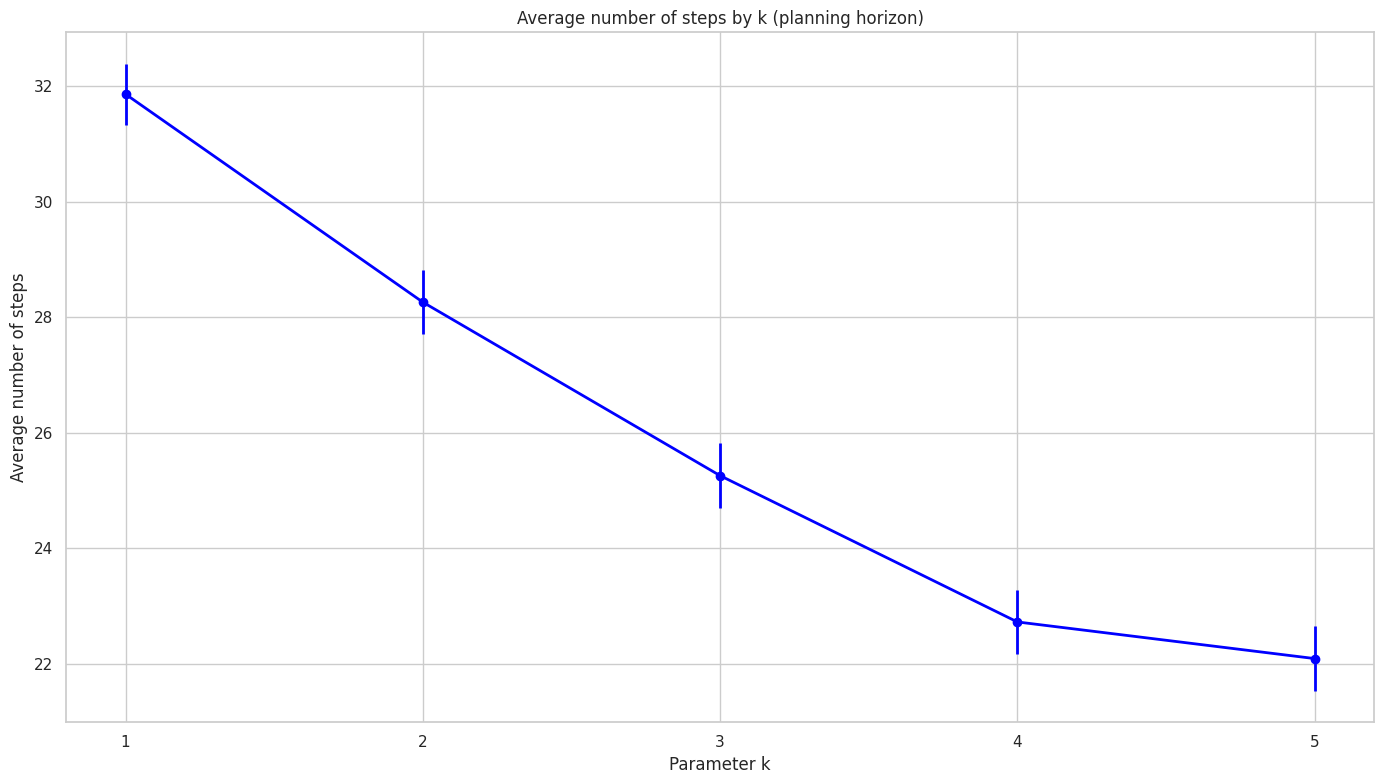

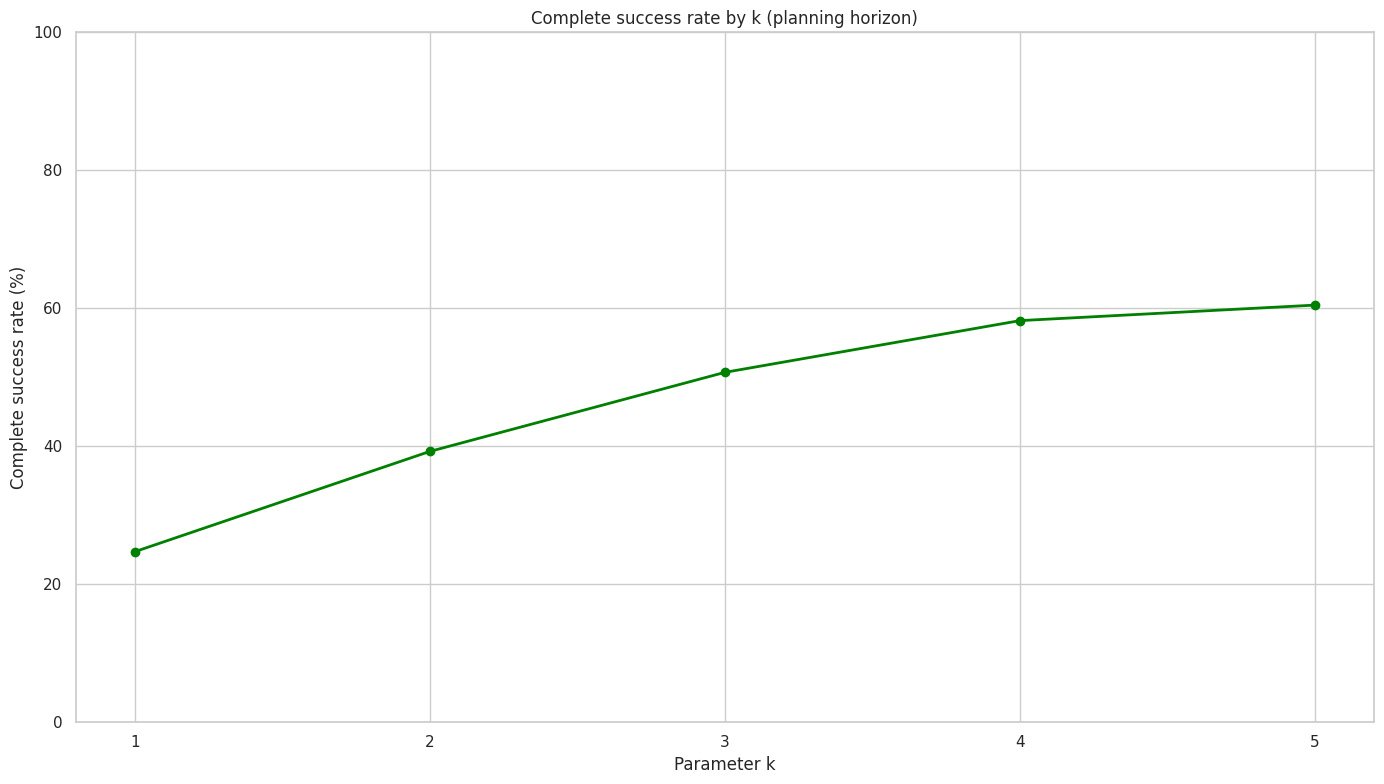

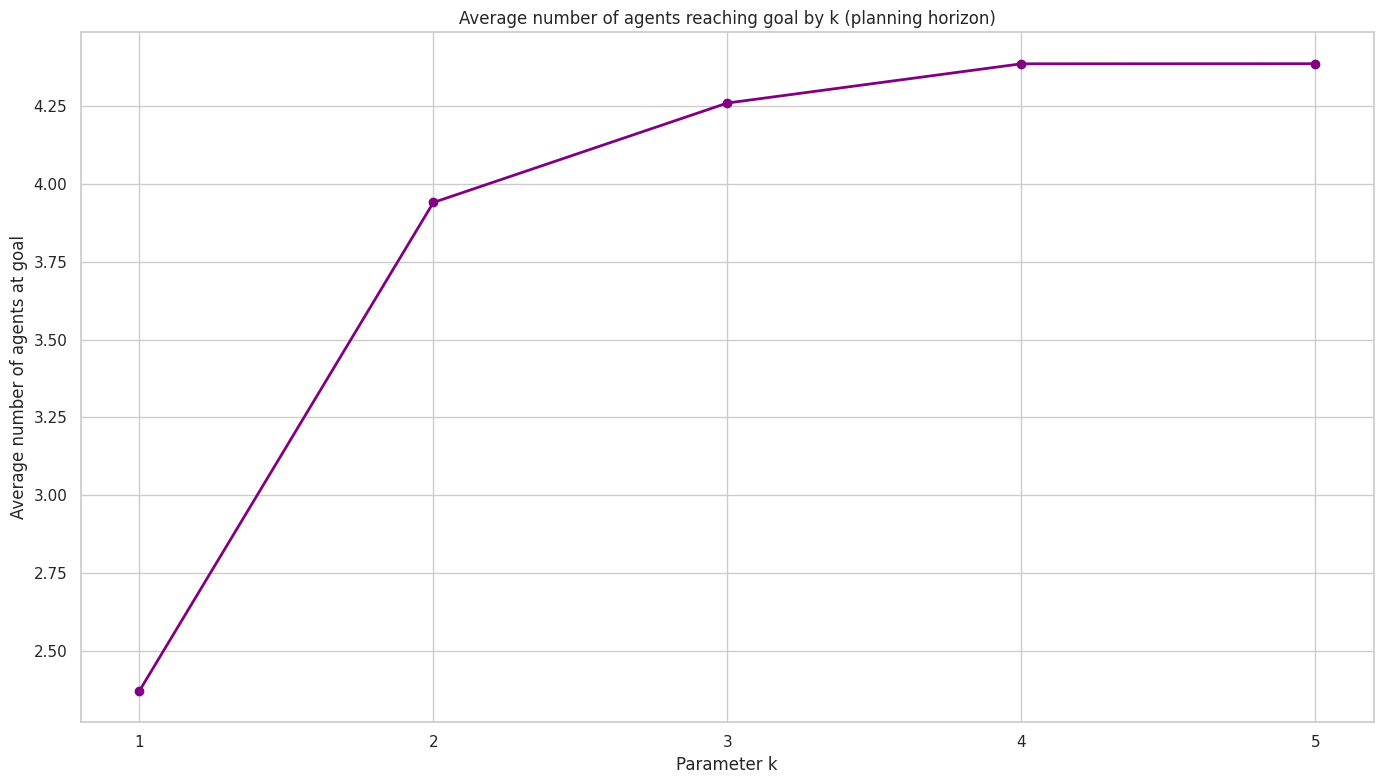

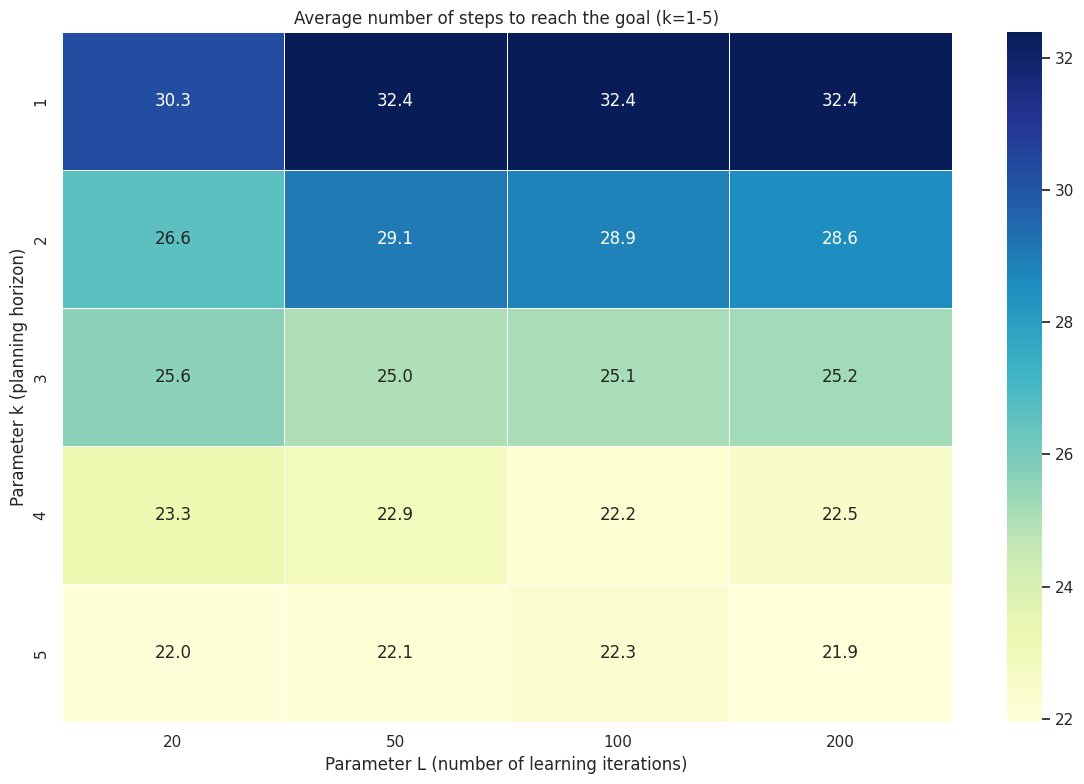

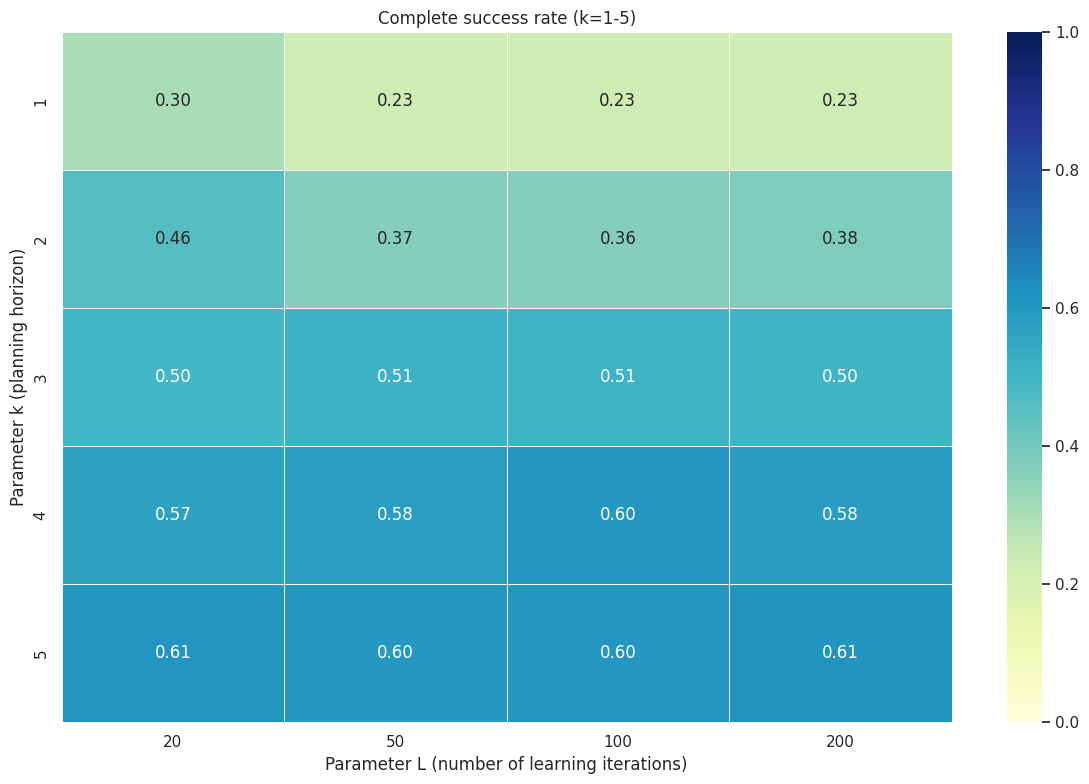

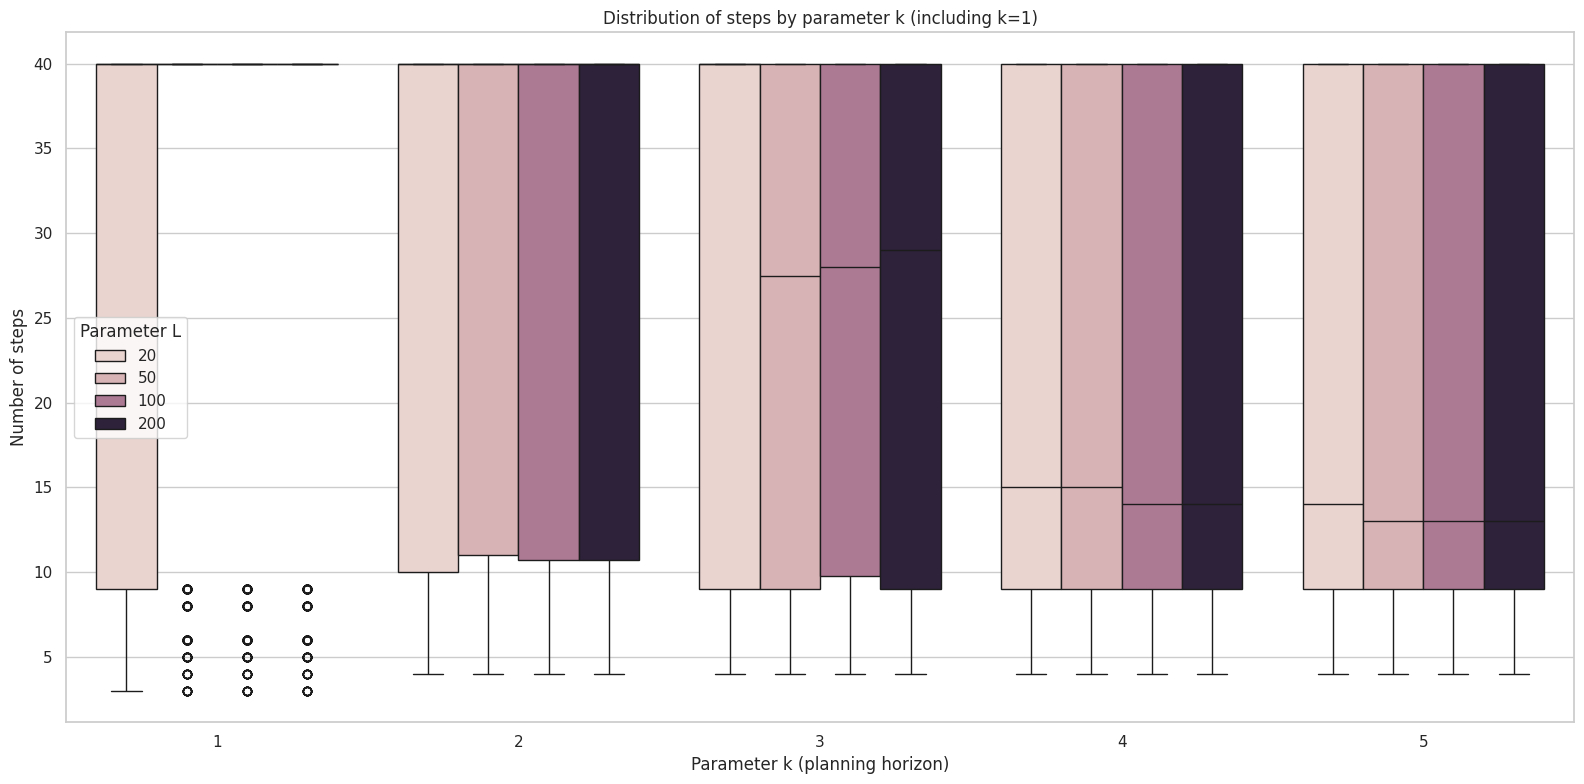

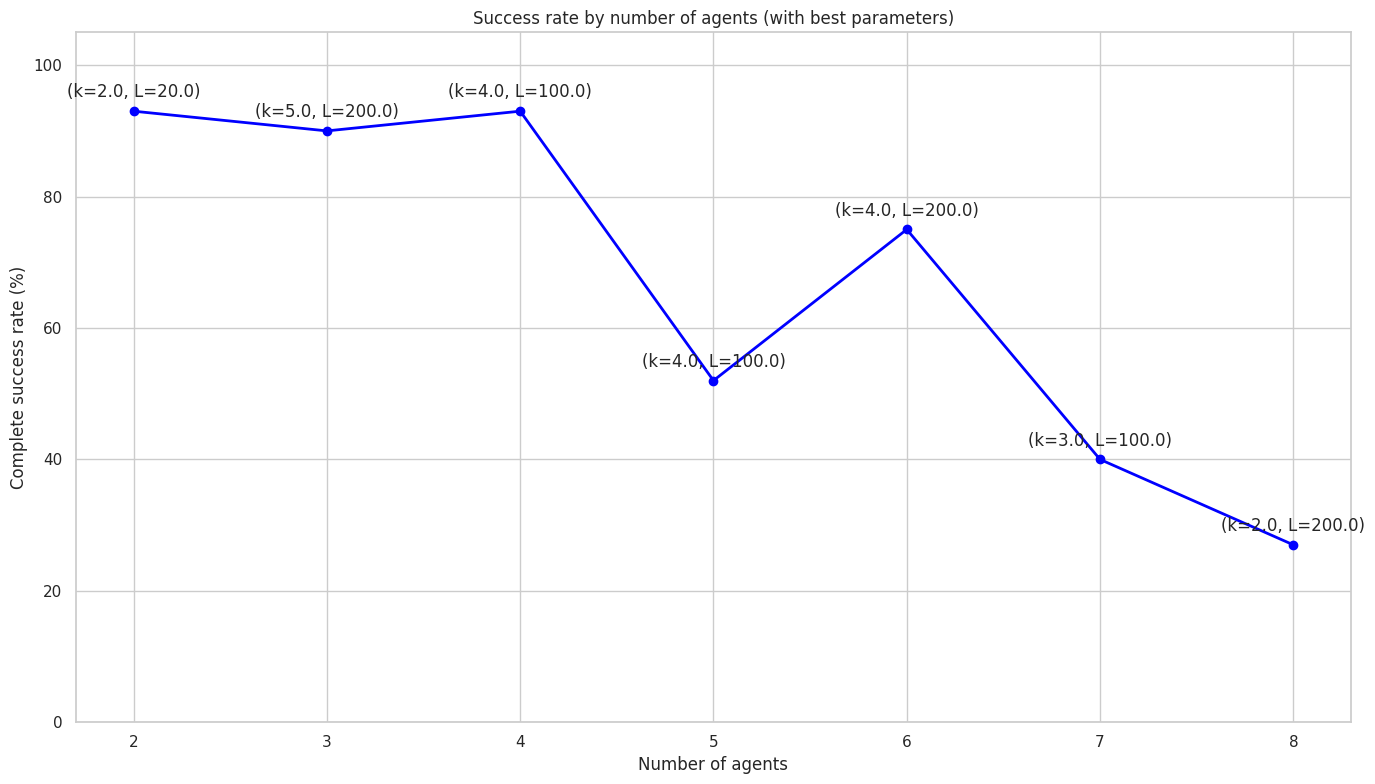

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

def merge_varying_agents_datasets():
    """
    Merges datasets from VaryingAgents and VaryingAgents_k1 folders 
    into a comprehensive dataset for analysis.
    
    Returns:
        pd.DataFrame: Combined dataset with all k values
    """
    # Define paths to the result files
    base_path = os.path.expanduser("~/Desktop/Projet_MARL/Results")
    
    regular_file = os.path.join(base_path, "VaryingAgents", "varying_agents_parameter_study.csv")
    k1_file = os.path.join(base_path, "VaryingAgents_k1", "varying_agents_parameter_study.csv")
    
    # Check if files exist
    if not os.path.exists(regular_file):
        print(f"Error: File not found - {regular_file}")
        return None
    
    if not os.path.exists(k1_file):
        print(f"Error: File not found - {k1_file}")
        return None
    
    # Load the datasets
    print(f"Loading data from {regular_file}")
    df_regular = pd.read_csv(regular_file)
    
    print(f"Loading data from {k1_file}")
    df_k1 = pd.read_csv(k1_file)
    
    # Display basic info about both datasets
    print("\nRegular dataset (k=2,3,4,5):")
    print(f"- Shape: {df_regular.shape}")
    print(f"- k values: {sorted(df_regular['k'].unique())}")
    print(f"- L values: {sorted(df_regular['L'].unique())}")
    print(f"- Number of agents: {sorted(df_regular['num_agents'].unique())}")
    
    print("\nk1 dataset:")
    print(f"- Shape: {df_k1.shape}")
    print(f"- k values: {sorted(df_k1['k'].unique())}")
    print(f"- L values: {sorted(df_k1['L'].unique())}")
    print(f"- Number of agents: {sorted(df_k1['num_agents'].unique())}")
    
    # Merge datasets
    print("\nMerging datasets...")
    df_combined = pd.concat([df_regular, df_k1], ignore_index=True)
    
    # Display info about combined dataset
    print("\nCombined dataset:")
    print(f"- Shape: {df_combined.shape}")
    print(f"- k values: {sorted(df_combined['k'].unique())}")
    print(f"- L values: {sorted(df_combined['L'].unique())}")
    print(f"- Number of agents: {sorted(df_combined['num_agents'].unique())}")
    
    # Create a new results directory for the combined data
    combined_dir = os.path.join(base_path, "VaryingAgents_Combined")
    os.makedirs(combined_dir, exist_ok=True)
    
    # Save the combined dataset
    combined_file = os.path.join(combined_dir, "varying_agents_combined_study.csv")
    df_combined.to_csv(combined_file, index=False)
    print(f"\nCombined dataset saved to: {combined_file}")
    
    return df_combined

def create_combined_plots(df_combined):
    """
    Creates plots from the combined dataset with all k values.
    
    Args:
        df_combined: DataFrame containing the combined results
    """
    # Create figures directory for combined plots
    figures_dir = os.path.expanduser("~/Desktop/Projet_MARL/Figures/VaryingAgents_Combined")
    os.makedirs(figures_dir, exist_ok=True)
    
    # Extract trial count information from the data
    trials_per_position = df_combined.groupby(['num_agents', 'position_set']).size().reset_index()[0].max()
    positions_count = df_combined['position_set'].max() + 1
    
    # Configure plot style
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 12})
    
    # Get sorted unique values for various parameters
    num_agents_values = sorted(df_combined['num_agents'].unique())
    k_values = sorted(df_combined['k'].unique())
    L_values = sorted(df_combined['L'].unique())
    
    # Extended version of steps vs k graph with k=1 included
    plt.figure(figsize=(14, 8))
    
    # Calculate mean and standard deviation by group
    summary_by_k = df_combined.groupby(['k']).agg({
        'steps': [np.mean, np.std, len],
        'success_rate': np.mean,
        'complete_success': np.mean,
        'agents_at_goal': np.mean
    }).reset_index()
    
    # Rename columns for easier access
    summary_by_k.columns = ['k', 'steps_mean', 'steps_std', 'steps_count', 
                           'success_rate_mean', 'complete_success_mean', 'agents_at_goal_mean']
    
    # Add 95% confidence interval
    summary_by_k['ci95'] = 1.96 * summary_by_k['steps_std'] / np.sqrt(summary_by_k['steps_count'])
    
    # Plot steps vs k
    plt.errorbar(
        summary_by_k['k'], summary_by_k['steps_mean'], 
        yerr=summary_by_k['ci95'],
        fmt='o-', linewidth=2, color='blue'
    )
    
    plt.title('Average number of steps by k (planning horizon)')
    plt.xlabel('Parameter k')
    plt.ylabel('Average number of steps')
    plt.grid(True)
    plt.xticks(k_values)
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'steps_vs_k_combined.png'), dpi=300)
    
    # Complete success rate vs k
    plt.figure(figsize=(14, 8))
    plt.plot(summary_by_k['k'], summary_by_k['complete_success_mean'] * 100, 'o-', linewidth=2, color='green')
    plt.title('Complete success rate by k (planning horizon)')
    plt.xlabel('Parameter k')
    plt.ylabel('Complete success rate (%)')
    plt.ylim(0, 100)
    plt.grid(True)
    plt.xticks(k_values)
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'success_rate_vs_k_combined.png'), dpi=300)
    
    # Agents at goal vs k
    plt.figure(figsize=(14, 8))
    plt.plot(summary_by_k['k'], summary_by_k['agents_at_goal_mean'], 'o-', linewidth=2, color='purple')
    plt.title('Average number of agents reaching goal by k (planning horizon)')
    plt.xlabel('Parameter k')
    plt.ylabel('Average number of agents at goal')
    plt.grid(True)
    plt.xticks(k_values)
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'agents_at_goal_vs_k_combined.png'), dpi=300)
    
    # Heatmap of average steps with k=1 included
    plt.figure(figsize=(12, 8))
    
    # Create a pivot table for the heatmap
    heatmap_data = df_combined.pivot_table(
        values='steps', 
        index='k', 
        columns='L', 
        aggfunc='mean'
    )
    
    # Plot the heatmap
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=.5)
    plt.title('Average number of steps to reach the goal (k=1-5)')
    plt.xlabel('Parameter L (number of learning iterations)')
    plt.ylabel('Parameter k (planning horizon)')
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'steps_heatmap_combined.png'), dpi=300)
    
    # Heatmap of success rate with k=1 included
    plt.figure(figsize=(12, 8))
    
    # Create a pivot table for the success rate heatmap
    success_heatmap = df_combined.pivot_table(
        values='complete_success',
        index='k', 
        columns='L', 
        aggfunc='mean'
    )
    
    # Plot the heatmap
    sns.heatmap(success_heatmap, annot=True, cmap="YlGnBu", vmin=0, vmax=1, fmt=".2f", linewidths=.5)
    plt.title('Complete success rate (k=1-5)')
    plt.xlabel('Parameter L (number of learning iterations)')
    plt.ylabel('Parameter k (planning horizon)')
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'success_rate_heatmap_combined.png'), dpi=300)
    
    # Boxplots showing distribution of steps by k (including k=1)
    plt.figure(figsize=(16, 8))
    sns.boxplot(x='k', y='steps', hue='L', data=df_combined)
    plt.title('Distribution of steps by parameter k (including k=1)')
    plt.xlabel('Parameter k (planning horizon)')
    plt.ylabel('Number of steps')
    plt.legend(title='Parameter L')
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'steps_boxplot_by_k_combined.png'), dpi=300)
    
    # Best parameters for each number of agents (including k=1)
    best_params = []
    for num_agents in num_agents_values:
        agent_data = df_combined[df_combined['num_agents'] == num_agents]
        summary = agent_data.groupby(['k', 'L']).agg({
            'steps': 'mean',
            'complete_success': 'mean',
            'agents_at_goal': 'mean'
        }).reset_index()
        
        # Best parameters for maximizing success rate
        best_row = summary.sort_values(['complete_success', 'agents_at_goal', 'steps'], 
                                     ascending=[False, False, True]).iloc[0]
        
        best_params.append({
            'num_agents': num_agents,
            'best_k': best_row['k'],
            'best_L': best_row['L'],
            'avg_steps': best_row['steps'],
            'complete_success': best_row['complete_success'],
            'avg_agents_at_goal': best_row['agents_at_goal']
        })
    
    # Create a DataFrame with best parameters
    best_params_df = pd.DataFrame(best_params)
    best_params_path = os.path.join(figures_dir, "best_parameters_combined.csv")
    best_params_df.to_csv(best_params_path, index=False)
    
    # Plot success rate with best parameters
    plt.figure(figsize=(14, 8))
    plt.plot(best_params_df['num_agents'], best_params_df['complete_success'] * 100, 
             'o-', linewidth=2, color='blue')
    
    for i, row in best_params_df.iterrows():
        plt.annotate(f"(k={row['best_k']}, L={row['best_L']})",
                    (row['num_agents'], row['complete_success'] * 100),
                    textcoords="offset points", 
                    xytext=(0, 10), 
                    ha='center')
    
    plt.title('Success rate by number of agents (with best parameters)')
    plt.xlabel('Number of agents')
    plt.ylabel('Complete success rate (%)')
    plt.ylim(0, 105)
    plt.xticks(num_agents_values)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir, 'success_rate_vs_agents_best_params.png'), dpi=300)
    
    print(f"Combined plots saved to: {figures_dir}")

# Run the main functions
if __name__ == "__main__":
    df_combined = merge_varying_agents_datasets()
    if df_combined is not None:
        create_combined_plots(df_combined)

Success rate plot saved to: /home/yacine/Desktop/Projet_MARL/Figures/PerformanceAnalysis/percentage_agents_by_L_for_k.png
Steps plot saved to: /home/yacine/Desktop/Projet_MARL/Figures/PerformanceAnalysis/average_steps_by_L_for_k.png
Comparative heatmaps saved to: /home/yacine/Desktop/Projet_MARL/Figures/PerformanceAnalysis/comparative_heatmaps.png
Analysis complete!


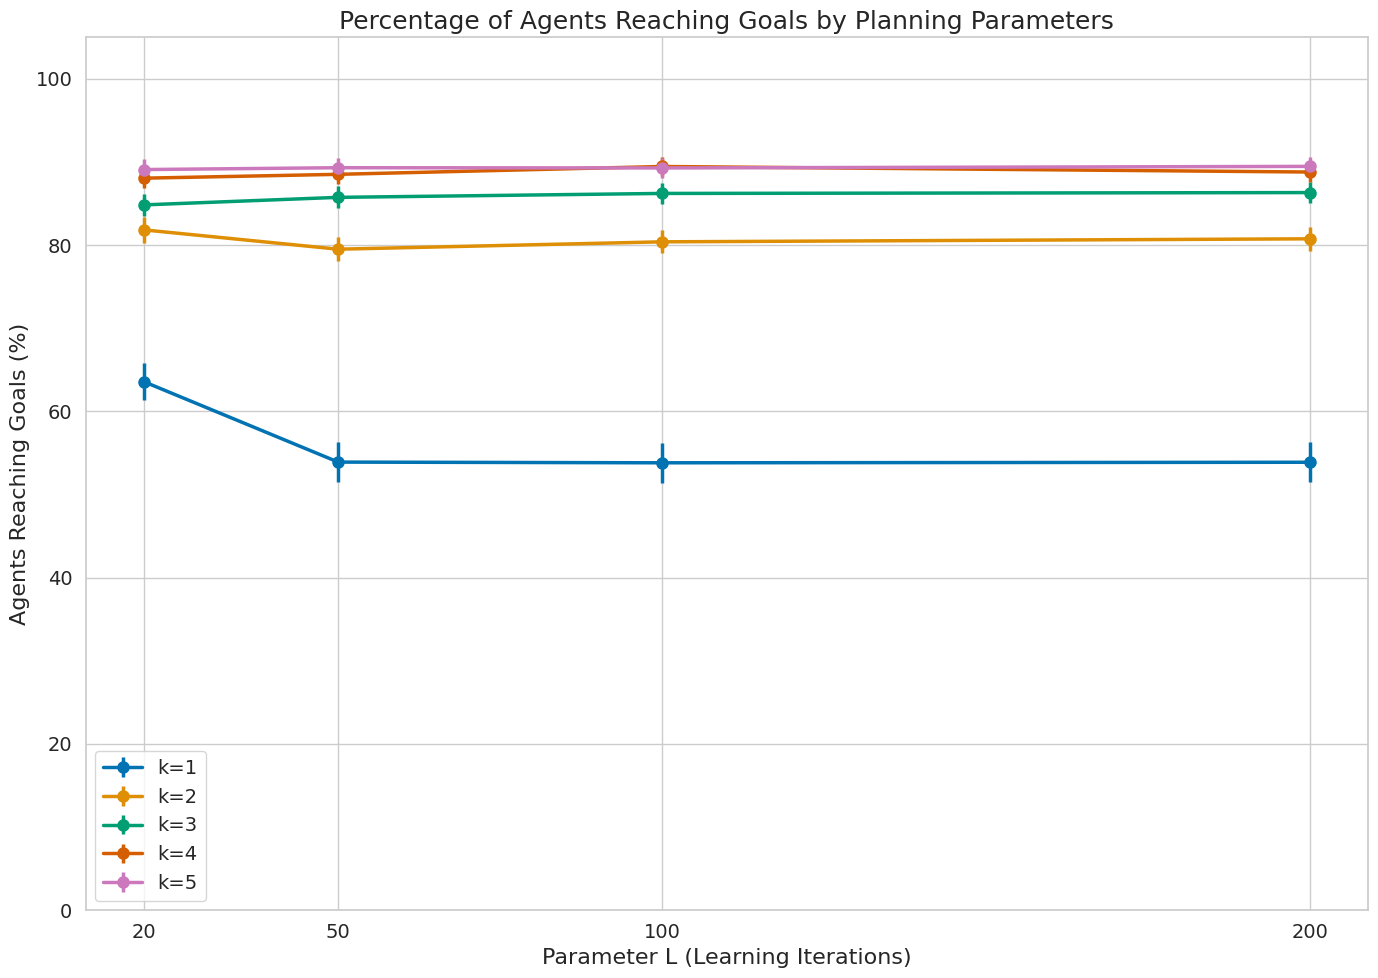

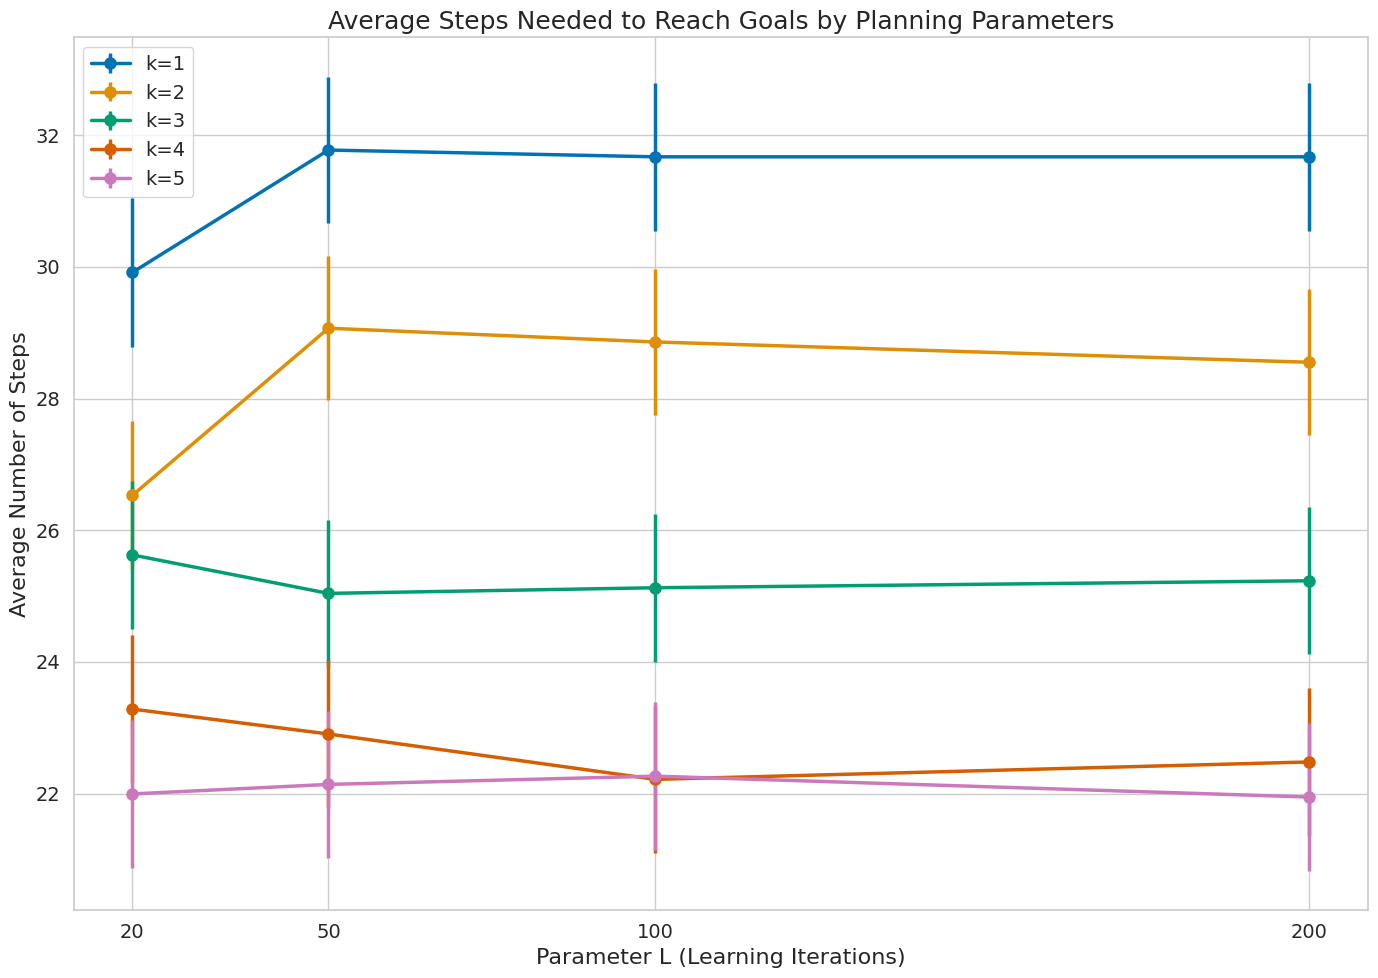

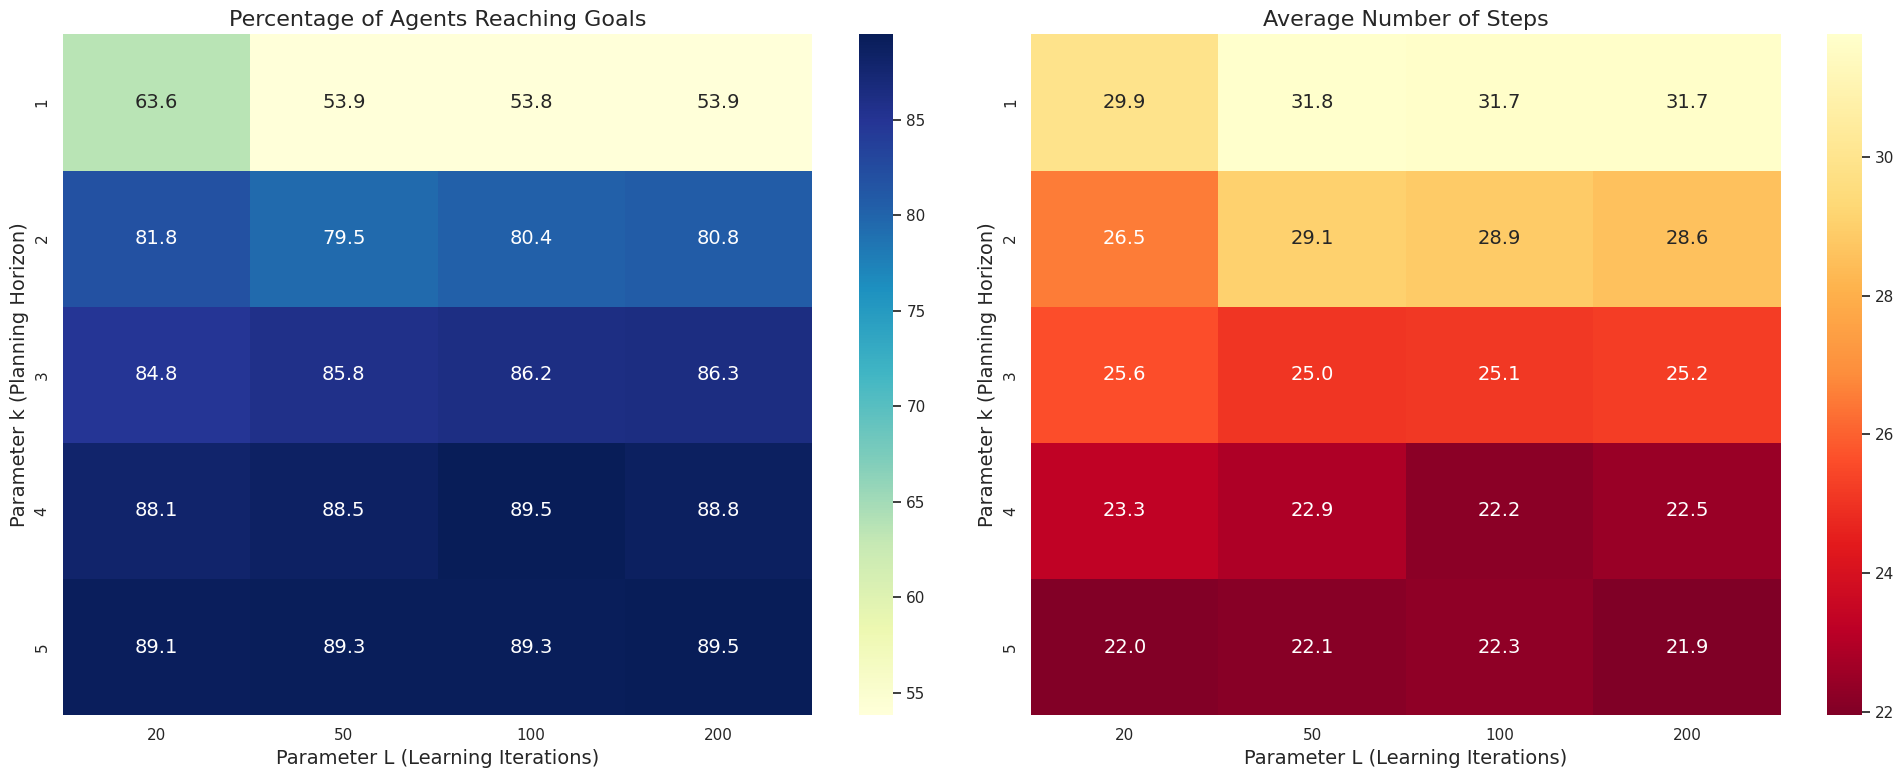

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_combined_performance_plots():
    """
    Creates plots showing the percentage of agents reaching goals and steps taken
    as functions of L for different k values, independent of the total number of agents.
    """
    # Define paths to the result files
    base_path = os.path.expanduser("~/Desktop/Projet_MARL/Results")
    
    # Try to find the combined dataset first
    combined_file = os.path.join(base_path, "VaryingAgents_Combined", "varying_agents_combined_study.csv")
    
    # If the combined file doesn't exist, merge the data from separate files
    if not os.path.exists(combined_file):
        print("Combined dataset not found. Looking for individual datasets...")
        regular_file = os.path.join(base_path, "VaryingAgents", "varying_agents_parameter_study.csv")
        k1_file = os.path.join(base_path, "VaryingAgents_k1", "varying_agents_parameter_study.csv")
        
        if not os.path.exists(regular_file):
            print(f"Error: Regular dataset file not found - {regular_file}")
            return None
        
        if not os.path.exists(k1_file):
            print(f"Warning: k1 dataset file not found - {k1_file}")
            print("Proceeding with only the regular dataset.")
            df_combined = pd.read_csv(regular_file)
        else:
            # Merge the datasets
            df_regular = pd.read_csv(regular_file)
            df_k1 = pd.read_csv(k1_file)
            df_combined = pd.concat([df_regular, df_k1], ignore_index=True)
    else:
        # Load the combined dataset
        df_combined = pd.read_csv(combined_file)
    
    # Create figures directory for the new plots
    figures_dir = os.path.expanduser("~/Desktop/Projet_MARL/Figures/PerformanceAnalysis")
    os.makedirs(figures_dir, exist_ok=True)
    
    # Configure plot style
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 14})
    
    # Get sorted unique k and L values
    k_values = sorted(df_combined['k'].unique())
    L_values = sorted(df_combined['L'].unique())
    
    # Create color palette for k values (using a colorblind-friendly palette)
    colors = sns.color_palette("colorblind", n_colors=len(k_values))
    
    # 1. Plot percentage of agents reaching goals as a function of L for each k
    plt.figure(figsize=(14, 10))
    
    # We need to calculate success rate for each k-L combination
    # This is independent of the number of agents
    success_by_kl = df_combined.groupby(['k', 'L']).agg({
        'success_rate': ['mean', 'std', 'count'],
    }).reset_index()
    
    success_by_kl.columns = ['k', 'L', 'success_rate_mean', 'success_rate_std', 'sample_count']
    
    # Convert to percentage
    success_by_kl['success_percentage'] = success_by_kl['success_rate_mean'] * 100
    
    # Calculate 95% confidence interval
    success_by_kl['ci95'] = 1.96 * success_by_kl['success_rate_std'] / np.sqrt(success_by_kl['sample_count'])
    success_by_kl['ci95_percentage'] = success_by_kl['ci95'] * 100
    
    # Plot a line for each k value
    for i, k in enumerate(k_values):
        k_data = success_by_kl[success_by_kl['k'] == k]
        if not k_data.empty:
            plt.errorbar(
                k_data['L'], 
                k_data['success_percentage'], 
                yerr=k_data['ci95_percentage'],
                marker='o', 
                markersize=8, 
                linewidth=2.5, 
                color=colors[i],
                label=f'k={k}'
            )
    
    plt.title('Percentage of Agents Reaching Goals by Planning Parameters', fontsize=18)
    plt.xlabel('Parameter L (Learning Iterations)', fontsize=16)
    plt.ylabel('Agents Reaching Goals (%)', fontsize=16)
    plt.xticks(L_values, fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 105)
    plt.grid(True)
    plt.legend(fontsize=14)
    plt.tight_layout()
    
    # Save the plot
    success_plot_path = os.path.join(figures_dir, 'percentage_agents_by_L_for_k.png')
    plt.savefig(success_plot_path, dpi=300)
    print(f"Success rate plot saved to: {success_plot_path}")
    
    # 2. Plot average steps as a function of L for each k
    plt.figure(figsize=(14, 10))
    
    # Calculate average steps for each k-L combination
    # Only consider cases where at least some agents reached their goals
    steps_by_kl = df_combined[df_combined['agents_at_goal'] > 0].groupby(['k', 'L']).agg({
        'steps': ['mean', 'std', 'count'],
    }).reset_index()
    
    steps_by_kl.columns = ['k', 'L', 'steps_mean', 'steps_std', 'sample_count']
    
    # Calculate 95% confidence interval
    steps_by_kl['ci95'] = 1.96 * steps_by_kl['steps_std'] / np.sqrt(steps_by_kl['sample_count'])
    
    # Plot a line for each k value
    for i, k in enumerate(k_values):
        k_data = steps_by_kl[steps_by_kl['k'] == k]
        if not k_data.empty:
            plt.errorbar(
                k_data['L'], 
                k_data['steps_mean'], 
                yerr=k_data['ci95'],
                marker='o', 
                markersize=8, 
                linewidth=2.5,
                color=colors[i],
                label=f'k={k}'
            )
    
    plt.title('Average Steps Needed to Reach Goals by Planning Parameters', fontsize=18)
    plt.xlabel('Parameter L (Learning Iterations)', fontsize=16)
    plt.ylabel('Average Number of Steps', fontsize=16)
    plt.xticks(L_values, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=14)
    plt.tight_layout()
    
    # Save the plot
    steps_plot_path = os.path.join(figures_dir, 'average_steps_by_L_for_k.png')
    plt.savefig(steps_plot_path, dpi=300)
    print(f"Steps plot saved to: {steps_plot_path}")
    
    # 3. Create a comparative heatmap showing both metrics side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Create pivot tables for heatmaps
    success_pivot = success_by_kl.pivot_table(
        values='success_percentage', 
        index='k', 
        columns='L'
    )
    
    steps_pivot = steps_by_kl.pivot_table(
        values='steps_mean', 
        index='k', 
        columns='L'
    )
    
    # Plot heatmaps
    sns.heatmap(success_pivot, annot=True, cmap="YlGnBu", fmt=".1f", ax=ax1)
    ax1.set_title('Percentage of Agents Reaching Goals', fontsize=16)
    ax1.set_xlabel('Parameter L (Learning Iterations)', fontsize=14)
    ax1.set_ylabel('Parameter k (Planning Horizon)', fontsize=14)
    
    sns.heatmap(steps_pivot, annot=True, cmap="YlOrRd_r", fmt=".1f", ax=ax2)
    ax2.set_title('Average Number of Steps', fontsize=16)
    ax2.set_xlabel('Parameter L (Learning Iterations)', fontsize=14)
    ax2.set_ylabel('Parameter k (Planning Horizon)', fontsize=14)
    
    plt.tight_layout()
    
    # Save the comparative plot
    comparative_plot_path = os.path.join(figures_dir, 'comparative_heatmaps.png')
    plt.savefig(comparative_plot_path, dpi=300)
    print(f"Comparative heatmaps saved to: {comparative_plot_path}")
    
    # Return the merged dataframe for possible further analysis
    return df_combined

if __name__ == "__main__":
    df_combined = create_combined_performance_plots()
    print("Analysis complete!")

Success rate plot saved to: /home/yacine/Desktop/Projet_MARL/Figures/ParameterPerformance/percentage_agents_by_L_for_k.png
Median steps plot saved to: /home/yacine/Desktop/Projet_MARL/Figures/ParameterPerformance/median_steps_by_L_for_k.png
Comparative heatmaps saved to: /home/yacine/Desktop/Projet_MARL/Figures/ParameterPerformance/comparative_heatmaps_median.png
Analysis complete!


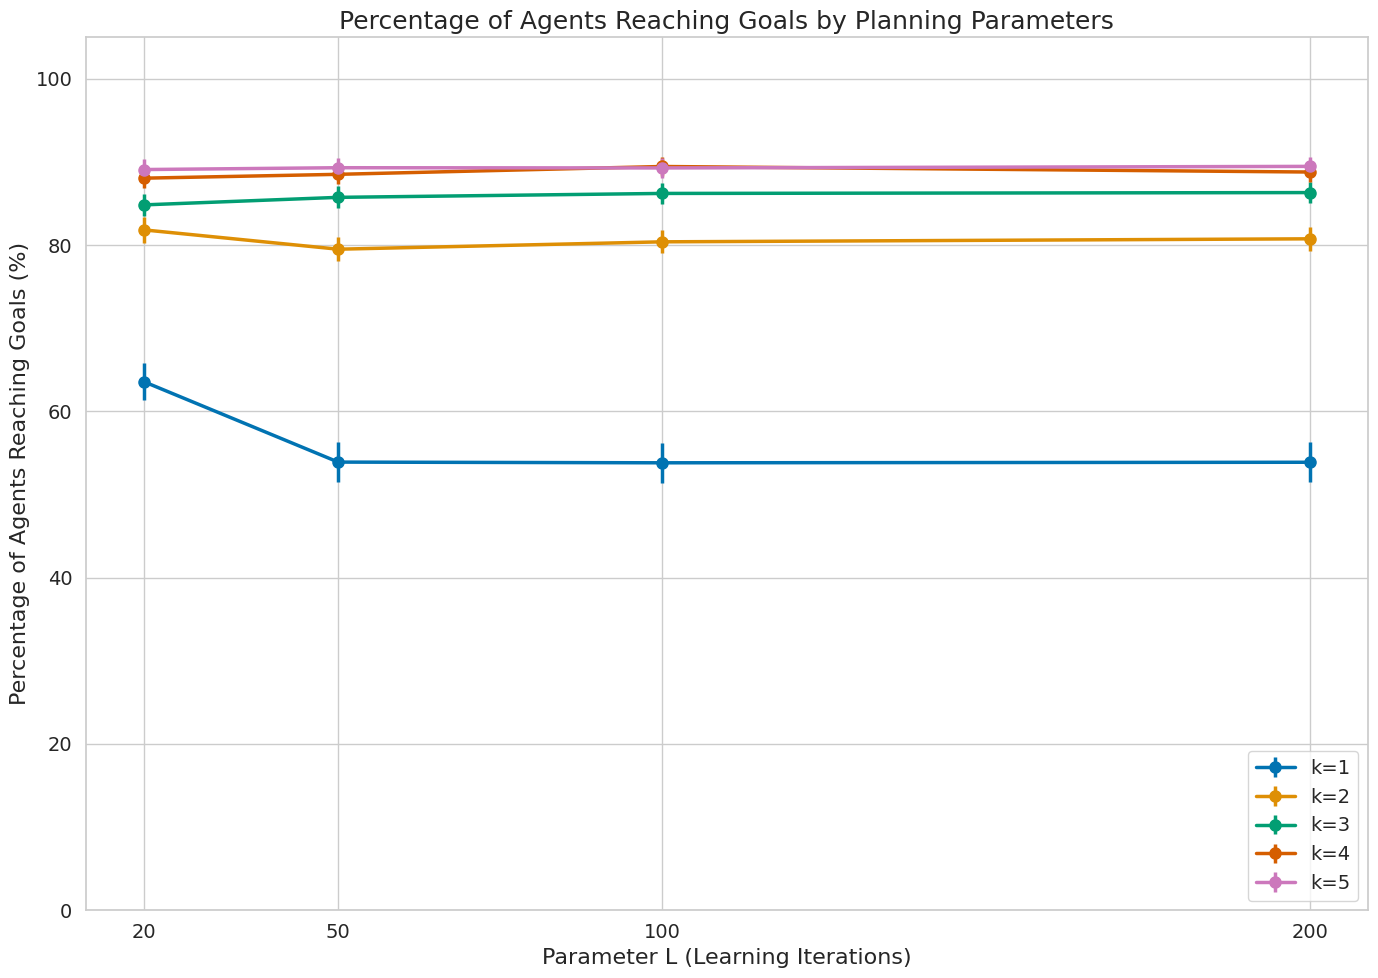

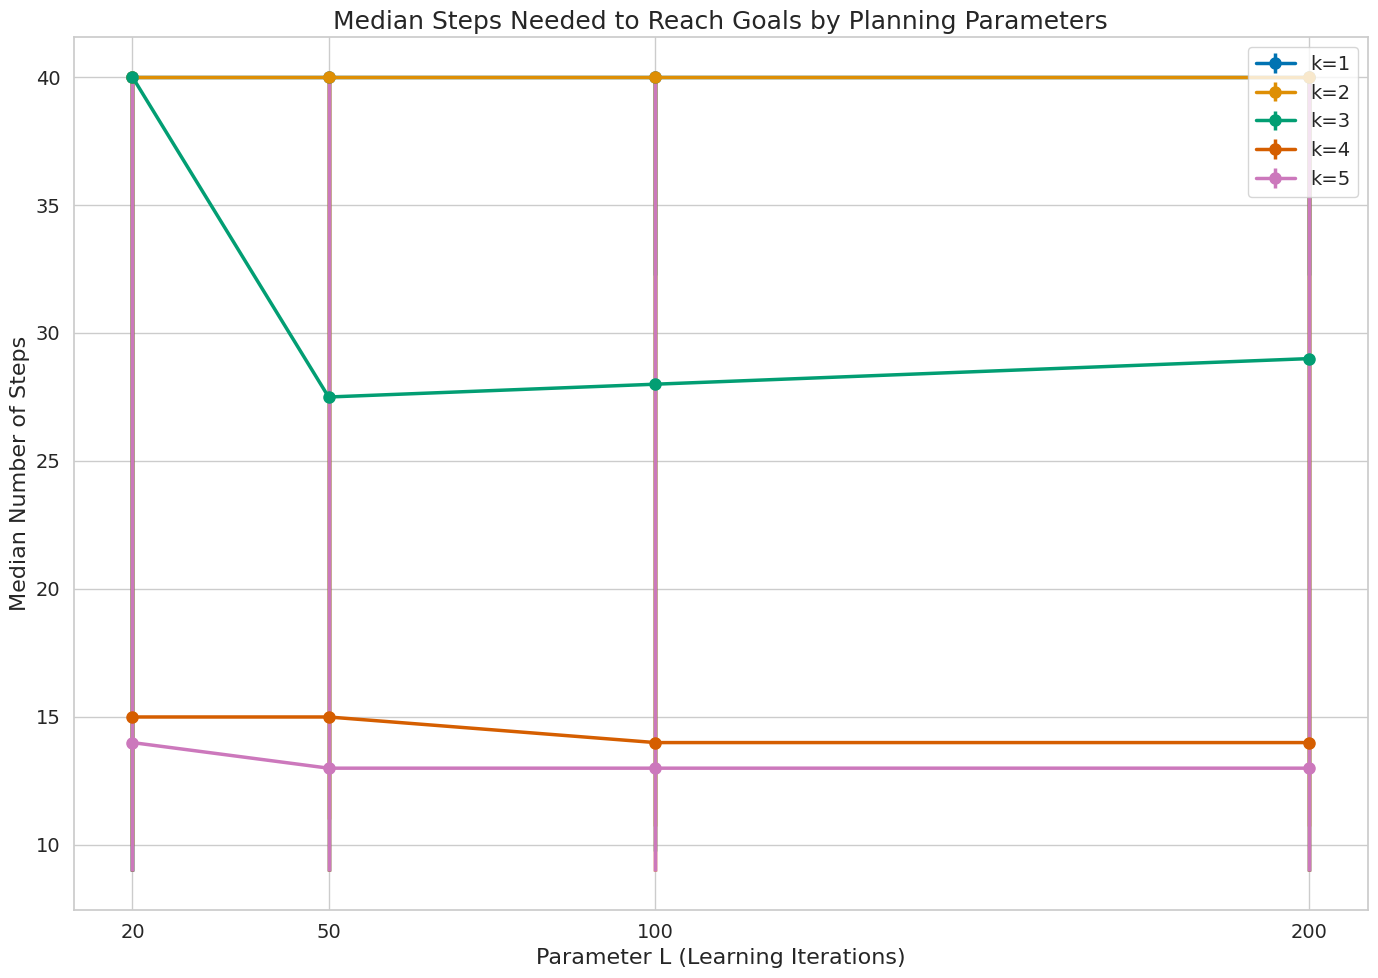

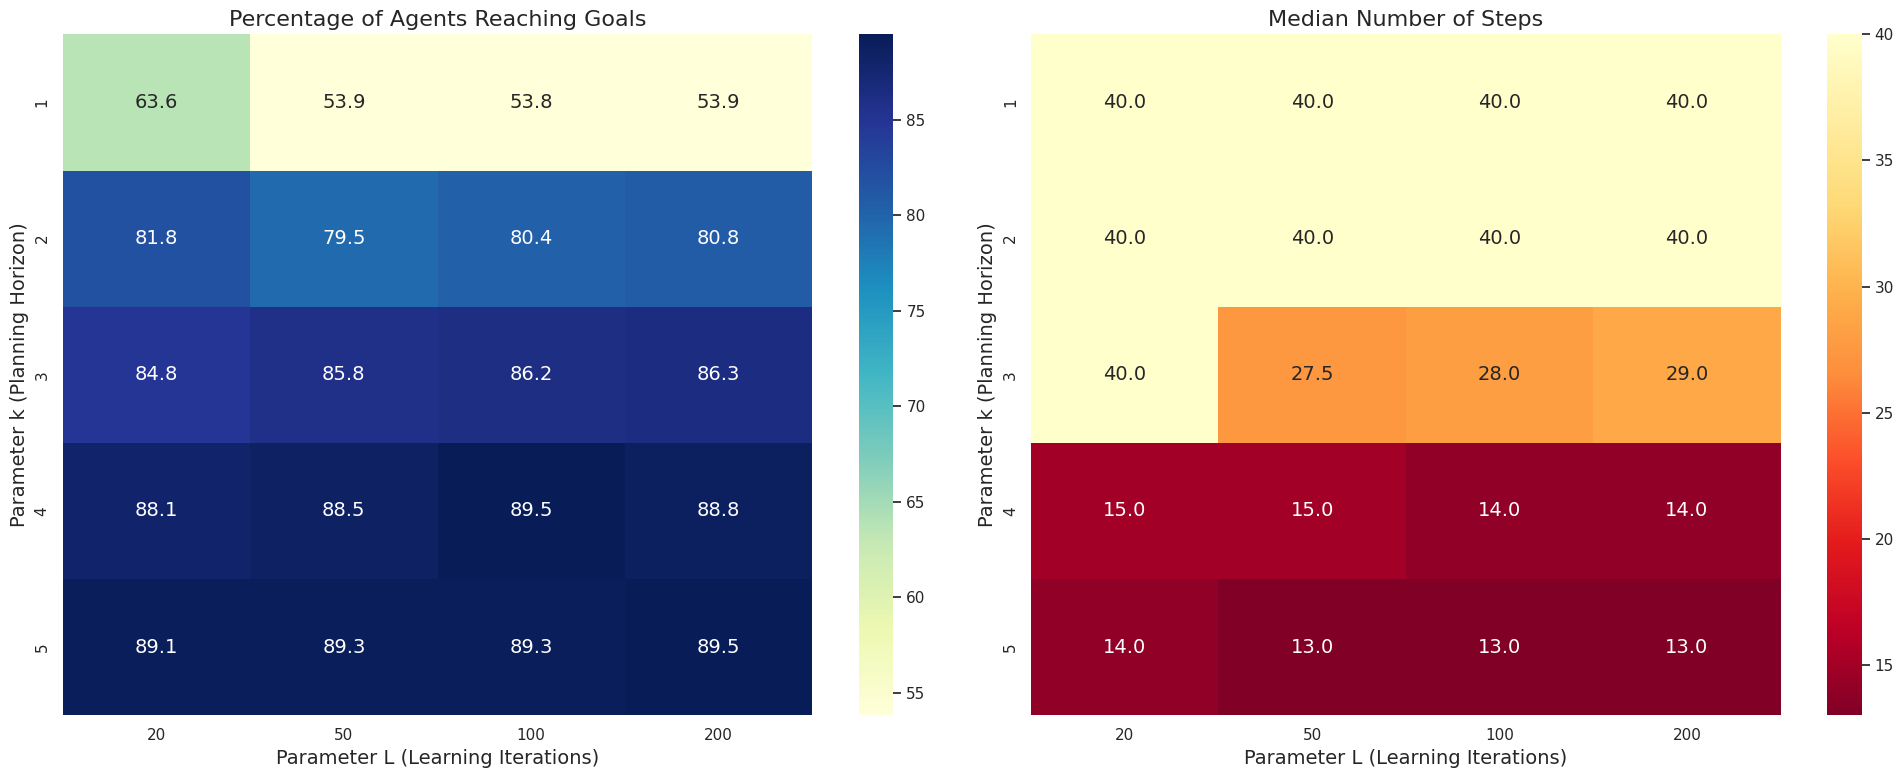

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_parameter_performance_plots():
    """
    Creates plots showing median steps and percentage of agents reaching goals
    as functions of L for each k value, independent of the number of agents.
    """
    # Define paths to the result files
    base_path = os.path.expanduser("~/Desktop/Projet_MARL/Results")
    
    # Try to find the combined dataset first
    combined_file = os.path.join(base_path, "VaryingAgents_Combined", "varying_agents_combined_study.csv")
    
    # If the combined file doesn't exist, merge the data from separate files
    if not os.path.exists(combined_file):
        print("Combined dataset not found. Looking for individual datasets...")
        regular_file = os.path.join(base_path, "VaryingAgents", "varying_agents_parameter_study.csv")
        k1_file = os.path.join(base_path, "VaryingAgents_k1", "varying_agents_parameter_study.csv")
        
        if not os.path.exists(regular_file):
            print(f"Error: Regular dataset file not found - {regular_file}")
            return None
        
        if not os.path.exists(k1_file):
            print(f"Warning: k1 dataset file not found - {k1_file}")
            print("Proceeding with only the regular dataset.")
            df_combined = pd.read_csv(regular_file)
        else:
            # Merge the datasets
            df_regular = pd.read_csv(regular_file)
            df_k1 = pd.read_csv(k1_file)
            df_combined = pd.concat([df_regular, df_k1], ignore_index=True)
    else:
        # Load the combined dataset
        df_combined = pd.read_csv(combined_file)
    
    # Create figures directory for the new plots
    figures_dir = os.path.expanduser("~/Desktop/Projet_MARL/Figures/ParameterPerformance")
    os.makedirs(figures_dir, exist_ok=True)
    
    # Configure plot style
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 14})
    
    # Get sorted unique k and L values
    k_values = sorted(df_combined['k'].unique())
    L_values = sorted(df_combined['L'].unique())
    
    # Create color palette for k values (using a colorblind-friendly palette)
    colors = sns.color_palette("colorblind", n_colors=len(k_values))
    
    # 1. Plot percentage of agents reaching goals as a function of L for each k
    plt.figure(figsize=(14, 10))
    
    # Calculate success rate for each k-L combination, independent of agent count
    success_by_kl = df_combined.groupby(['k', 'L']).agg({
        'success_rate': ['mean', 'std', 'count'],
    }).reset_index()
    
    success_by_kl.columns = ['k', 'L', 'success_rate_mean', 'success_rate_std', 'sample_count']
    
    # Convert to percentage
    success_by_kl['success_percentage'] = success_by_kl['success_rate_mean'] * 100
    
    # Calculate 95% confidence interval
    success_by_kl['ci95'] = 1.96 * success_by_kl['success_rate_std'] / np.sqrt(success_by_kl['sample_count'])
    success_by_kl['ci95_percentage'] = success_by_kl['ci95'] * 100
    
    # Plot a line for each k value
    for i, k in enumerate(k_values):
        k_data = success_by_kl[success_by_kl['k'] == k]
        if not k_data.empty:
            plt.errorbar(
                k_data['L'], 
                k_data['success_percentage'], 
                yerr=k_data['ci95_percentage'],
                marker='o', 
                markersize=8, 
                linewidth=2.5, 
                color=colors[i],
                label=f'k={k}'
            )
    
    plt.title('Percentage of Agents Reaching Goals by Planning Parameters', fontsize=18)
    plt.xlabel('Parameter L (Learning Iterations)', fontsize=16)
    plt.ylabel('Percentage of Agents Reaching Goals (%)', fontsize=16)
    plt.xticks(L_values, fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 105)
    plt.grid(True)
    plt.legend(fontsize=14, loc='lower right')
    plt.tight_layout()
    
    # Save the plot
    success_plot_path = os.path.join(figures_dir, 'percentage_agents_by_L_for_k.png')
    plt.savefig(success_plot_path, dpi=300)
    print(f"Success rate plot saved to: {success_plot_path}")
    
    # 2. Plot MEDIAN steps as a function of L for each k
    plt.figure(figsize=(14, 10))
    
    # Only consider cases where at least some agents reached their goals
    steps_data = df_combined[df_combined['agents_at_goal'] > 0]
    
    # Calculate median steps for each k-L combination
    median_steps_by_kl = steps_data.groupby(['k', 'L'])['steps'].median().reset_index()
    
    # Calculate 25th and 75th percentiles for error bars (IQR)
    q1_steps_by_kl = steps_data.groupby(['k', 'L'])['steps'].quantile(0.25).reset_index()
    q1_steps_by_kl.columns = ['k', 'L', 'q1']
    
    q3_steps_by_kl = steps_data.groupby(['k', 'L'])['steps'].quantile(0.75).reset_index()
    q3_steps_by_kl.columns = ['k', 'L', 'q3']
    
    # Merge percentiles with median data
    median_steps_by_kl = pd.merge(median_steps_by_kl, q1_steps_by_kl, on=['k', 'L'])
    median_steps_by_kl = pd.merge(median_steps_by_kl, q3_steps_by_kl, on=['k', 'L'])
    
    # Calculate IQR for error bars
    median_steps_by_kl['lower_err'] = median_steps_by_kl['steps'] - median_steps_by_kl['q1']
    median_steps_by_kl['upper_err'] = median_steps_by_kl['q3'] - median_steps_by_kl['steps']
    
    # Plot a line for each k value
    for i, k in enumerate(k_values):
        k_data = median_steps_by_kl[median_steps_by_kl['k'] == k]
        if not k_data.empty:
            plt.errorbar(
                k_data['L'], 
                k_data['steps'], 
                yerr=[k_data['lower_err'], k_data['upper_err']],
                marker='o', 
                markersize=8, 
                linewidth=2.5,
                color=colors[i],
                label=f'k={k}'
            )
    
    plt.title('Median Steps Needed to Reach Goals by Planning Parameters', fontsize=18)
    plt.xlabel('Parameter L (Learning Iterations)', fontsize=16)
    plt.ylabel('Median Number of Steps', fontsize=16)
    plt.xticks(L_values, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=14, loc='upper right')
    plt.tight_layout()
    
    # Save the plot
    median_steps_plot_path = os.path.join(figures_dir, 'median_steps_by_L_for_k.png')
    plt.savefig(median_steps_plot_path, dpi=300)
    print(f"Median steps plot saved to: {median_steps_plot_path}")
    
    # 3. Create a comparative heatmap showing both metrics side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Create pivot tables for heatmaps
    success_pivot = success_by_kl.pivot_table(
        values='success_percentage', 
        index='k', 
        columns='L'
    )
    
    median_steps_pivot = median_steps_by_kl.pivot_table(
        values='steps', 
        index='k', 
        columns='L'
    )
    
    # Plot heatmaps
    sns.heatmap(success_pivot, annot=True, cmap="YlGnBu", fmt=".1f", ax=ax1)
    ax1.set_title('Percentage of Agents Reaching Goals', fontsize=16)
    ax1.set_xlabel('Parameter L (Learning Iterations)', fontsize=14)
    ax1.set_ylabel('Parameter k (Planning Horizon)', fontsize=14)
    
    sns.heatmap(median_steps_pivot, annot=True, cmap="YlOrRd_r", fmt=".1f", ax=ax2)
    ax2.set_title('Median Number of Steps', fontsize=16)
    ax2.set_xlabel('Parameter L (Learning Iterations)', fontsize=14)
    ax2.set_ylabel('Parameter k (Planning Horizon)', fontsize=14)
    
    plt.tight_layout()
    
    # Save the comparative plot
    comparative_plot_path = os.path.join(figures_dir, 'comparative_heatmaps_median.png')
    plt.savefig(comparative_plot_path, dpi=300)
    print(f"Comparative heatmaps saved to: {comparative_plot_path}")
    
    return df_combined

if __name__ == "__main__":
    df_combined = create_parameter_performance_plots()
    print("Analysis complete!")

Success rate plot for 2 agents saved to: /home/yacine/Desktop/Projet_MARL/Figures/PerformanceAnalysis_ByAgentCount/percentage_agents_by_L_for_k_2agents.png
Steps plot for 2 agents saved to: /home/yacine/Desktop/Projet_MARL/Figures/PerformanceAnalysis_ByAgentCount/average_steps_by_L_for_k_2agents.png
Comparative heatmaps for 2 agents saved to: /home/yacine/Desktop/Projet_MARL/Figures/PerformanceAnalysis_ByAgentCount/comparative_heatmaps_2agents.png
Success rate plot for 3 agents saved to: /home/yacine/Desktop/Projet_MARL/Figures/PerformanceAnalysis_ByAgentCount/percentage_agents_by_L_for_k_3agents.png
Steps plot for 3 agents saved to: /home/yacine/Desktop/Projet_MARL/Figures/PerformanceAnalysis_ByAgentCount/average_steps_by_L_for_k_3agents.png
Comparative heatmaps for 3 agents saved to: /home/yacine/Desktop/Projet_MARL/Figures/PerformanceAnalysis_ByAgentCount/comparative_heatmaps_3agents.png
Success rate plot for 4 agents saved to: /home/yacine/Desktop/Projet_MARL/Figures/PerformanceAna

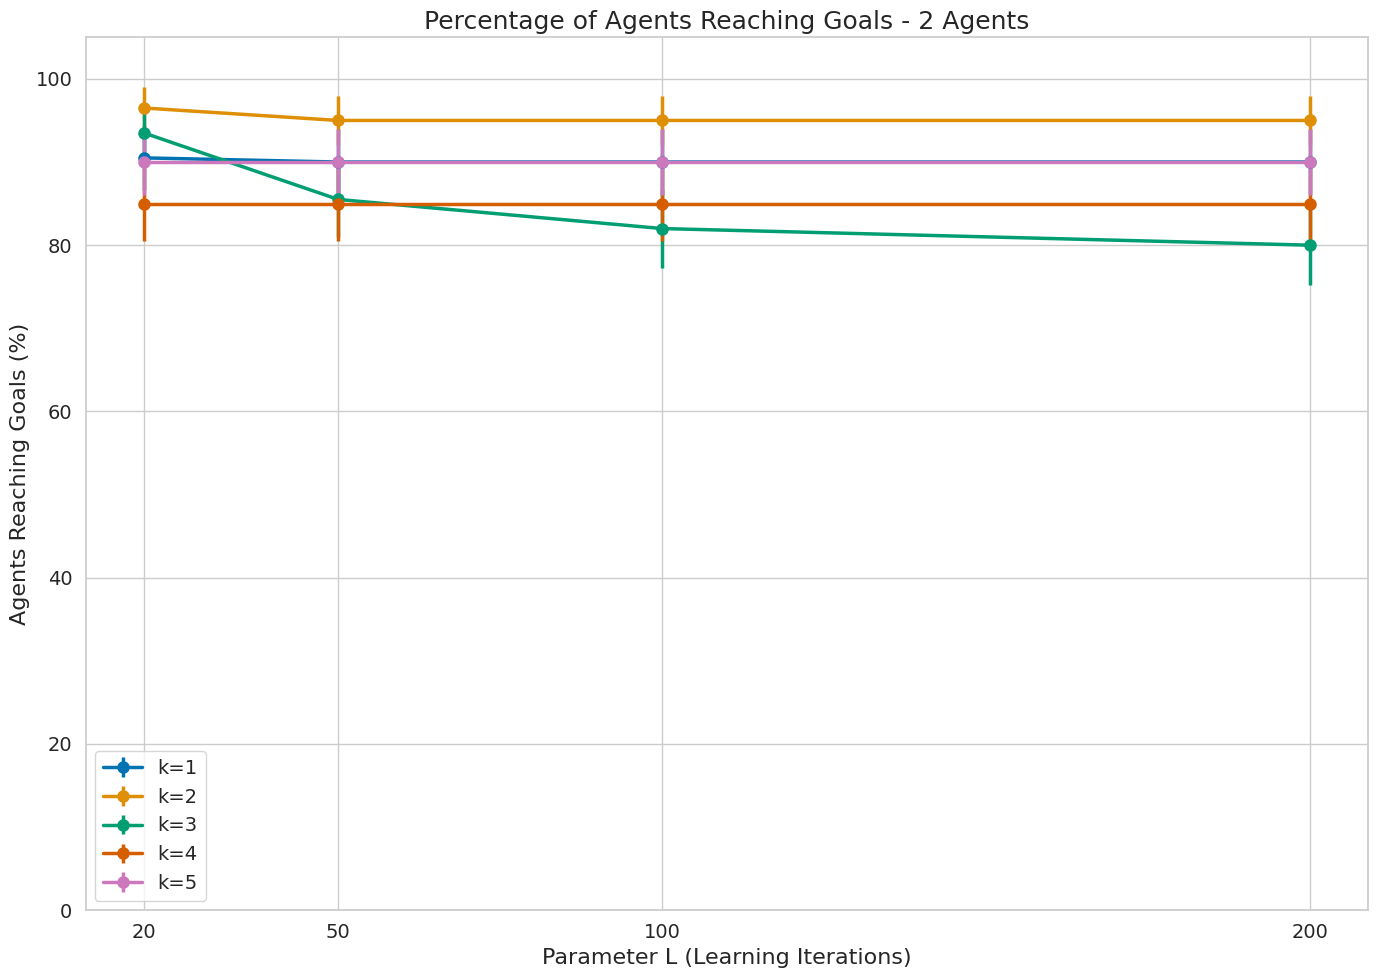

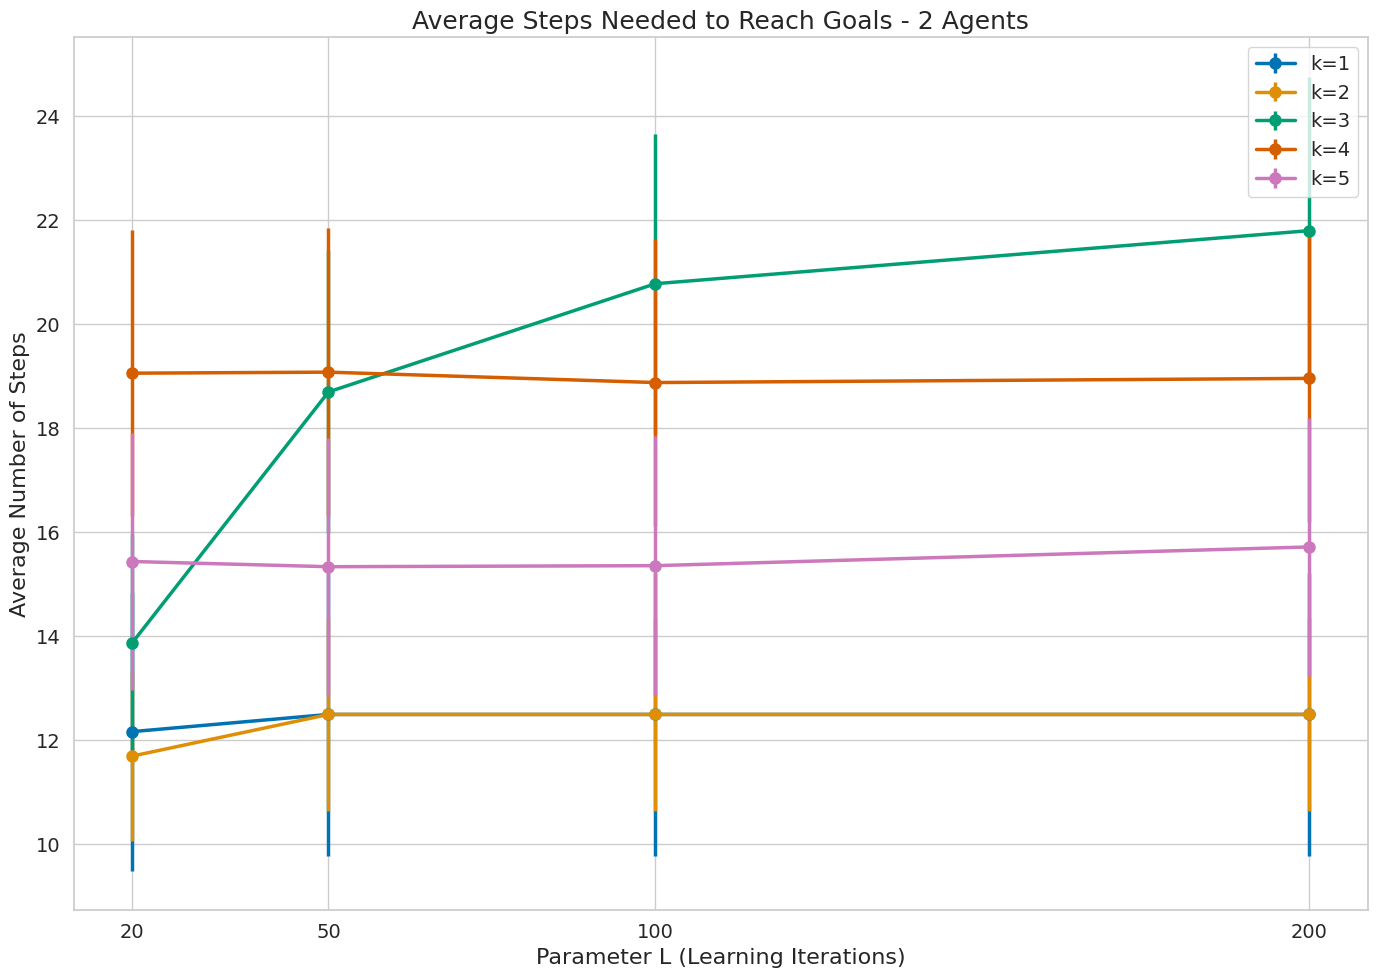

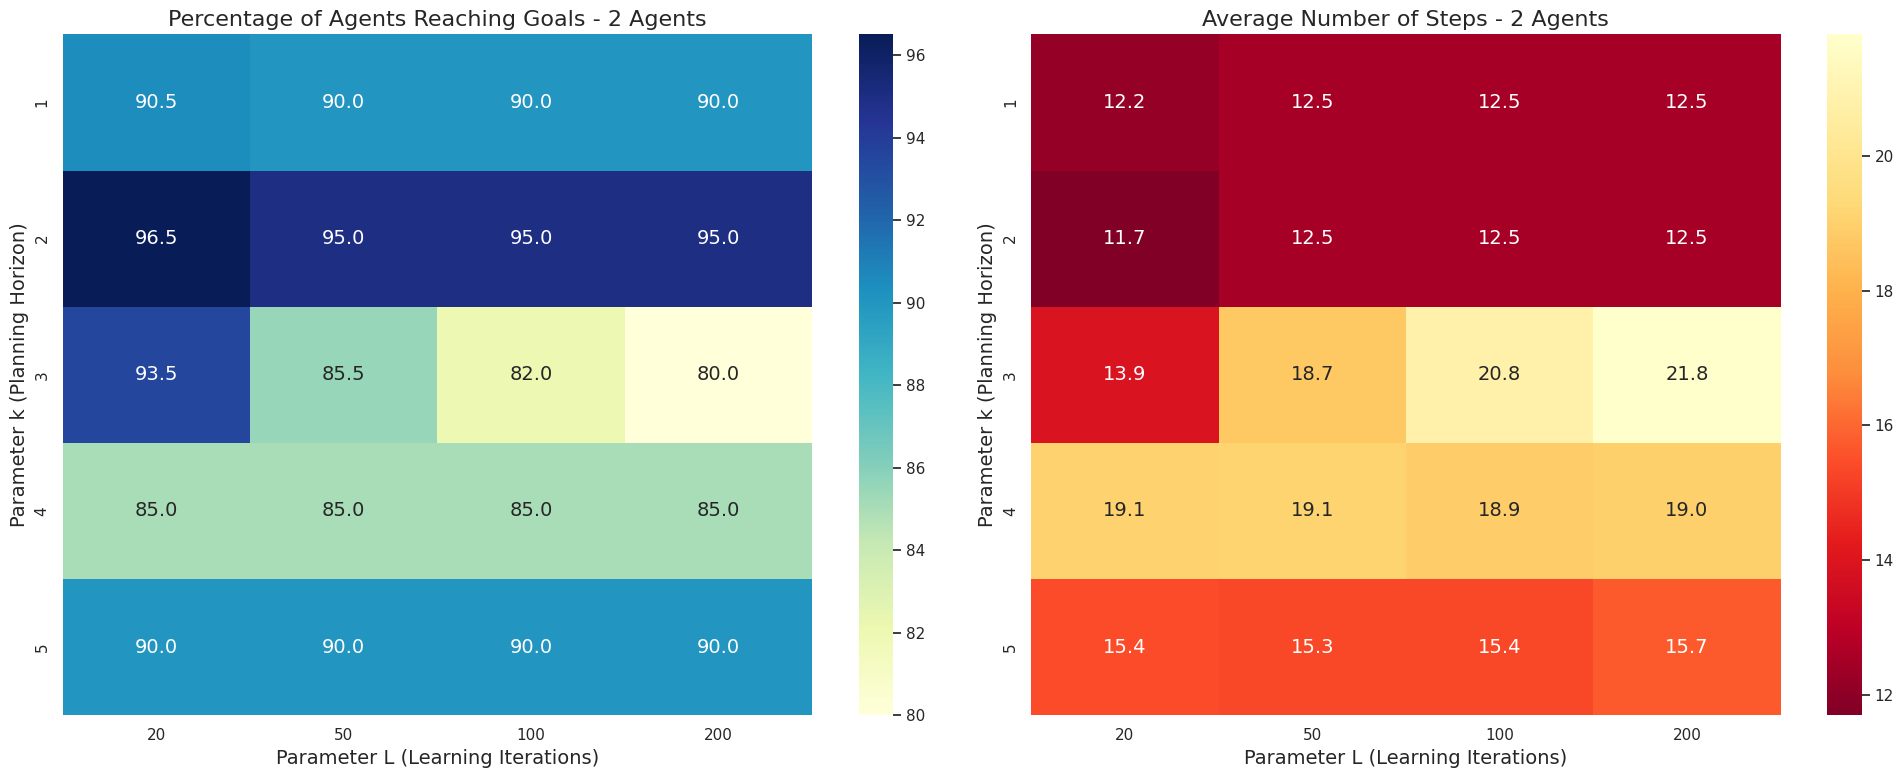

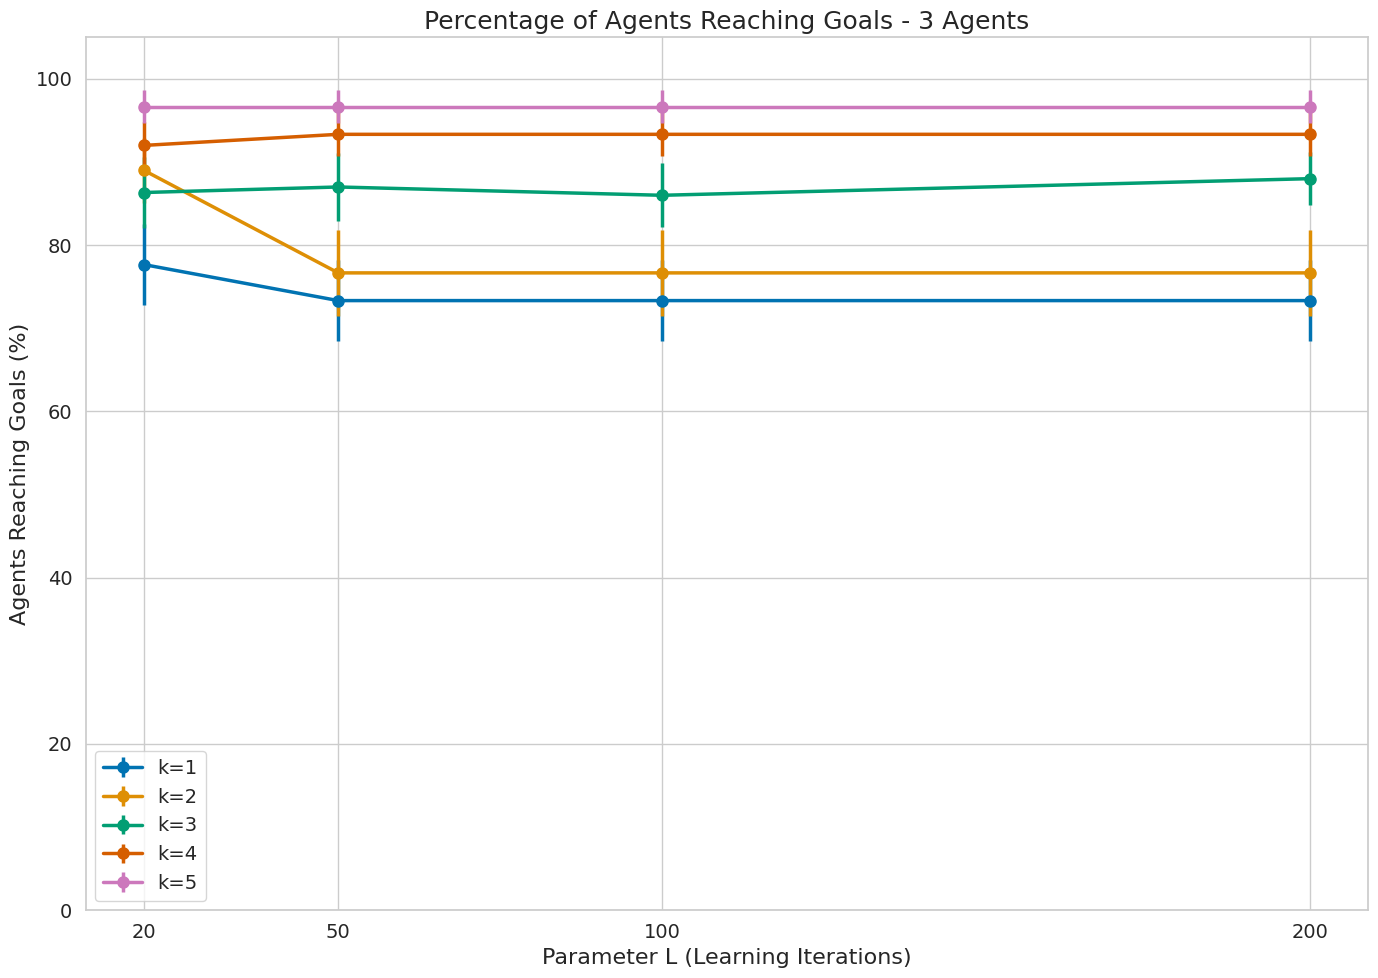

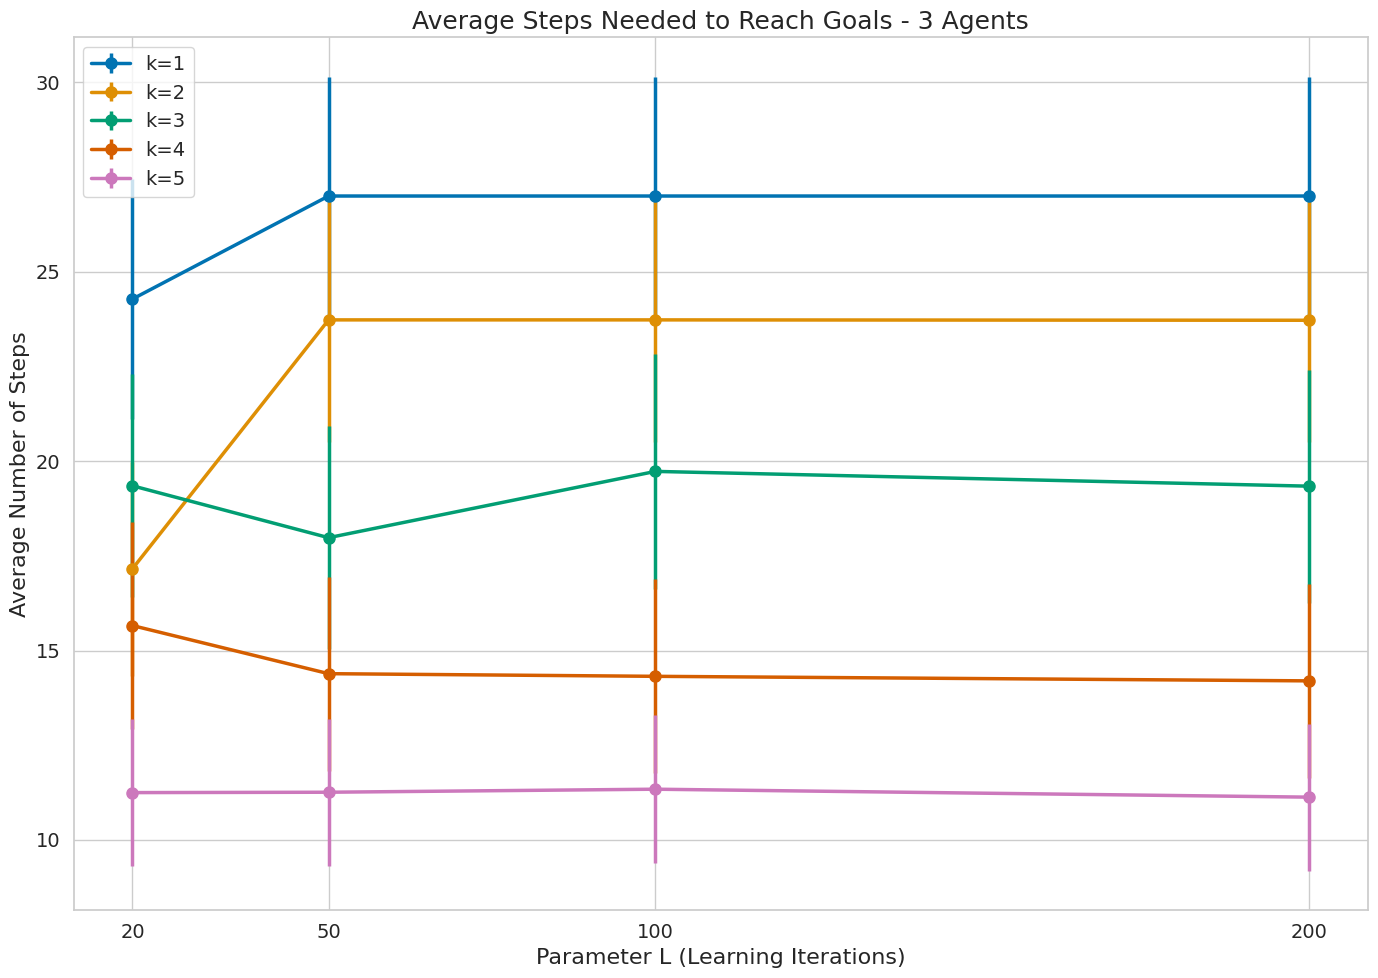

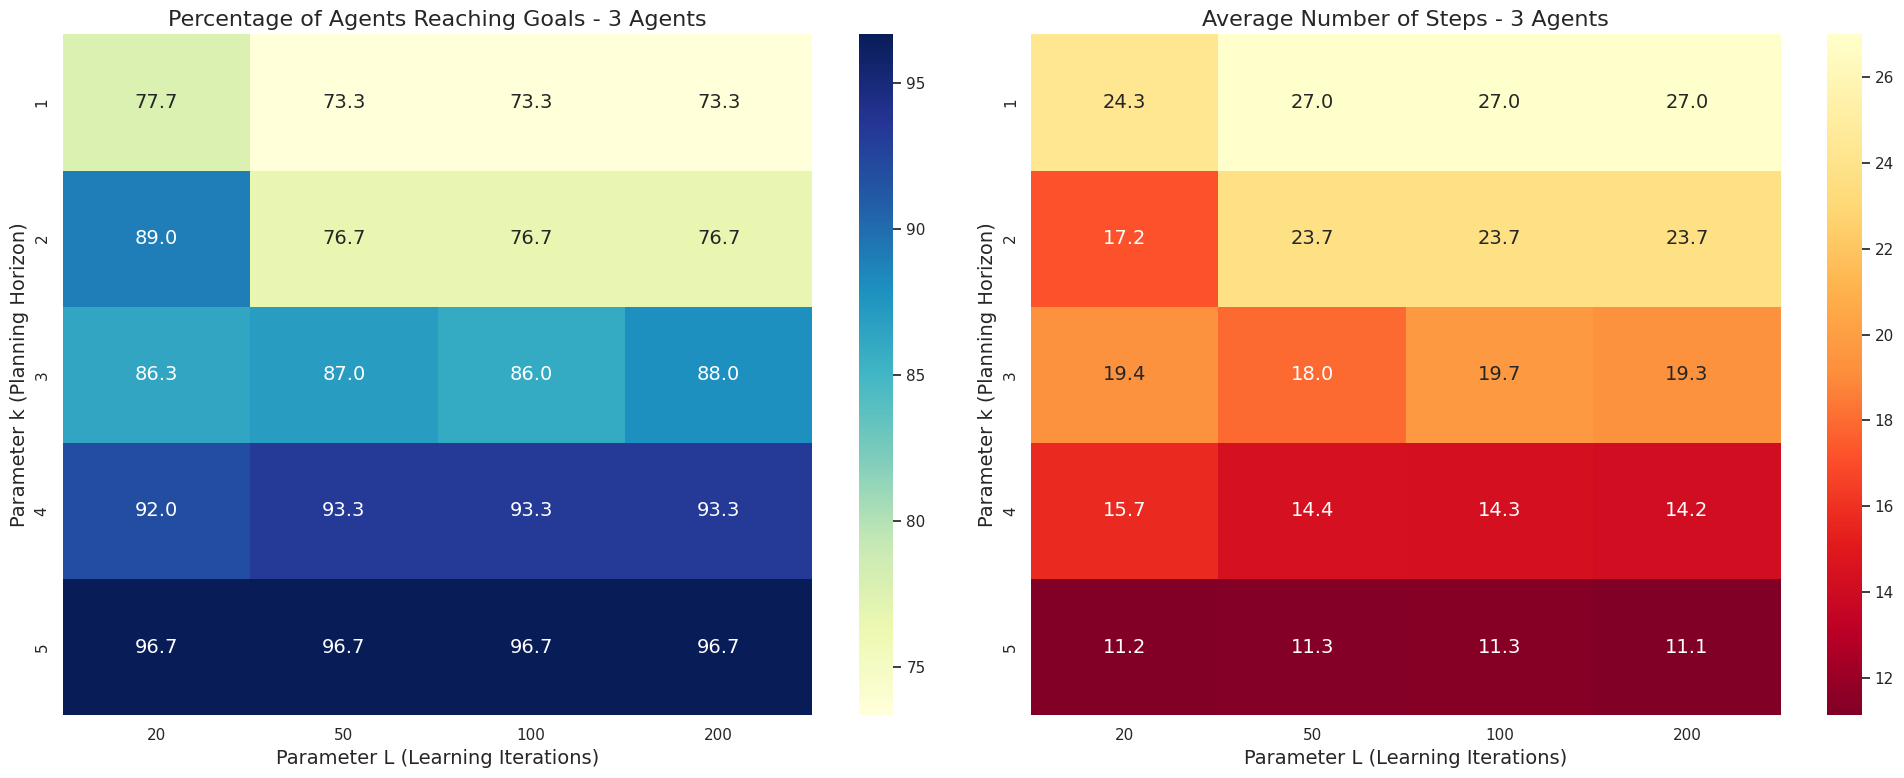

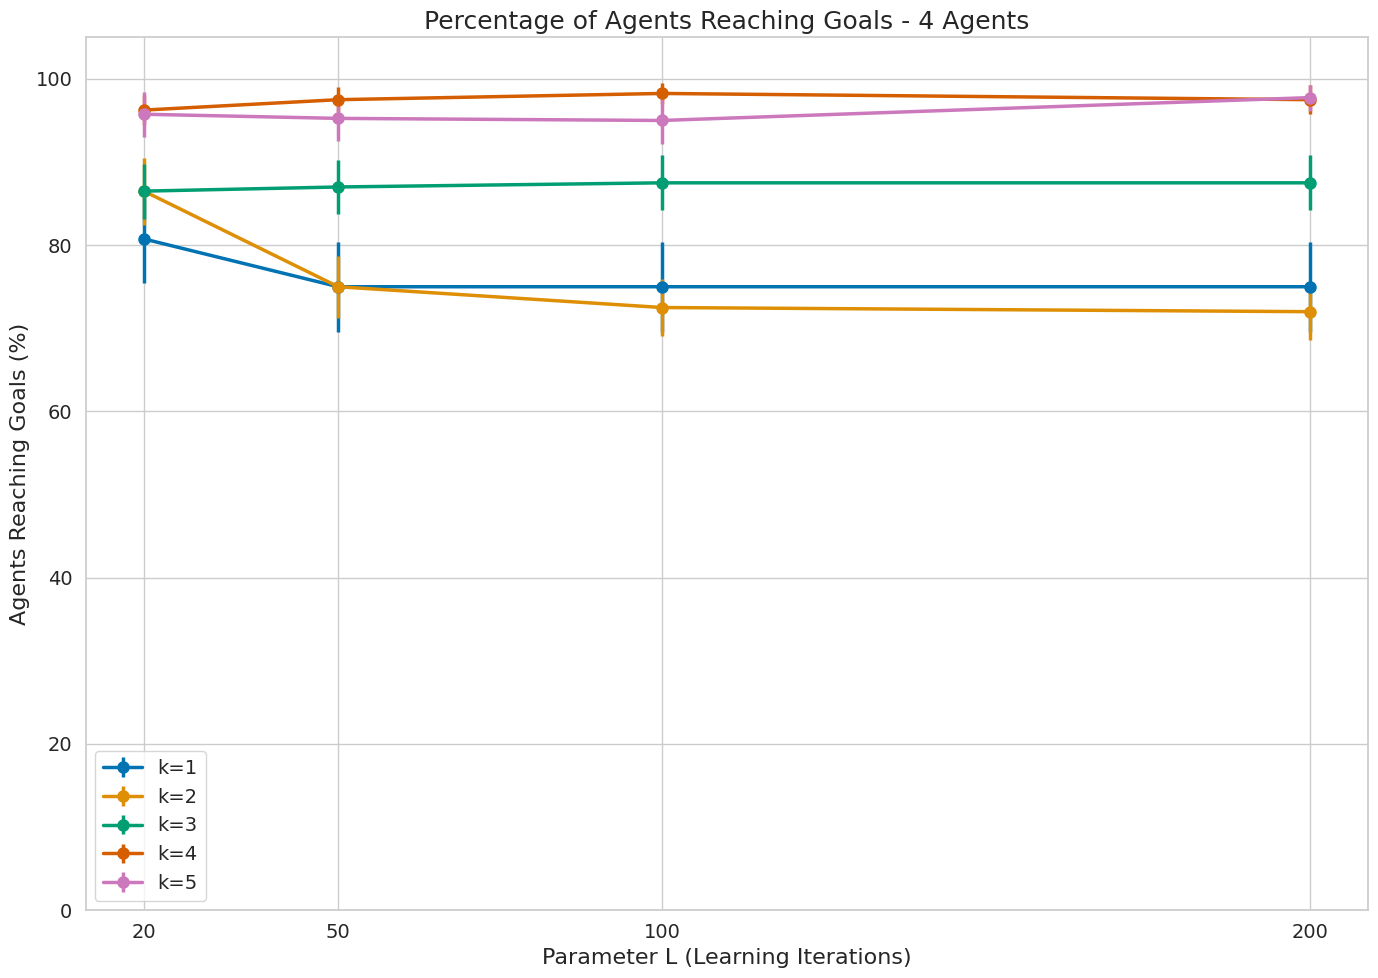

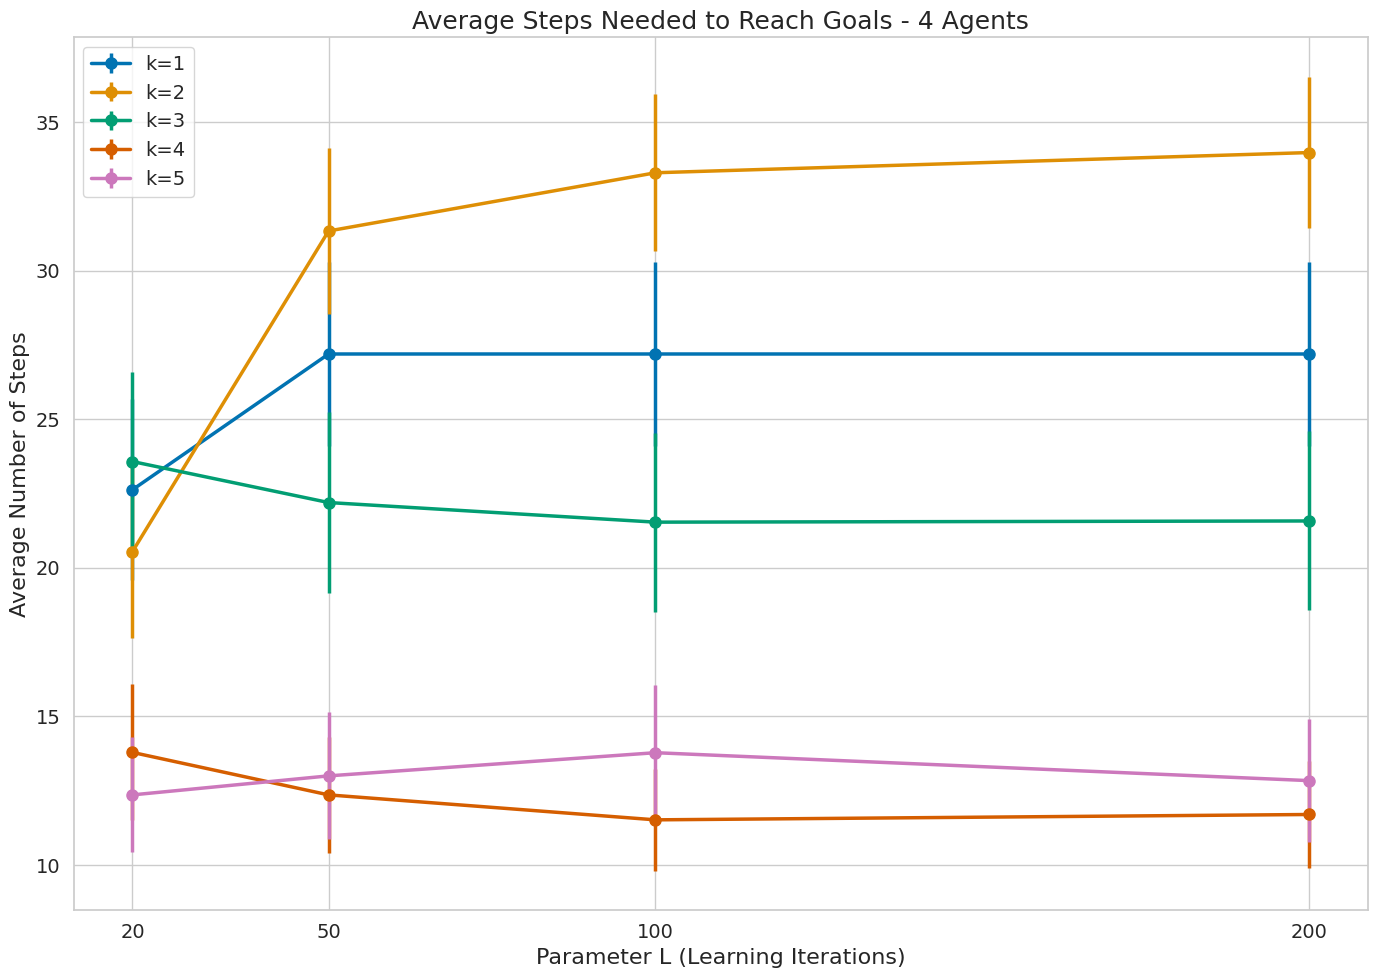

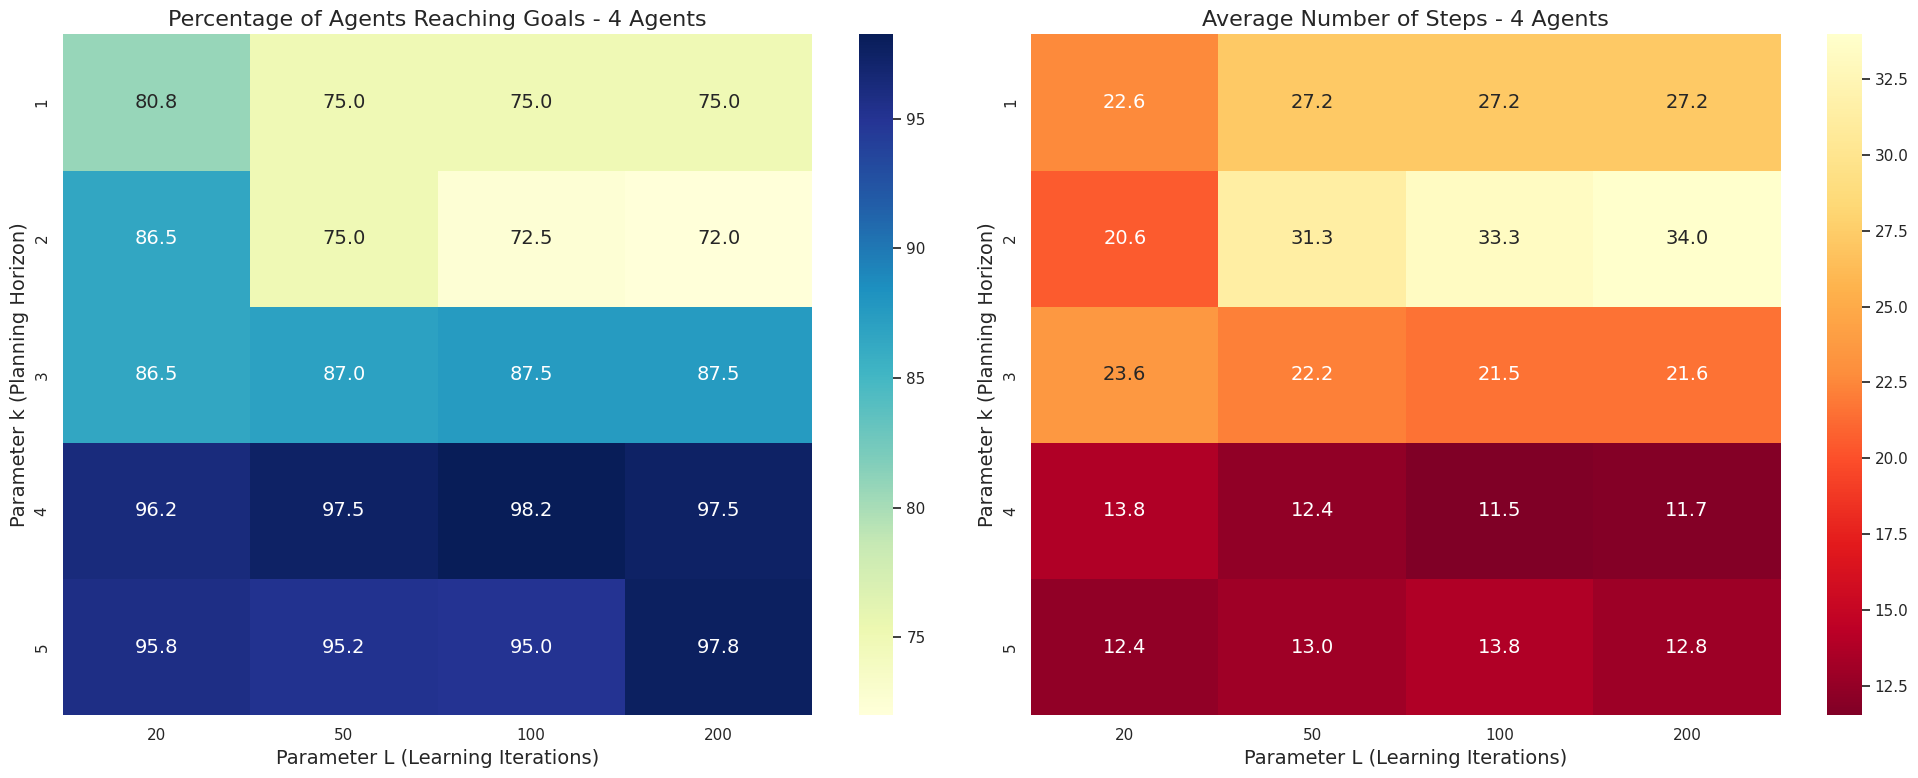

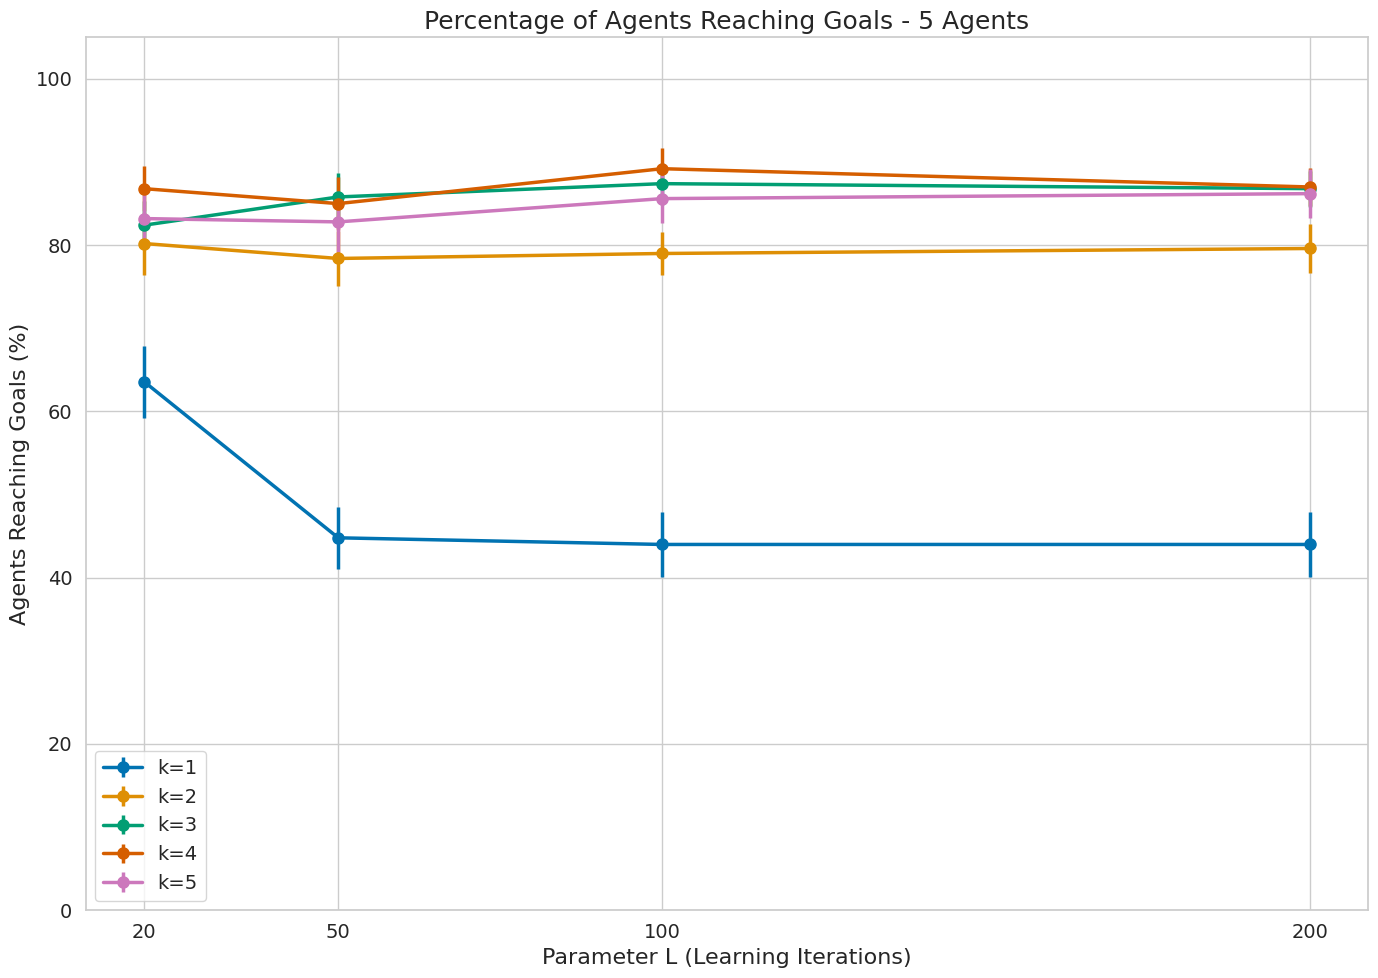

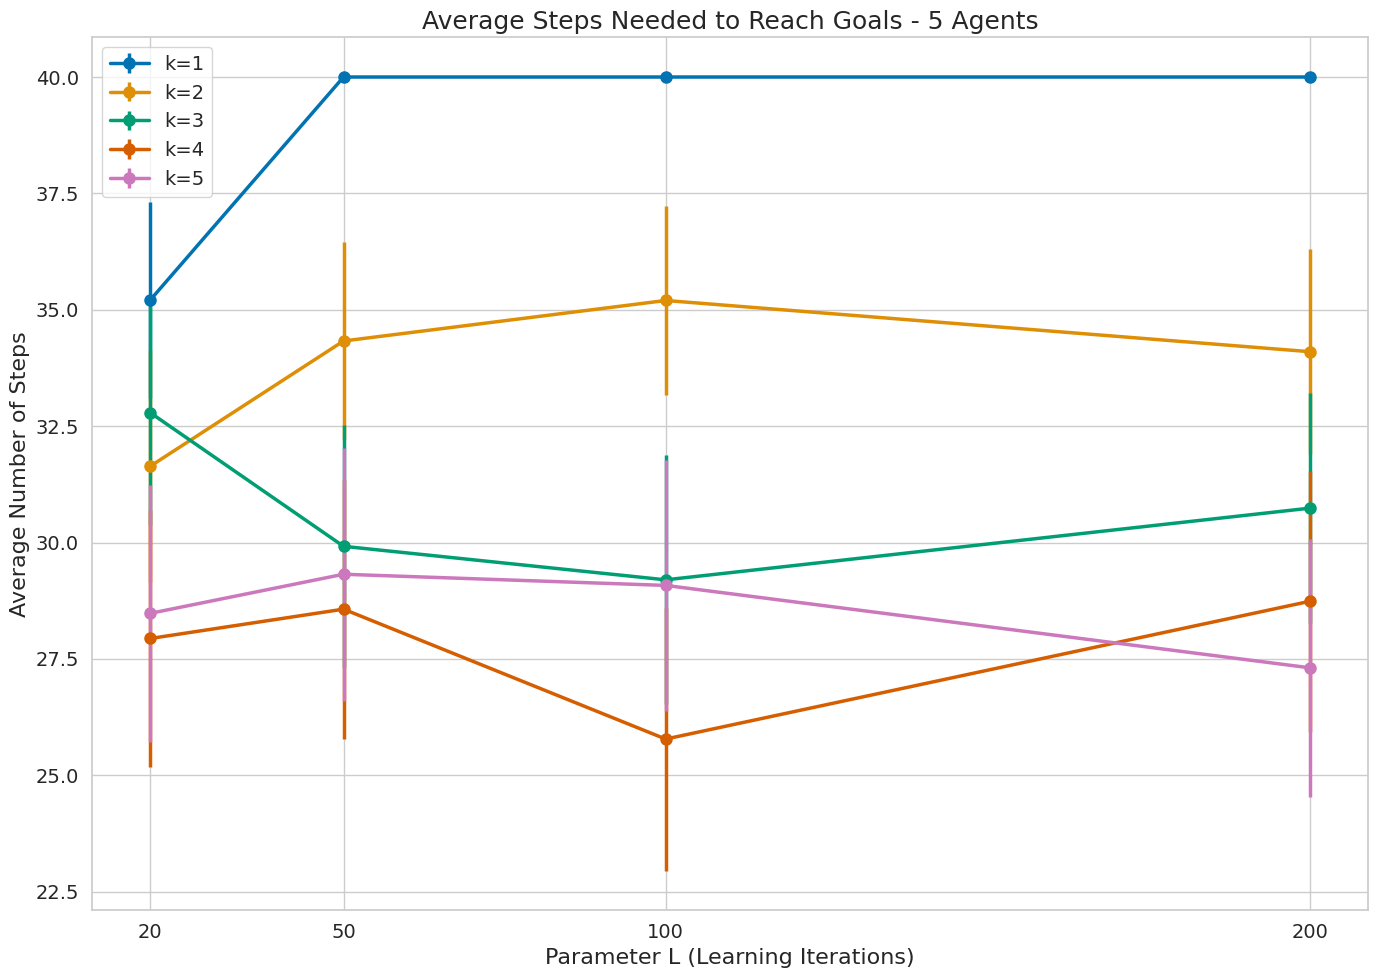

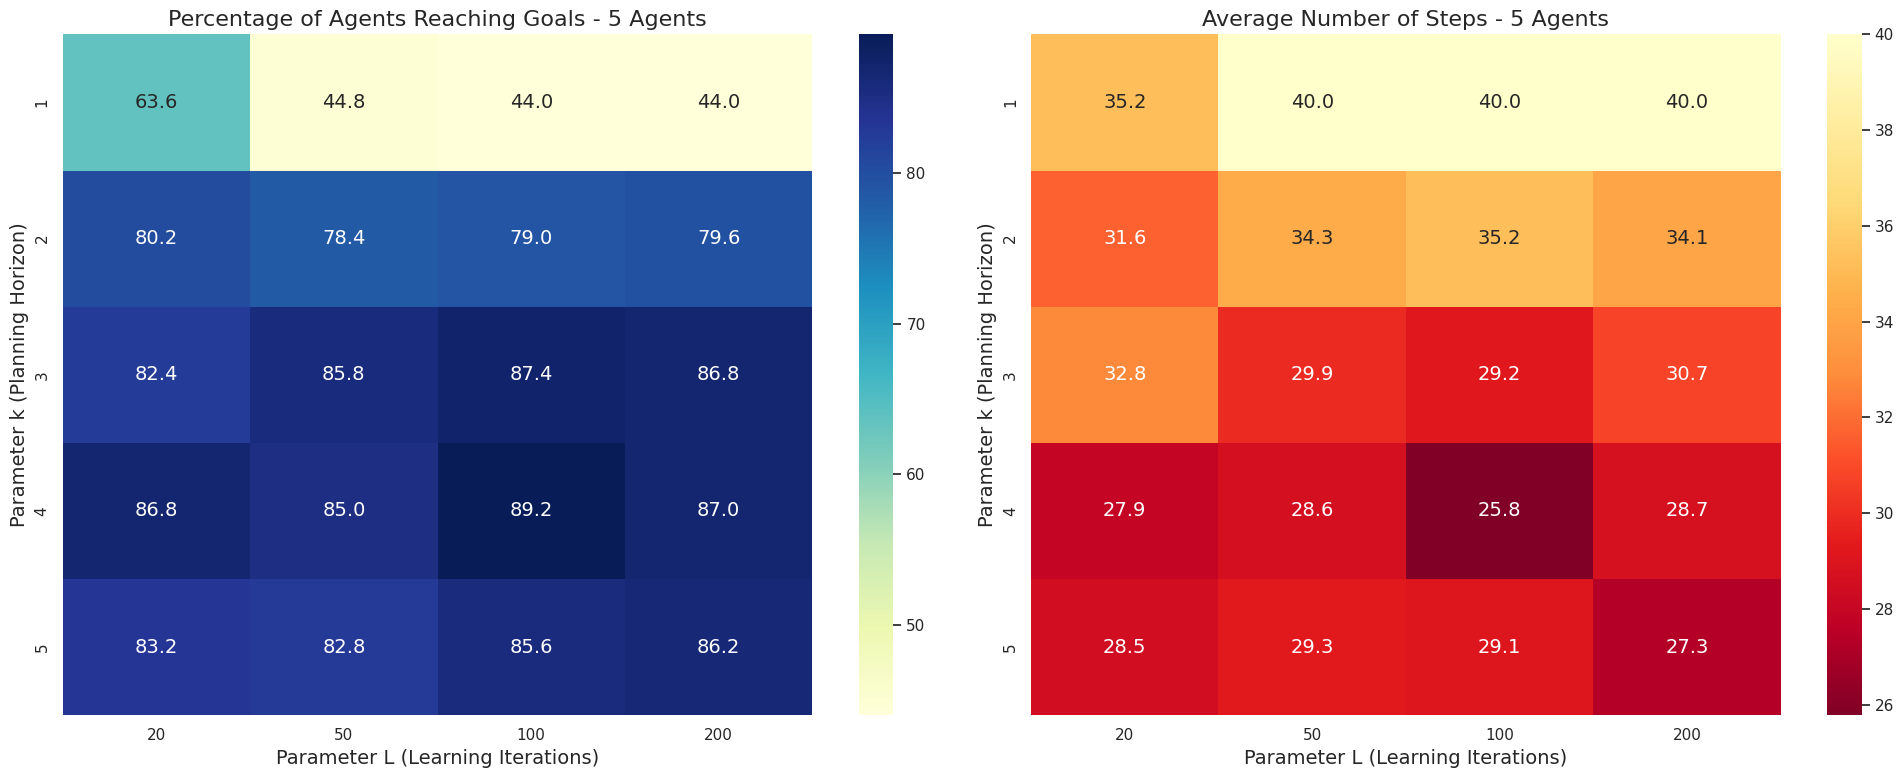

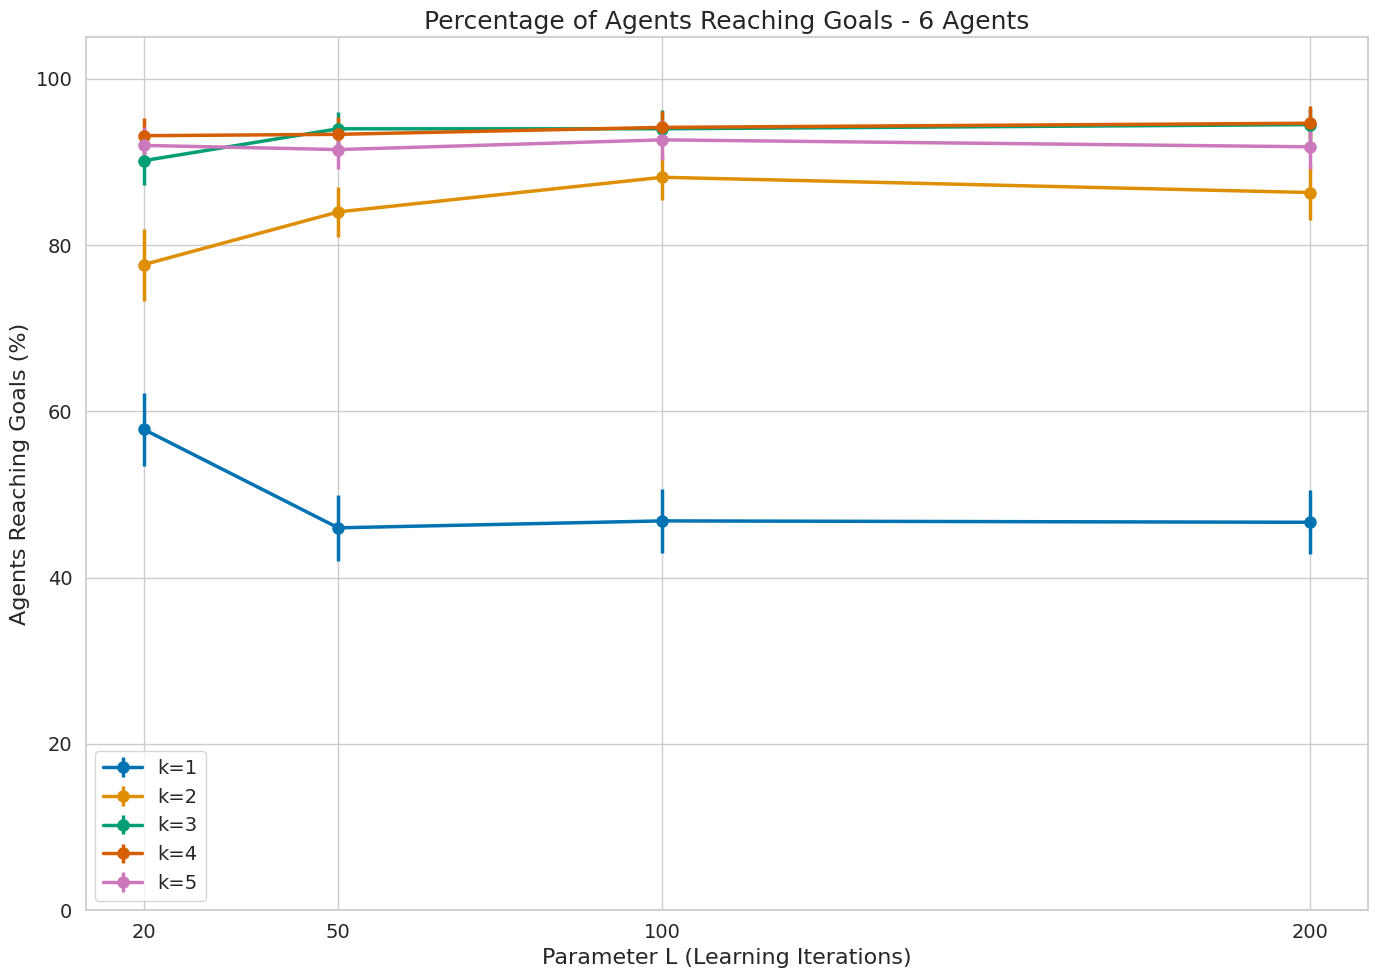

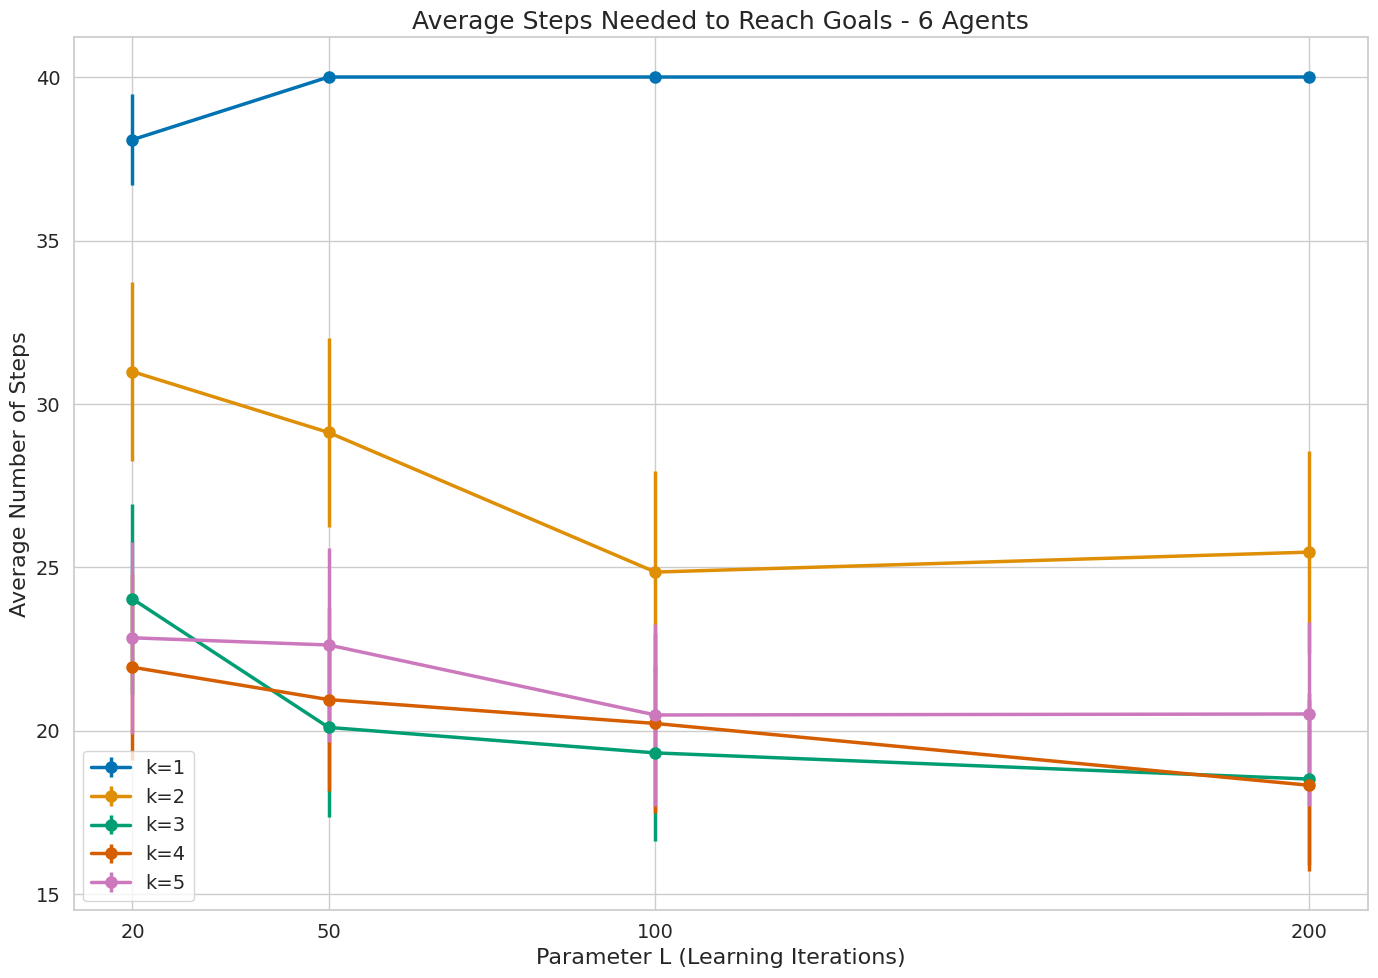

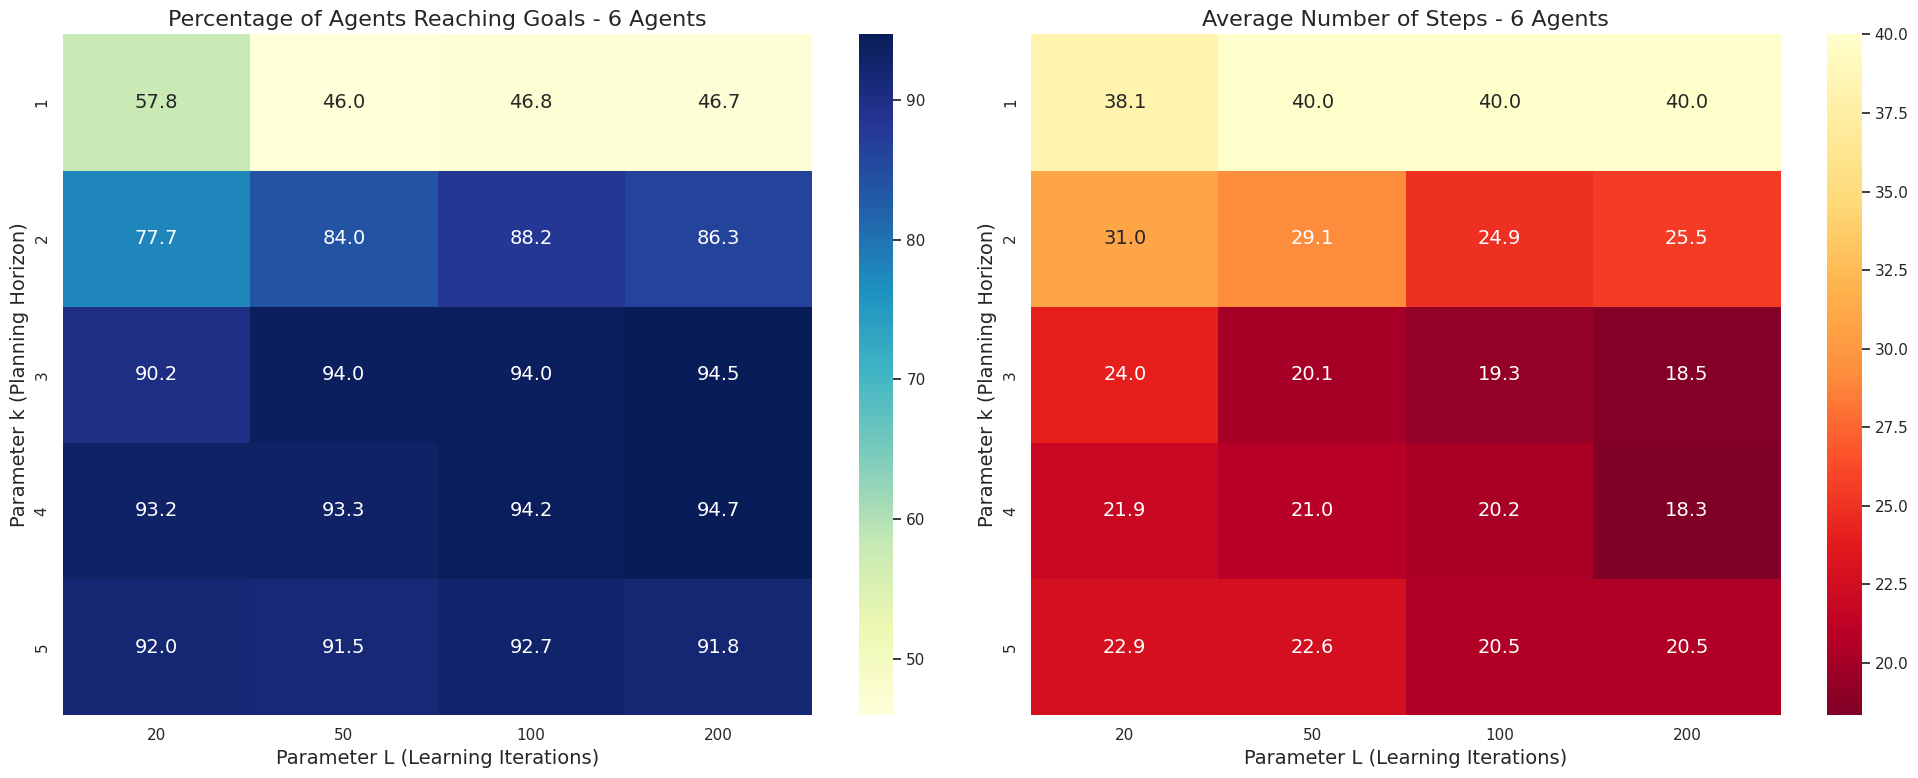

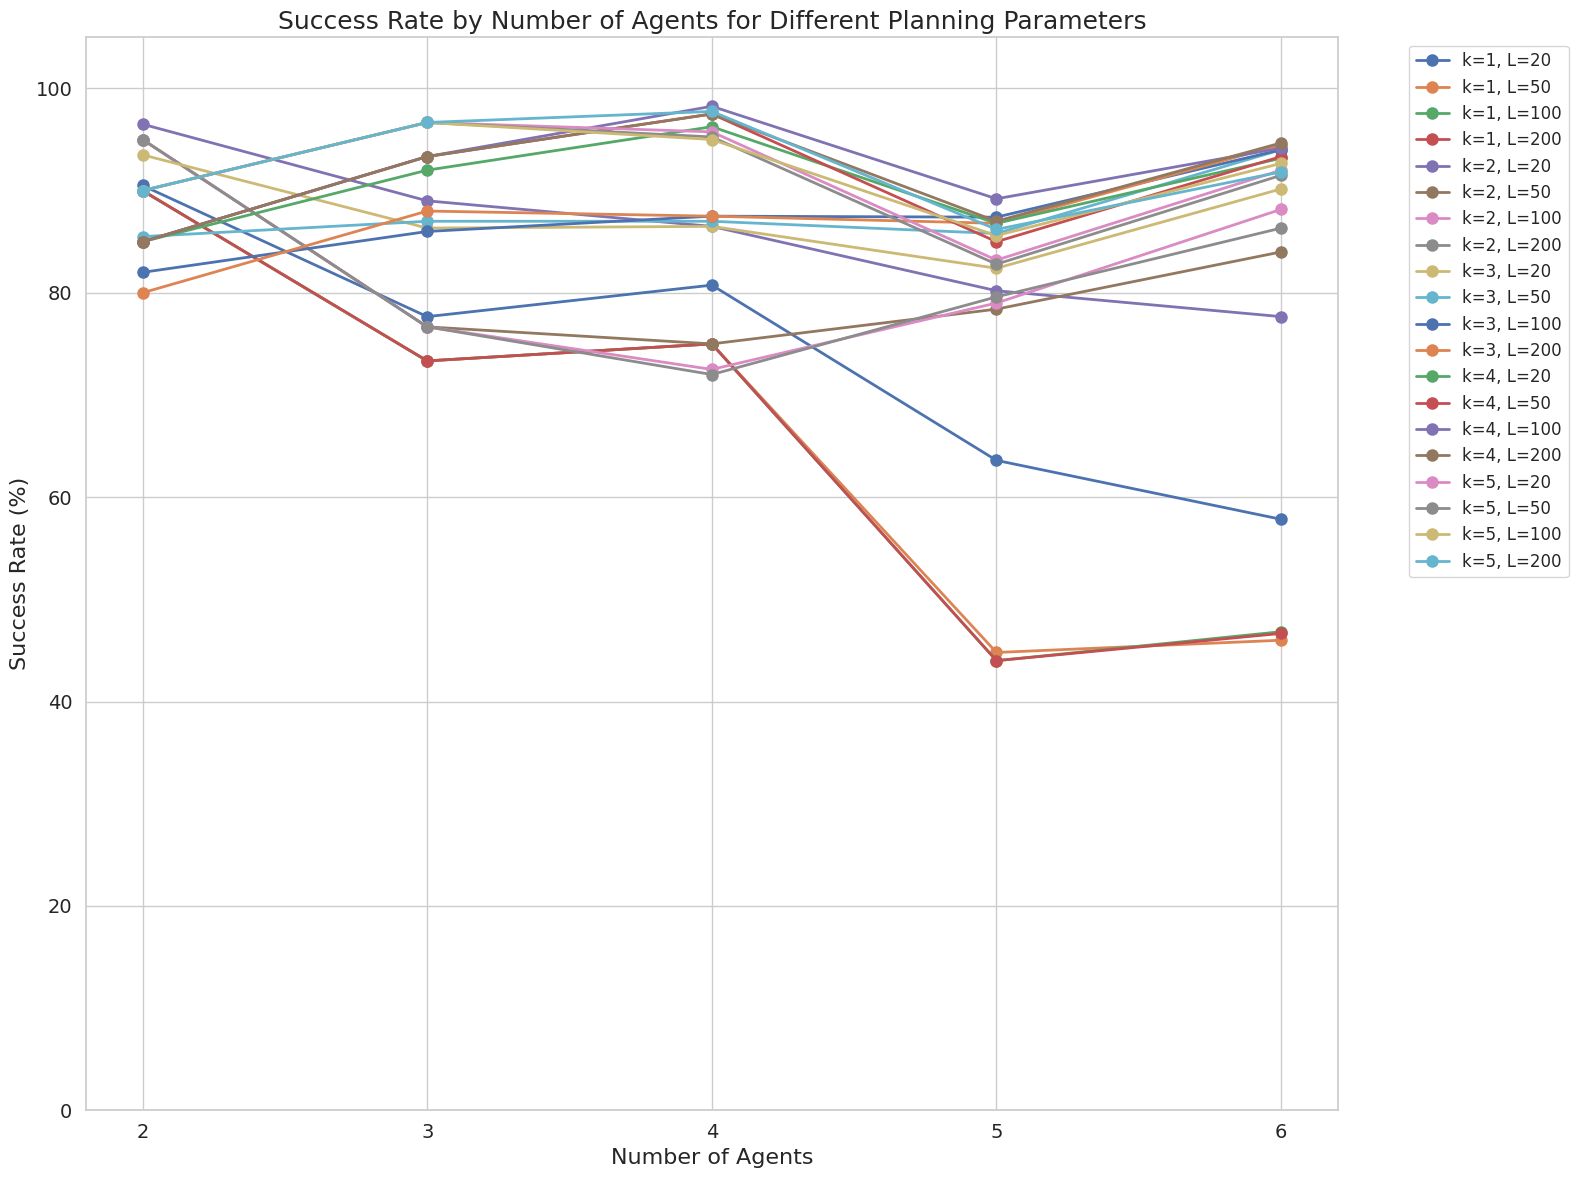

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_combined_performance_plots():
    """
    Creates plots showing the percentage of agents reaching goals and steps taken
    as functions of L for different k values, separately for each number of agents (2-6).
    """
    # Define paths to the result files
    base_path = os.path.expanduser("~/Desktop/Projet_MARL/Results")
    
    # Try to find the combined dataset first
    combined_file = os.path.join(base_path, "VaryingAgents_Combined", "varying_agents_combined_study.csv")
    
    # If the combined file doesn't exist, merge the data from separate files
    if not os.path.exists(combined_file):
        print("Combined dataset not found. Looking for individual datasets...")
        regular_file = os.path.join(base_path, "VaryingAgents", "varying_agents_parameter_study.csv")
        k1_file = os.path.join(base_path, "VaryingAgents_k1", "varying_agents_parameter_study.csv")
        
        if not os.path.exists(regular_file):
            print(f"Error: Regular dataset file not found - {regular_file}")
            return None
        
        if not os.path.exists(k1_file):
            print(f"Warning: k1 dataset file not found - {k1_file}")
            print("Proceeding with only the regular dataset.")
            df_combined = pd.read_csv(regular_file)
        else:
            # Merge the datasets
            df_regular = pd.read_csv(regular_file)
            df_k1 = pd.read_csv(k1_file)
            df_combined = pd.concat([df_regular, df_k1], ignore_index=True)
    else:
        # Load the combined dataset
        df_combined = pd.read_csv(combined_file)
    
    # Filter data to only include agents from 2 to 6
    df_filtered = df_combined[df_combined['num_agents'].between(2, 6)]
    
    # Create figures directory for the new plots
    figures_dir = os.path.expanduser("~/Desktop/Projet_MARL/Figures/PerformanceAnalysis_ByAgentCount")
    os.makedirs(figures_dir, exist_ok=True)
    
    # Configure plot style
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 14})
    
    # Get sorted unique k, L, and num_agents values
    k_values = sorted(df_filtered['k'].unique())
    L_values = sorted(df_filtered['L'].unique())
    agent_counts = sorted(df_filtered['num_agents'].unique())
    
    # Create color palette for k values (using a colorblind-friendly palette)
    colors = sns.color_palette("colorblind", n_colors=len(k_values))
    
    # Create separate plots for each number of agents
    for num_agents in agent_counts:
        # Filter data for this number of agents
        df_agents = df_filtered[df_filtered['num_agents'] == num_agents]
        
        # 1. Plot percentage of agents reaching goals as a function of L for each k
        plt.figure(figsize=(14, 10))
        
        # Calculate success rate for each k-L combination for this number of agents
        success_by_kl = df_agents.groupby(['k', 'L']).agg({
            'success_rate': ['mean', 'std', 'count'],
        }).reset_index()
        
        success_by_kl.columns = ['k', 'L', 'success_rate_mean', 'success_rate_std', 'sample_count']
        
        # Convert to percentage
        success_by_kl['success_percentage'] = success_by_kl['success_rate_mean'] * 100
        
        # Calculate 95% confidence interval
        success_by_kl['ci95'] = 1.96 * success_by_kl['success_rate_std'] / np.sqrt(success_by_kl['sample_count'])
        success_by_kl['ci95_percentage'] = success_by_kl['ci95'] * 100
        
        # Plot a line for each k value
        for i, k in enumerate(k_values):
            k_data = success_by_kl[success_by_kl['k'] == k]
            if not k_data.empty:
                plt.errorbar(
                    k_data['L'], 
                    k_data['success_percentage'], 
                    yerr=k_data['ci95_percentage'],
                    marker='o', 
                    markersize=8, 
                    linewidth=2.5, 
                    color=colors[i],
                    label=f'k={k}'
                )
        
        plt.title(f'Percentage of Agents Reaching Goals - {num_agents} Agents', fontsize=18)
        plt.xlabel('Parameter L (Learning Iterations)', fontsize=16)
        plt.ylabel('Agents Reaching Goals (%)', fontsize=16)
        plt.xticks(L_values, fontsize=14)
        plt.yticks(fontsize=14)
        plt.ylim(0, 105)
        plt.grid(True)
        plt.legend(fontsize=14)
        plt.tight_layout()
        
        # Save the plot
        success_plot_path = os.path.join(figures_dir, f'percentage_agents_by_L_for_k_{num_agents}agents.png')
        plt.savefig(success_plot_path, dpi=300)
        print(f"Success rate plot for {num_agents} agents saved to: {success_plot_path}")
        
        # 2. Plot average steps as a function of L for each k
        plt.figure(figsize=(14, 10))
        
        # Calculate average steps for each k-L combination
        # Only consider cases where at least some agents reached their goals
        steps_by_kl = df_agents[df_agents['agents_at_goal'] > 0].groupby(['k', 'L']).agg({
            'steps': ['mean', 'std', 'count'],
        }).reset_index()
        
        steps_by_kl.columns = ['k', 'L', 'steps_mean', 'steps_std', 'sample_count']
        
        # Calculate 95% confidence interval
        steps_by_kl['ci95'] = 1.96 * steps_by_kl['steps_std'] / np.sqrt(steps_by_kl['sample_count'])
        
        # Plot a line for each k value
        for i, k in enumerate(k_values):
            k_data = steps_by_kl[steps_by_kl['k'] == k]
            if not k_data.empty:
                plt.errorbar(
                    k_data['L'], 
                    k_data['steps_mean'], 
                    yerr=k_data['ci95'],
                    marker='o', 
                    markersize=8, 
                    linewidth=2.5,
                    color=colors[i],
                    label=f'k={k}'
                )
        
        plt.title(f'Average Steps Needed to Reach Goals - {num_agents} Agents', fontsize=18)
        plt.xlabel('Parameter L (Learning Iterations)', fontsize=16)
        plt.ylabel('Average Number of Steps', fontsize=16)
        plt.xticks(L_values, fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(True)
        plt.legend(fontsize=14)
        plt.tight_layout()
        
        # Save the plot
        steps_plot_path = os.path.join(figures_dir, f'average_steps_by_L_for_k_{num_agents}agents.png')
        plt.savefig(steps_plot_path, dpi=300)
        print(f"Steps plot for {num_agents} agents saved to: {steps_plot_path}")
        
        # 3. Create a comparative heatmap showing both metrics side by side for this number of agents
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Create pivot tables for heatmaps
        success_pivot = success_by_kl.pivot_table(
            values='success_percentage', 
            index='k', 
            columns='L'
        )
        
        steps_pivot = steps_by_kl.pivot_table(
            values='steps_mean', 
            index='k', 
            columns='L'
        )
        
        # Plot heatmaps
        sns.heatmap(success_pivot, annot=True, cmap="YlGnBu", fmt=".1f", ax=ax1)
        ax1.set_title(f'Percentage of Agents Reaching Goals - {num_agents} Agents', fontsize=16)
        ax1.set_xlabel('Parameter L (Learning Iterations)', fontsize=14)
        ax1.set_ylabel('Parameter k (Planning Horizon)', fontsize=14)
        
        sns.heatmap(steps_pivot, annot=True, cmap="YlOrRd_r", fmt=".1f", ax=ax2)
        ax2.set_title(f'Average Number of Steps - {num_agents} Agents', fontsize=16)
        ax2.set_xlabel('Parameter L (Learning Iterations)', fontsize=14)
        ax2.set_ylabel('Parameter k (Planning Horizon)', fontsize=14)
        
        plt.tight_layout()
        
        # Save the comparative plot
        comparative_plot_path = os.path.join(figures_dir, f'comparative_heatmaps_{num_agents}agents.png')
        plt.savefig(comparative_plot_path, dpi=300)
        print(f"Comparative heatmaps for {num_agents} agents saved to: {comparative_plot_path}")
    
    # Additionally, create a summary plot showing trends across different numbers of agents
    plt.figure(figsize=(16, 12))
    
    # Calculate success rate across all agent counts for each k value
    for i, k in enumerate(k_values):
        # Get data for this k value across all agent counts
        k_data = df_filtered[df_filtered['k'] == k].groupby(['num_agents', 'L']).agg({
            'success_rate': 'mean'
        }).reset_index()
        
        # Create a plot for each L value with markers indicating agent count
        for L in L_values:
            L_data = k_data[k_data['L'] == L]
            if not L_data.empty:
                plt.plot(
                    L_data['num_agents'],
                    L_data['success_rate'] * 100,
                    'o-',
                    linewidth=2,
                    markersize=8,
                    label=f'k={k}, L={L}'
                )
    
    plt.title('Success Rate by Number of Agents for Different Planning Parameters', fontsize=18)
    plt.xlabel('Number of Agents', fontsize=16)
    plt.ylabel('Success Rate (%)', fontsize=16)
    plt.xticks(agent_counts, fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 105)
    plt.grid(True)
    plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save the summary plot
    summary_plot_path = os.path.join(figures_dir, 'success_rate_by_agent_count.png')
    plt.savefig(summary_plot_path, dpi=300)
    print(f"Summary plot saved to: {summary_plot_path}")
    
    return df_filtered

if __name__ == "__main__":
    df_filtered = create_combined_performance_plots()
    print("Analysis complete!")

Plot saved to: /home/yacine/Desktop/Projet_MARL/Figures/OptimalParameters/complete_success_rate_best_L_for_each_k.png
Best L summary saved to: /home/yacine/Desktop/Projet_MARL/Figures/OptimalParameters/best_L_for_each_k.csv
Heatmap saved to: /home/yacine/Desktop/Projet_MARL/Figures/OptimalParameters/complete_success_heatmap_best_L.png

Best L values for each k:
k=1: Best L=20.0
k=2: Best L=20.0
k=3: Best L=50.0
k=4: Best L=100.0
k=5: Best L=200.0


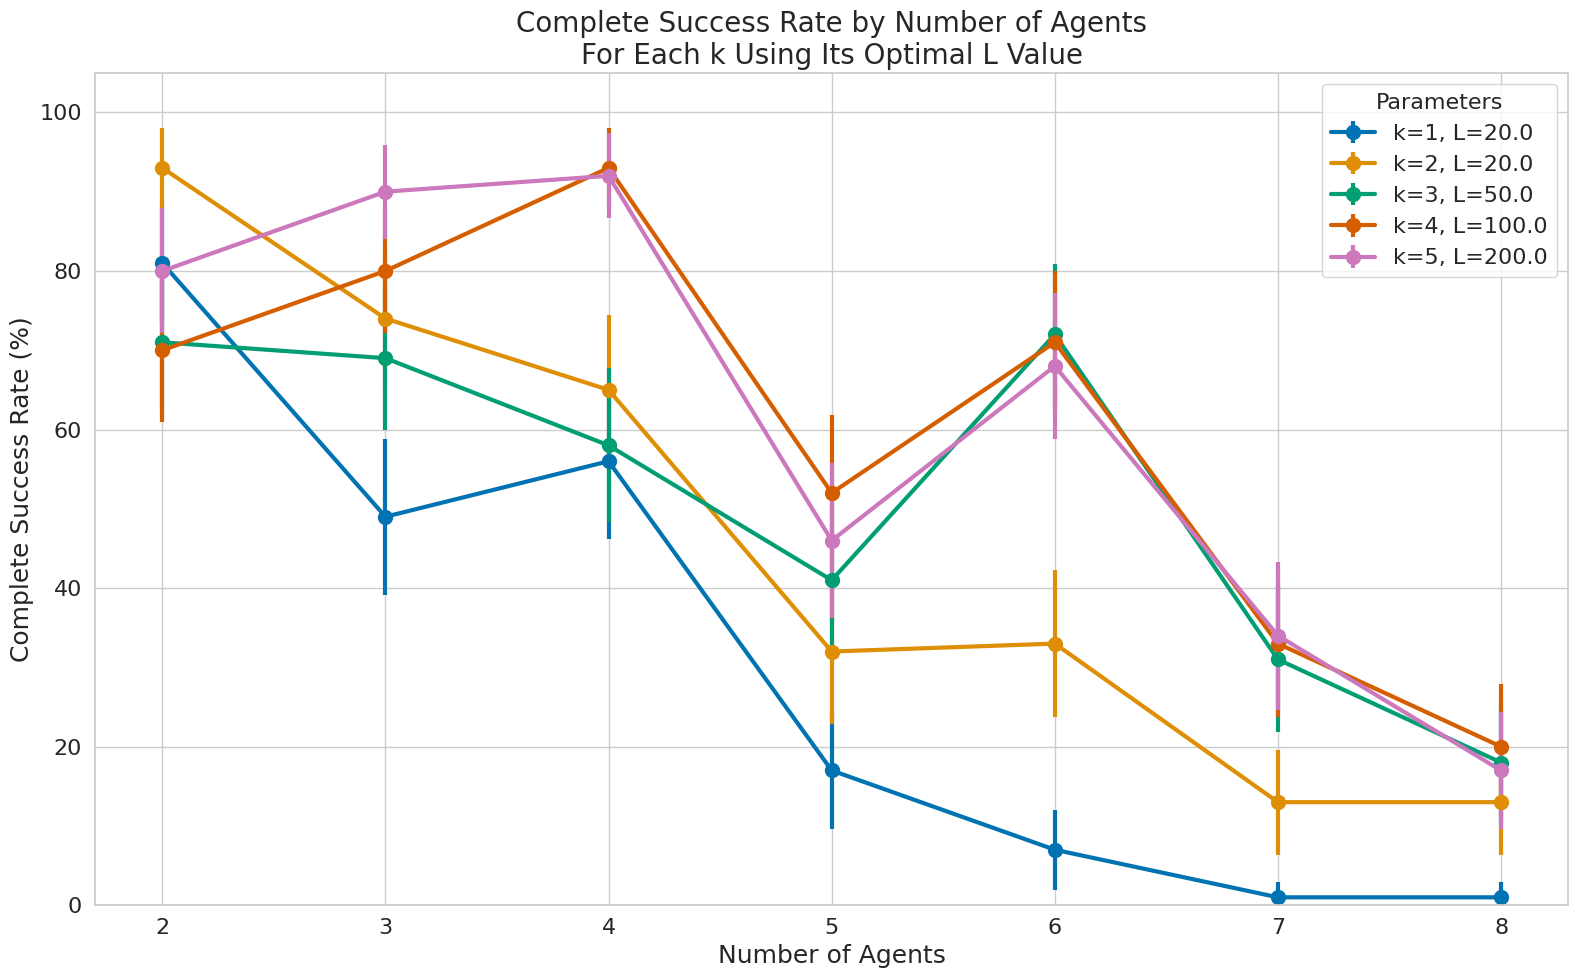

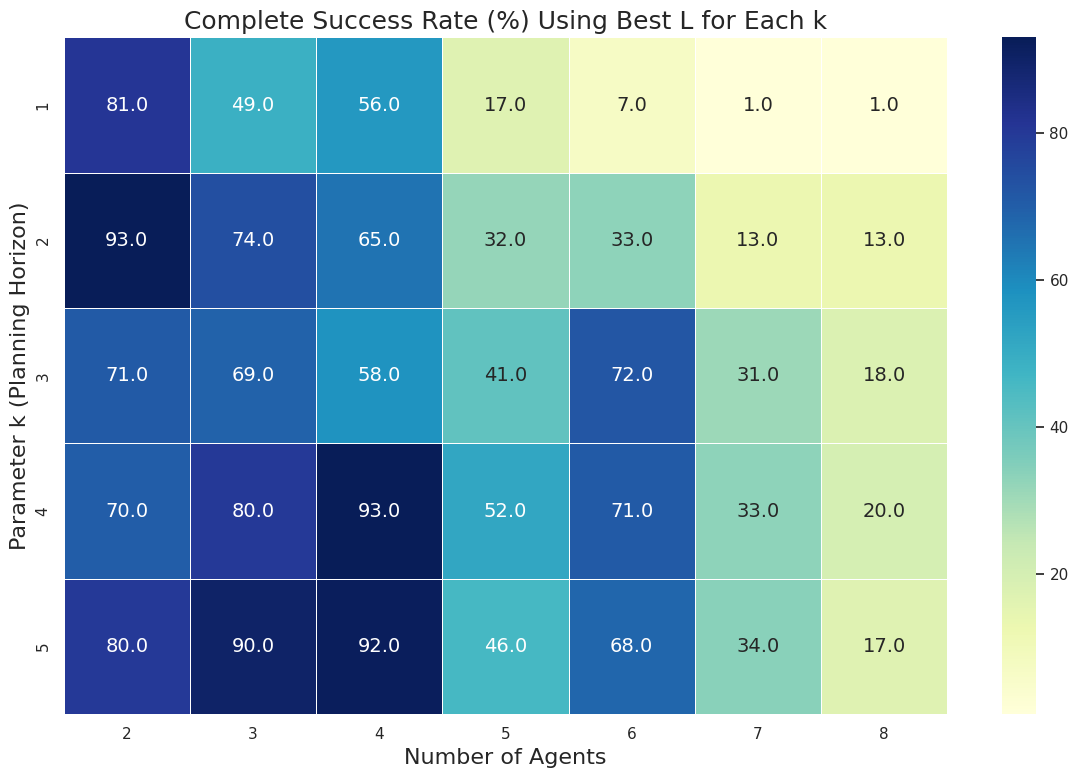

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

def create_best_L_for_each_k_plot():
    """
    Creates a plot showing the complete success rate for each k value
    using the best L value for that k, for agents from 2 to 8.
    """
    # Define paths to the result files
    base_path = os.path.expanduser("~/Desktop/Projet_MARL/Results")
    
    # Try to find the combined dataset first
    combined_file = os.path.join(base_path, "VaryingAgents_Combined", "varying_agents_combined_study.csv")
    
    # If the combined file doesn't exist, merge the data from separate files
    if not os.path.exists(combined_file):
        print("Combined dataset not found. Looking for individual datasets...")
        regular_file = os.path.join(base_path, "VaryingAgents", "varying_agents_parameter_study.csv")
        k1_file = os.path.join(base_path, "VaryingAgents_k1", "varying_agents_parameter_study.csv")
        
        if not os.path.exists(regular_file):
            print(f"Error: Regular dataset file not found - {regular_file}")
            return None
        
        if not os.path.exists(k1_file):
            print(f"Warning: k1 dataset file not found - {k1_file}")
            print("Proceeding with only the regular dataset.")
            df_combined = pd.read_csv(regular_file)
        else:
            # Merge the datasets
            df_regular = pd.read_csv(regular_file)
            df_k1 = pd.read_csv(k1_file)
            df_combined = pd.concat([df_regular, df_k1], ignore_index=True)
    else:
        # Load the combined dataset
        df_combined = pd.read_csv(combined_file)
    
    # Filter data to only include agents from 2 to 8
    df_filtered = df_combined[df_combined['num_agents'].between(2, 8)]
    
    # Create figures directory for the new plot
    figures_dir = os.path.expanduser("~/Desktop/Projet_MARL/Figures/OptimalParameters")
    os.makedirs(figures_dir, exist_ok=True)
    
    # Configure plot style
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 14})
    
    # Get sorted unique k values and agent counts
    k_values = sorted(df_filtered['k'].unique())
    agent_counts = sorted(df_filtered['num_agents'].unique())
    
    # Find the best L value for each k, independent of agent count
    best_L_for_k = {}
    for k in k_values:
        # For each k, group by L and find the L that maximizes complete success rate
        k_data = df_filtered[df_filtered['k'] == k]
        success_by_L = k_data.groupby('L')['complete_success'].mean().reset_index()
        best_L = success_by_L.loc[success_by_L['complete_success'].idxmax()]['L']
        best_L_for_k[k] = best_L
    
    # Create DataFrame to hold success rates for each k-agent combination using the best L
    success_rates = []
    
    for k in k_values:
        best_L = best_L_for_k[k]
        for num_agents in agent_counts:
            data = df_filtered[(df_filtered['k'] == k) & 
                              (df_filtered['L'] == best_L) & 
                              (df_filtered['num_agents'] == num_agents)]
            
            if not data.empty:
                success_rate = data['complete_success'].mean() * 100
                success_std = data['complete_success'].std() * 100
                count = len(data)
                ci95 = 1.96 * success_std / np.sqrt(count)
                
                success_rates.append({
                    'k': k,
                    'best_L': best_L,
                    'num_agents': num_agents,
                    'success_rate': success_rate,
                    'ci95': ci95
                })
    
    success_df = pd.DataFrame(success_rates)
    
    # Create the plot
    plt.figure(figsize=(16, 10))
    
    # Create a colormap for different k values
    colors = sns.color_palette("colorblind", n_colors=len(k_values))
    
    # Plot a line for each k value with its best L
    for i, k in enumerate(k_values):
        k_data = success_df[success_df['k'] == k]
        best_L = k_data['best_L'].iloc[0] if not k_data.empty else None
        
        if not k_data.empty:
            plt.errorbar(
                k_data['num_agents'],
                k_data['success_rate'],
                yerr=k_data['ci95'],
                marker='o',
                markersize=10,
                linewidth=3,
                color=colors[i],
                label=f'k={k}, L={best_L}'
            )
    
    plt.title('Complete Success Rate by Number of Agents\nFor Each k Using Its Optimal L Value', fontsize=20)
    plt.xlabel('Number of Agents', fontsize=18)
    plt.ylabel('Complete Success Rate (%)', fontsize=18)
    plt.xticks(agent_counts, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(0, 105)
    plt.grid(True)
    plt.legend(fontsize=16, title='Parameters', title_fontsize=16)
    plt.tight_layout()
    
    # Save the plot
    plot_path = os.path.join(figures_dir, 'complete_success_rate_best_L_for_each_k.png')
    plt.savefig(plot_path, dpi=300)
    print(f"Plot saved to: {plot_path}")
    
    # Create a summary table showing the best L for each k
    best_L_summary = pd.DataFrame({
        'k': list(best_L_for_k.keys()),
        'best_L': list(best_L_for_k.values())
    })
    
    summary_path = os.path.join(figures_dir, 'best_L_for_each_k.csv')
    best_L_summary.to_csv(summary_path, index=False)
    print(f"Best L summary saved to: {summary_path}")
    
    # Create a comparative heatmap showing complete success rate for different k-agent combinations
    plt.figure(figsize=(12, 8))
    
    # Pivot the data to create a heatmap
    heatmap_data = success_df.pivot_table(
        values='success_rate',
        index='k',
        columns='num_agents'
    )
    
    # Plot the heatmap
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=.5)
    plt.title('Complete Success Rate (%) Using Best L for Each k', fontsize=18)
    plt.xlabel('Number of Agents', fontsize=16)
    plt.ylabel('Parameter k (Planning Horizon)', fontsize=16)
    plt.tight_layout()
    
    heatmap_path = os.path.join(figures_dir, 'complete_success_heatmap_best_L.png')
    plt.savefig(heatmap_path, dpi=300)
    print(f"Heatmap saved to: {heatmap_path}")
    
    return best_L_for_k, success_df

if __name__ == "__main__":
    best_L_for_k, success_df = create_best_L_for_each_k_plot()
    print("\nBest L values for each k:")
    for k, L in best_L_for_k.items():
        print(f"k={k}: Best L={L}")

/tmp/ipykernel_707787/1048685734.py:477: FutureWarning: The provided callable <function mean at 0x76179b5c1870> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  summary_by_L = df_results.groupby(['k', 'L']).agg({
/tmp/ipykernel_707787/1048685734.py:477: FutureWarning: The provided callable <function std at 0x76179b5c1990> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  summary_by_L = df_results.groupby(['k', 'L']).agg({
/tmp/ipykernel_707787/1048685734.py:512: FutureWarning: The provided callable <function mean at 0x76179b5c1870> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  summary_by_k = df_results.groupby(['L', '

Figures saved to /home/yacine/Desktop/Projet_MARL/Figures/VaryingAgents

===== Best Parameters Summary =====
 num_agents  best_k  best_L  avg_steps  complete_success_rate  avg_agents_at_goal  percent_agents_at_goal
          5     5.0    50.0      15.06                   0.88                4.88                    97.6
Best parameters summary saved to: /home/yacine/Desktop/Projet_MARL/Figures/VaryingAgents/best_parameters_summary.csv


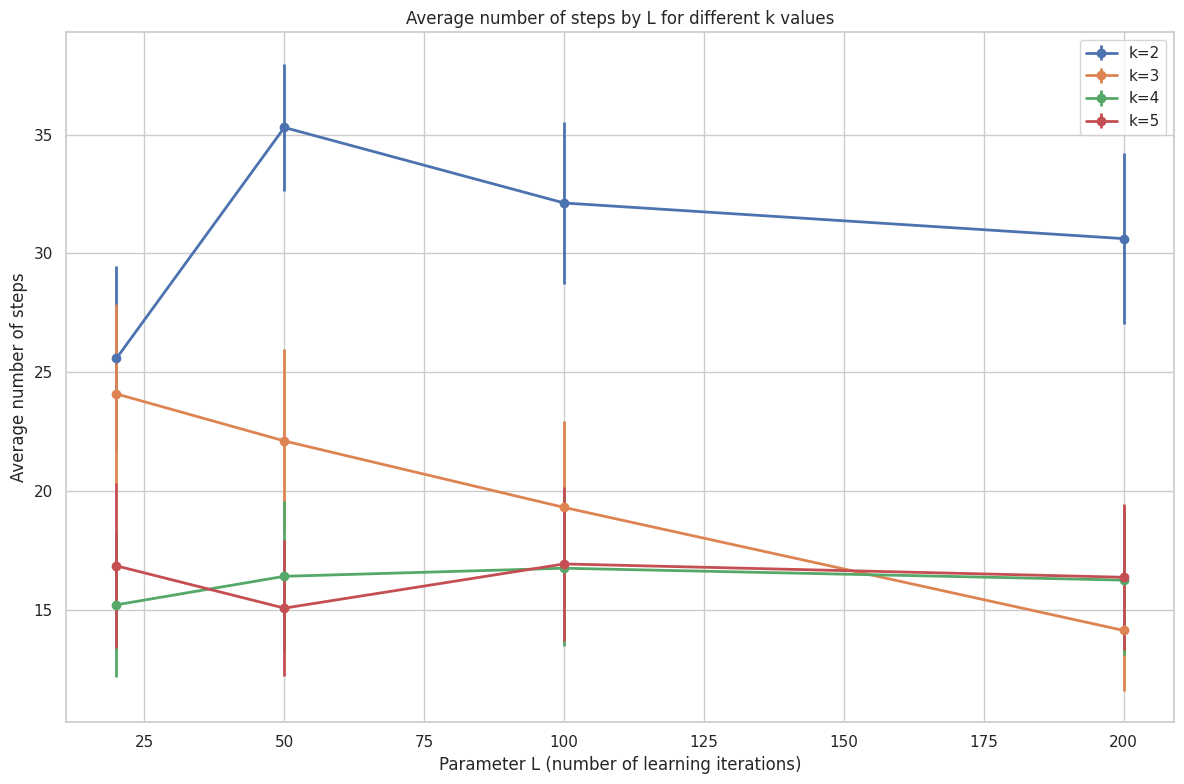

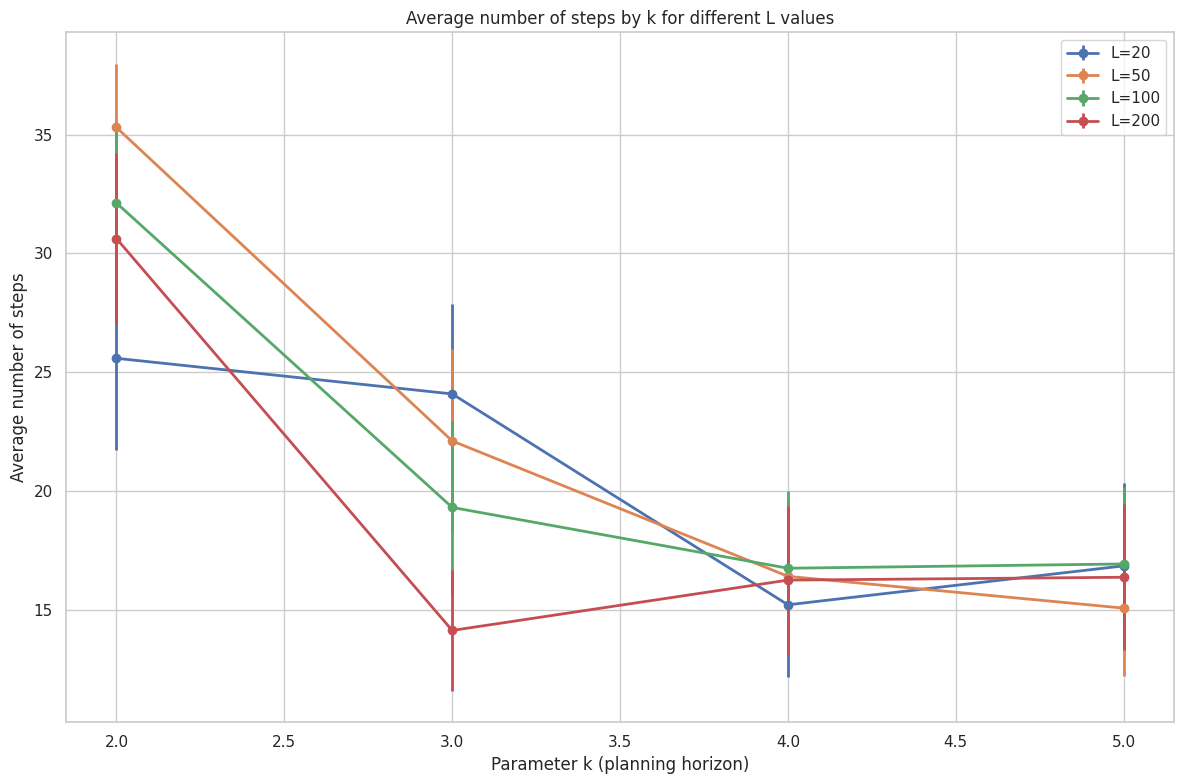

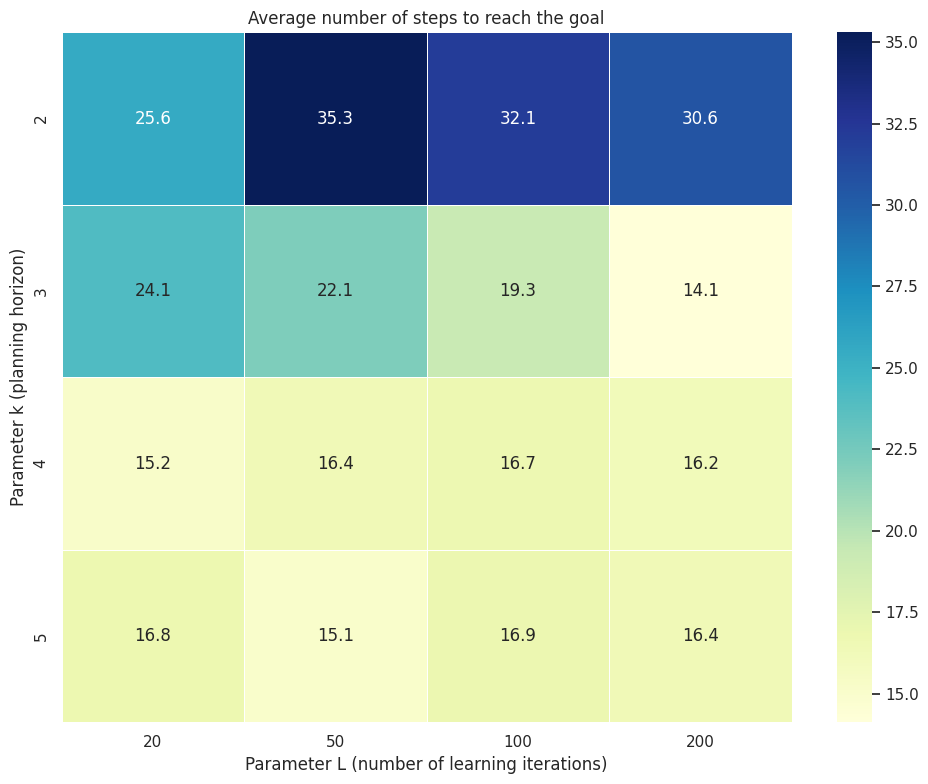

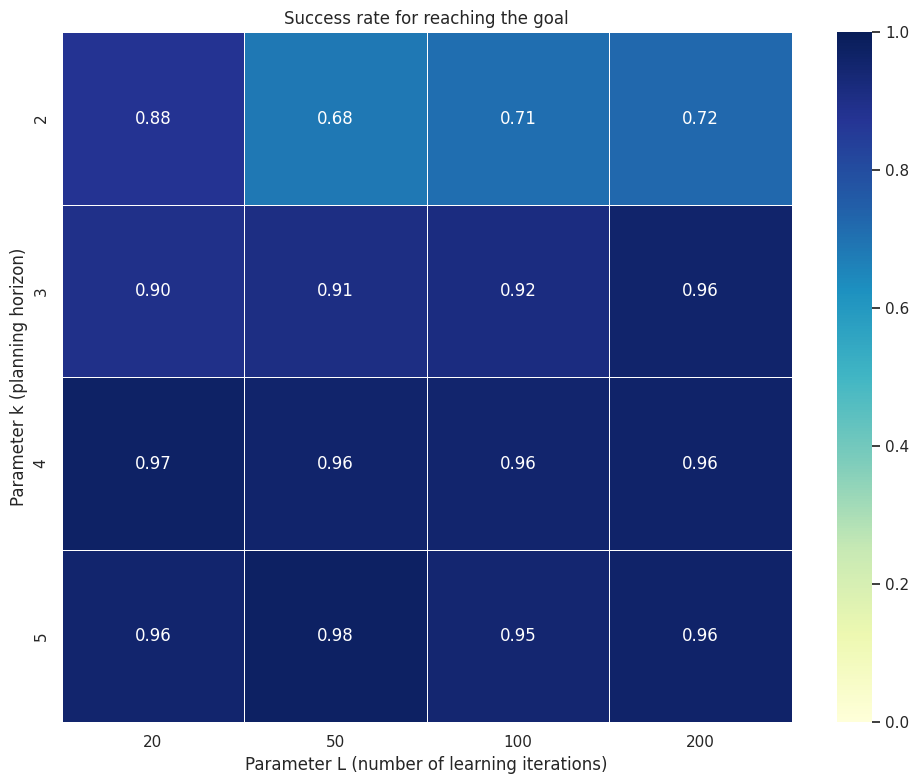

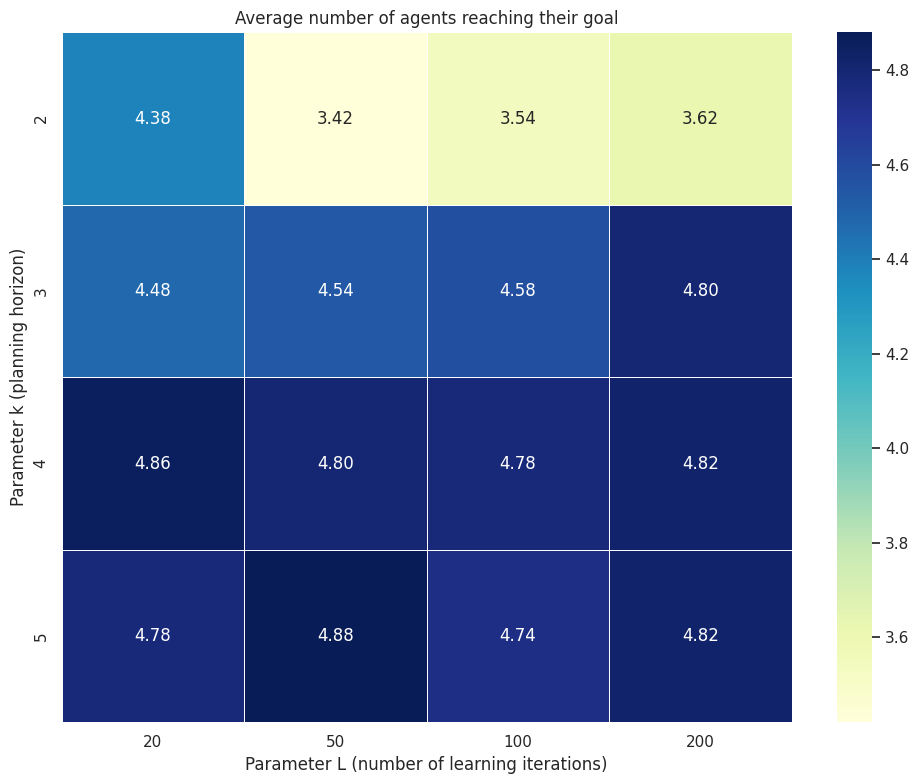

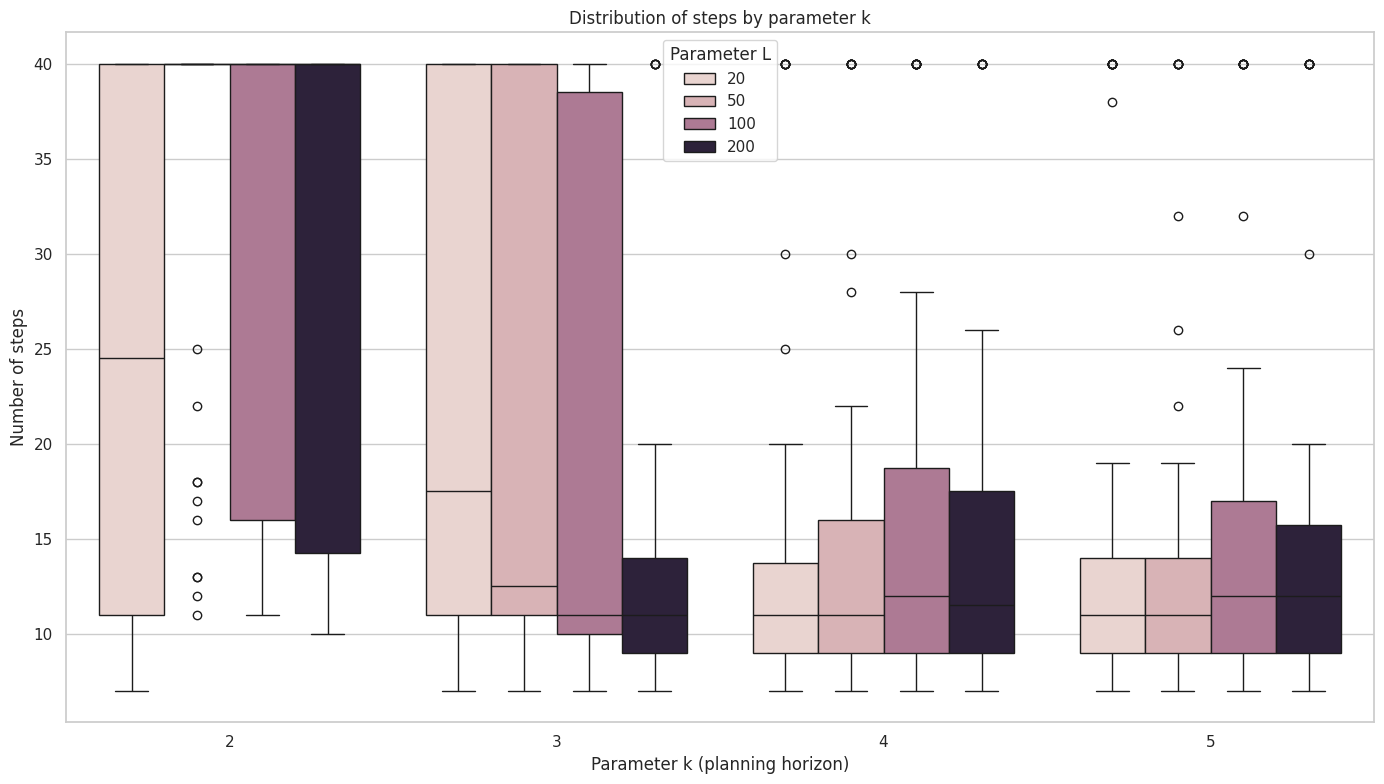

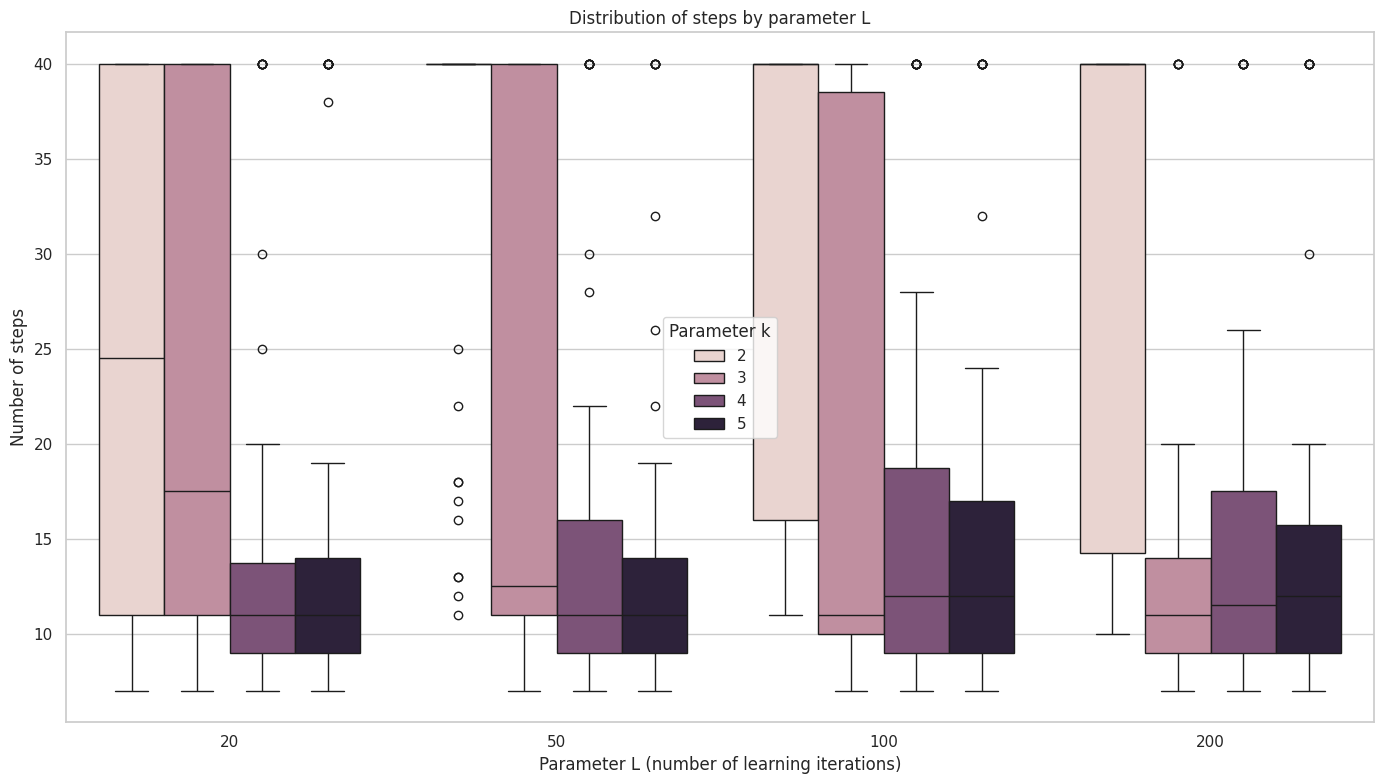

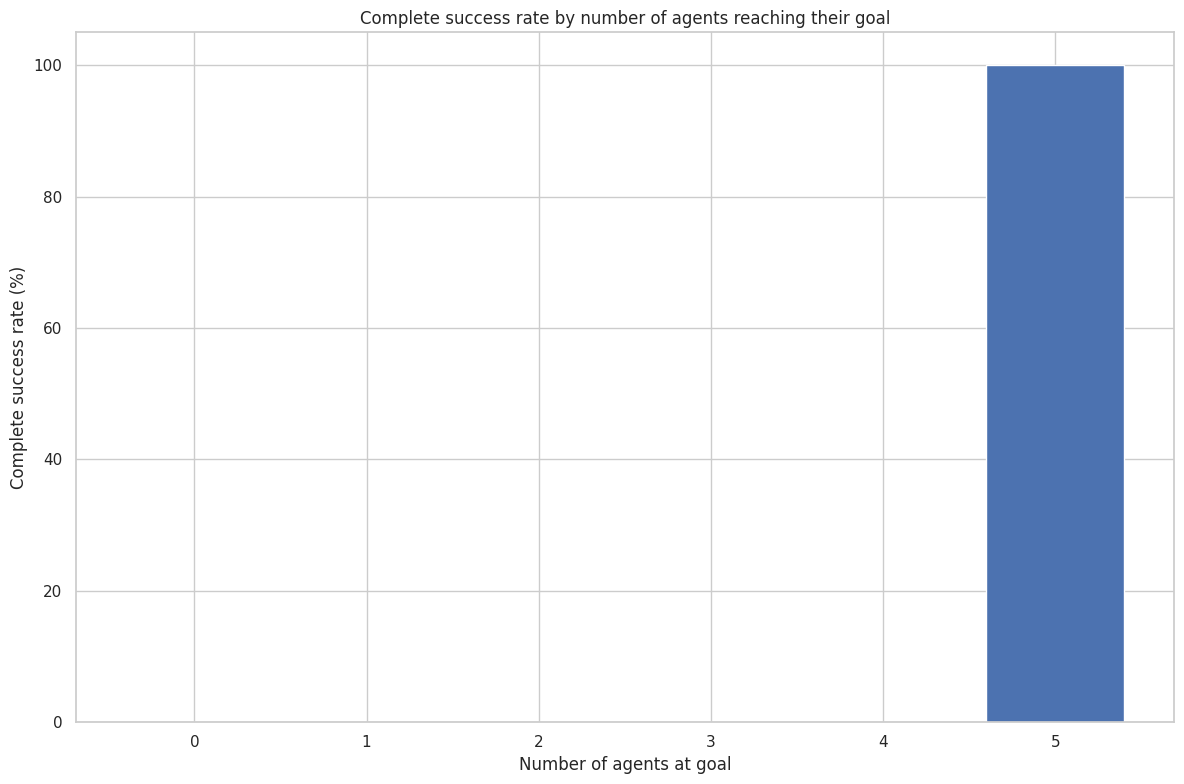

In [ ]:
import seaborn as sns
# Créer les graphiques
figures_dir = os.path.expanduser("~/Desktop/Projet_MARL/Figures/VaryingAgents")
os.makedirs(figures_dir, exist_ok=True)
plot_varying_agents_results(df_results, figures_dir)

# Créer un tableau récapitulatif des meilleurs paramètres pour chaque nombre d'agents
print("\n===== Best Parameters Summary =====")
best_params_summary = []

for num_agents in sorted(df_results['num_agents'].unique()):
    data = df_results[df_results['num_agents'] == num_agents]
    
    # Grouper par k et L pour trouver les meilleurs paramètres
    summary = data.groupby(['k', 'L']).agg({
        'steps': 'mean',
        'complete_success': 'mean',
        'agents_at_goal': 'mean'
    }).reset_index()
    
    # Trouver les paramètres qui maximisent le nombre d'agents arrivés, puis le taux de succès complet
    best_row = summary.sort_values(['agents_at_goal', 'complete_success', 'steps'], 
                                  ascending=[False, False, True]).iloc[0]
    
    best_params_summary.append({
        'num_agents': num_agents,
        'best_k': best_row['k'],
        'best_L': best_row['L'],
        'avg_steps': best_row['steps'],
        'complete_success_rate': best_row['complete_success'],
        'avg_agents_at_goal': best_row['agents_at_goal'],
        'percent_agents_at_goal': best_row['agents_at_goal'] / num_agents * 100
    })

# Afficher et enregistrer le tableau récapitulatif
best_params_df = pd.DataFrame(best_params_summary)
print(best_params_df.to_string(index=False))

best_params_path = os.path.join(figures_dir, "best_parameters_summary.csv")
best_params_df.to_csv(best_params_path, index=False)
print(f"Best parameters summary saved to: {best_params_path}")


Plot saved to: /home/yacine/Desktop/Projet_MARL/Figures/OptimalParameters/success_rate_best_L_for_each_k.png
Best L summary saved to: /home/yacine/Desktop/Projet_MARL/Figures/OptimalParameters/best_L_for_success_rate_by_k.csv
Heatmap saved to: /home/yacine/Desktop/Projet_MARL/Figures/OptimalParameters/success_rate_heatmap_best_L.png

Best L values for each k (optimizing for success rate):
k=1: Best L=20.0
k=2: Best L=20.0
k=3: Best L=200.0
k=4: Best L=100.0
k=5: Best L=200.0


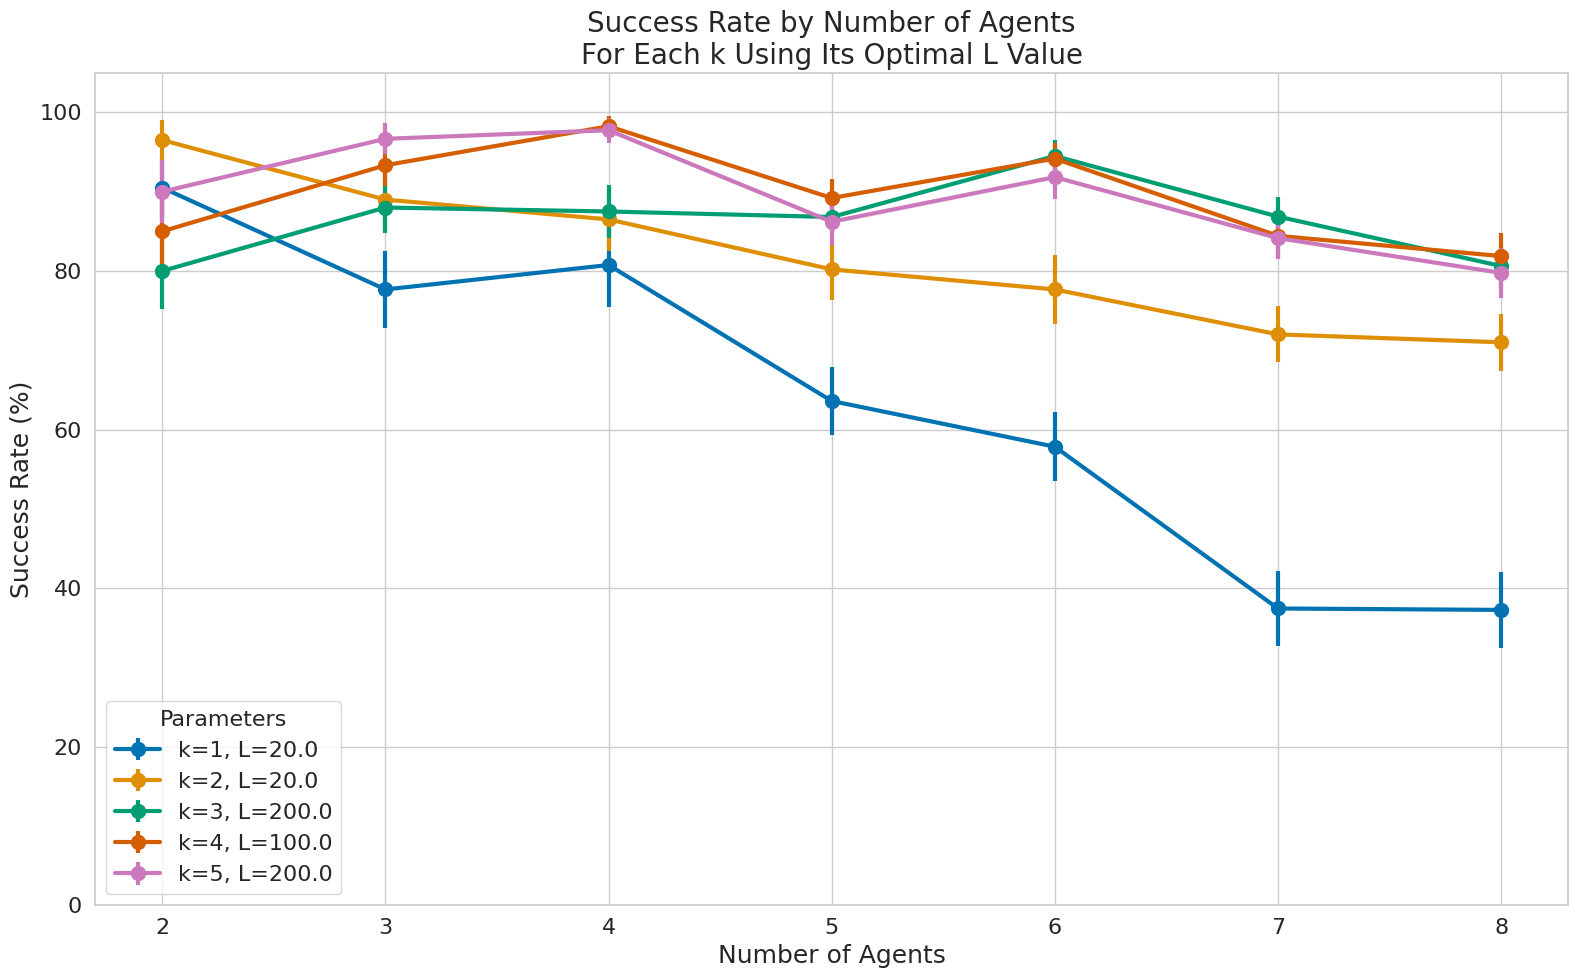

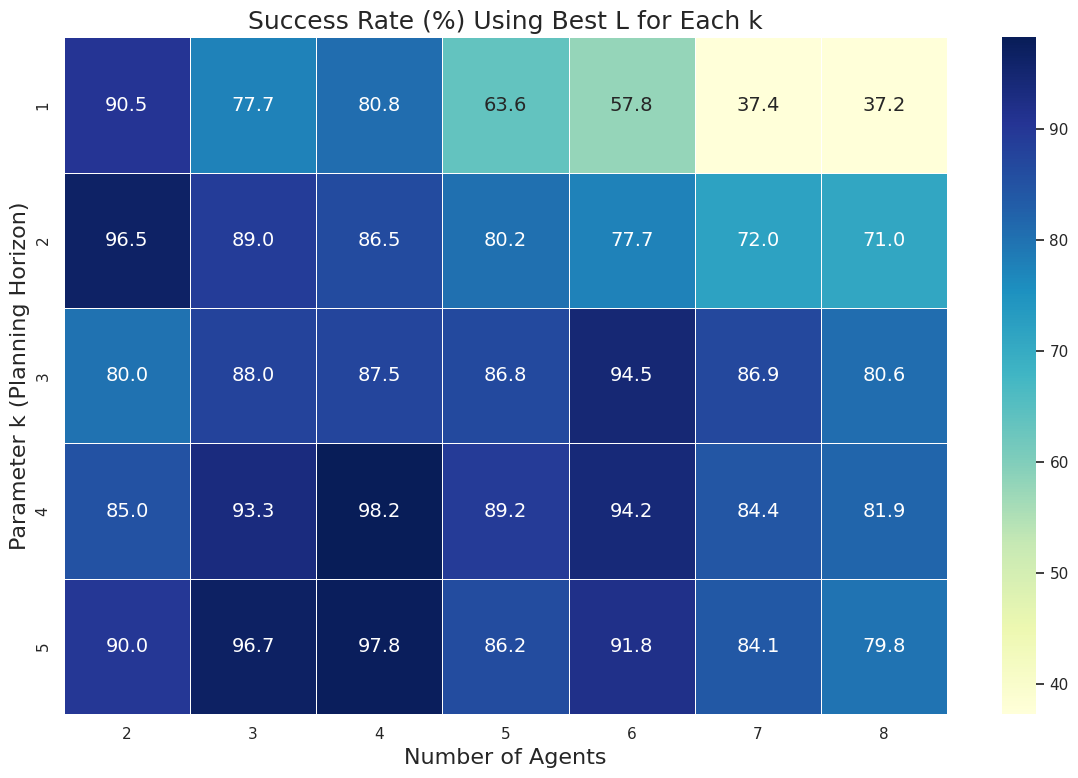

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

def create_success_rate_for_each_k_plot():
    """
    Creates a plot showing the success rate (percentage of agents reaching goals) for each k value
    using the best L value for that k, for agents from 2 to 8.
    """
    # Define paths to the result files
    base_path = os.path.expanduser("~/Desktop/Projet_MARL/Results")
    
    # Try to find the combined dataset first
    combined_file = os.path.join(base_path, "VaryingAgents_Combined", "varying_agents_combined_study.csv")
    
    # If the combined file doesn't exist, merge the data from separate files
    if not os.path.exists(combined_file):
        print("Combined dataset not found. Looking for individual datasets...")
        regular_file = os.path.join(base_path, "VaryingAgents", "varying_agents_parameter_study.csv")
        k1_file = os.path.join(base_path, "VaryingAgents_k1", "varying_agents_parameter_study.csv")
        
        if not os.path.exists(regular_file):
            print(f"Error: Regular dataset file not found - {regular_file}")
            return None
        
        if not os.path.exists(k1_file):
            print(f"Warning: k1 dataset file not found - {k1_file}")
            print("Proceeding with only the regular dataset.")
            df_combined = pd.read_csv(regular_file)
        else:
            # Merge the datasets
            df_regular = pd.read_csv(regular_file)
            df_k1 = pd.read_csv(k1_file)
            df_combined = pd.concat([df_regular, df_k1], ignore_index=True)
    else:
        # Load the combined dataset
        df_combined = pd.read_csv(combined_file)
    
    # Filter data to only include agents from 2 to 8
    df_filtered = df_combined[df_combined['num_agents'].between(2, 8)]
    
    # Create figures directory for the new plot
    figures_dir = os.path.expanduser("~/Desktop/Projet_MARL/Figures/OptimalParameters")
    os.makedirs(figures_dir, exist_ok=True)
    
    # Configure plot style
    sns.set(style="whitegrid")
    plt.rcParams.update({'font.size': 14})
    
    # Get sorted unique k values and agent counts
    k_values = sorted(df_filtered['k'].unique())
    agent_counts = sorted(df_filtered['num_agents'].unique())
    
    # Find the best L value for each k based on success_rate, independent of agent count
    best_L_for_k = {}
    for k in k_values:
        # For each k, group by L and find the L that maximizes success rate
        k_data = df_filtered[df_filtered['k'] == k]
        success_by_L = k_data.groupby('L')['success_rate'].mean().reset_index()
        best_L = success_by_L.loc[success_by_L['success_rate'].idxmax()]['L']
        best_L_for_k[k] = best_L
    
    # Create DataFrame to hold success rates for each k-agent combination using the best L
    success_rates = []
    
    for k in k_values:
        best_L = best_L_for_k[k]
        for num_agents in agent_counts:
            data = df_filtered[(df_filtered['k'] == k) & 
                              (df_filtered['L'] == best_L) & 
                              (df_filtered['num_agents'] == num_agents)]
            
            if not data.empty:
                success_rate = data['success_rate'].mean() * 100
                success_std = data['success_rate'].std() * 100
                count = len(data)
                ci95 = 1.96 * success_std / np.sqrt(count)
                
                success_rates.append({
                    'k': k,
                    'best_L': best_L,
                    'num_agents': num_agents,
                    'success_rate': success_rate,
                    'ci95': ci95
                })
    
    success_df = pd.DataFrame(success_rates)
    
    # Create the plot
    plt.figure(figsize=(16, 10))
    
    # Create a colormap for different k values
    colors = sns.color_palette("colorblind", n_colors=len(k_values))
    
    # Plot a line for each k value with its best L
    for i, k in enumerate(k_values):
        k_data = success_df[success_df['k'] == k]
        best_L = k_data['best_L'].iloc[0] if not k_data.empty else None
        
        if not k_data.empty:
            plt.errorbar(
                k_data['num_agents'],
                k_data['success_rate'],
                yerr=k_data['ci95'],
                marker='o',
                markersize=10,
                linewidth=3,
                color=colors[i],
                label=f'k={k}, L={best_L}'
            )
    
    plt.title('Success Rate by Number of Agents\nFor Each k Using Its Optimal L Value', fontsize=20)
    plt.xlabel('Number of Agents', fontsize=18)
    plt.ylabel('Success Rate (%)', fontsize=18)
    plt.xticks(agent_counts, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(0, 105)
    plt.grid(True)
    plt.legend(fontsize=16, title='Parameters', title_fontsize=16)
    plt.tight_layout()
    
    # Save the plot
    plot_path = os.path.join(figures_dir, 'success_rate_best_L_for_each_k.png')
    plt.savefig(plot_path, dpi=300)
    print(f"Plot saved to: {plot_path}")
    
    # Create a summary table showing the best L for each k
    best_L_summary = pd.DataFrame({
        'k': list(best_L_for_k.keys()),
        'best_L': list(best_L_for_k.values())
    })
    
    summary_path = os.path.join(figures_dir, 'best_L_for_success_rate_by_k.csv')
    best_L_summary.to_csv(summary_path, index=False)
    print(f"Best L summary saved to: {summary_path}")
    
    # Create a comparative heatmap showing success rate for different k-agent combinations
    plt.figure(figsize=(12, 8))
    
    # Pivot the data to create a heatmap
    heatmap_data = success_df.pivot_table(
        values='success_rate',
        index='k',
        columns='num_agents'
    )
    
    # Plot the heatmap
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=.5)
    plt.title('Success Rate (%) Using Best L for Each k', fontsize=18)
    plt.xlabel('Number of Agents', fontsize=16)
    plt.ylabel('Parameter k (Planning Horizon)', fontsize=16)
    plt.tight_layout()
    
    heatmap_path = os.path.join(figures_dir, 'success_rate_heatmap_best_L.png')
    plt.savefig(heatmap_path, dpi=300)
    print(f"Heatmap saved to: {heatmap_path}")
    
    return best_L_for_k, success_df

if __name__ == "__main__":
    best_L_for_k, success_df = create_success_rate_for_each_k_plot()
    print("\nBest L values for each k (optimizing for success rate):")
    for k, L in best_L_for_k.items():
        print(f"k={k}: Best L={L}")